In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from IPython.display import display
import importlib
import sys
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [2]:
import copy
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from collections import Counter
from logzero import logger
from BITS.run import run_edlib
from BITS.seq import revcomp
from dataclasses import dataclass, field, InitVar
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
from dacembler.clustering import ClusteringSeqs, ClusteringNumeric
import consed

## Sequence loading

In [30]:
with open("/home/yoshihiko_s/work2/project/CentromereAssembly/consed_output/4677.0.seqs", 'r') as f:
    seqs = [line.strip() for line in f]

In [31]:
seqs = [s.replace('N', '') for i, s in enumerate(seqs) if i != 0]

In [32]:
seqs

['atctctacagtatctctgtcgctgtagctcgatcgtatacgcatgacgtctatatgtactacgcatactgtgcgtacagtgacaga',
 'atcgtgtacatagtatctctgtgcgctgtactcgatcgtatacagcatgacgcgctatatgtatagcgatactgtgctacagtgacaga',
 'atctgtatcagtatctctgtcgctgtactcgatcgtatacatgacgcatatactgtacatagcatagctgtgctacagtgcacag',
 'atgtagagtatctctgtcgctgtacgtcgatcgtatacatgacgctatatgtactagcatctgtgcgtacagtgagcaga',
 'atctagtagtatctctgtcatctgtgatcgacatcacatgacgtagatgtactagcatactgtctgctatcagtgacaga',
 'atctgtagagtatctctgtgtctgtagctgatcgatcacacatgtgacgctatgtactcagagctatactgtgctacagtgagcaga',
 'atctagagtatcatgtgtctgtatatgtgatcacacgcatgacgctatgtactagcatactgtgctacgcagtgacaga',
 'atctgtagagtatctctgtgtctgtactgatcgatcactagtatgcatgacgctatgtagctagcatactgtgctacagtgcaga',
 'atctgtatagtatctgtgtctgtactgatcgatcacgacatgacgcgctacatgtactagtgcatactgtgctacagtgacaga',
 'atgctgtagagtctctgtgtcgtagctgatatcgatcagcatgacgatatgtactagcatatactgtgctacgtcagtgacaga',
 'atctgtagatgtatctgtgtctgtactgatcgatatcacatgagcgcgctatgtactcagcatactgtgctacagtgacaga',
 'atatctagagtatctgtgtctg

## Global sequence dist

In [33]:
c = ClusteringSeqs(pd.Series(seqs))

In [34]:
c.calc_dist_mat()

[I 190617 11:02:50 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a192e80>,), kwds={})
[D 190617 11:02:50 clustering:178] Starting row 0-21
[I 190617 11:02:50 utils:57] Finished distance matrix calculation


In [35]:
c.plot_dist_mat()

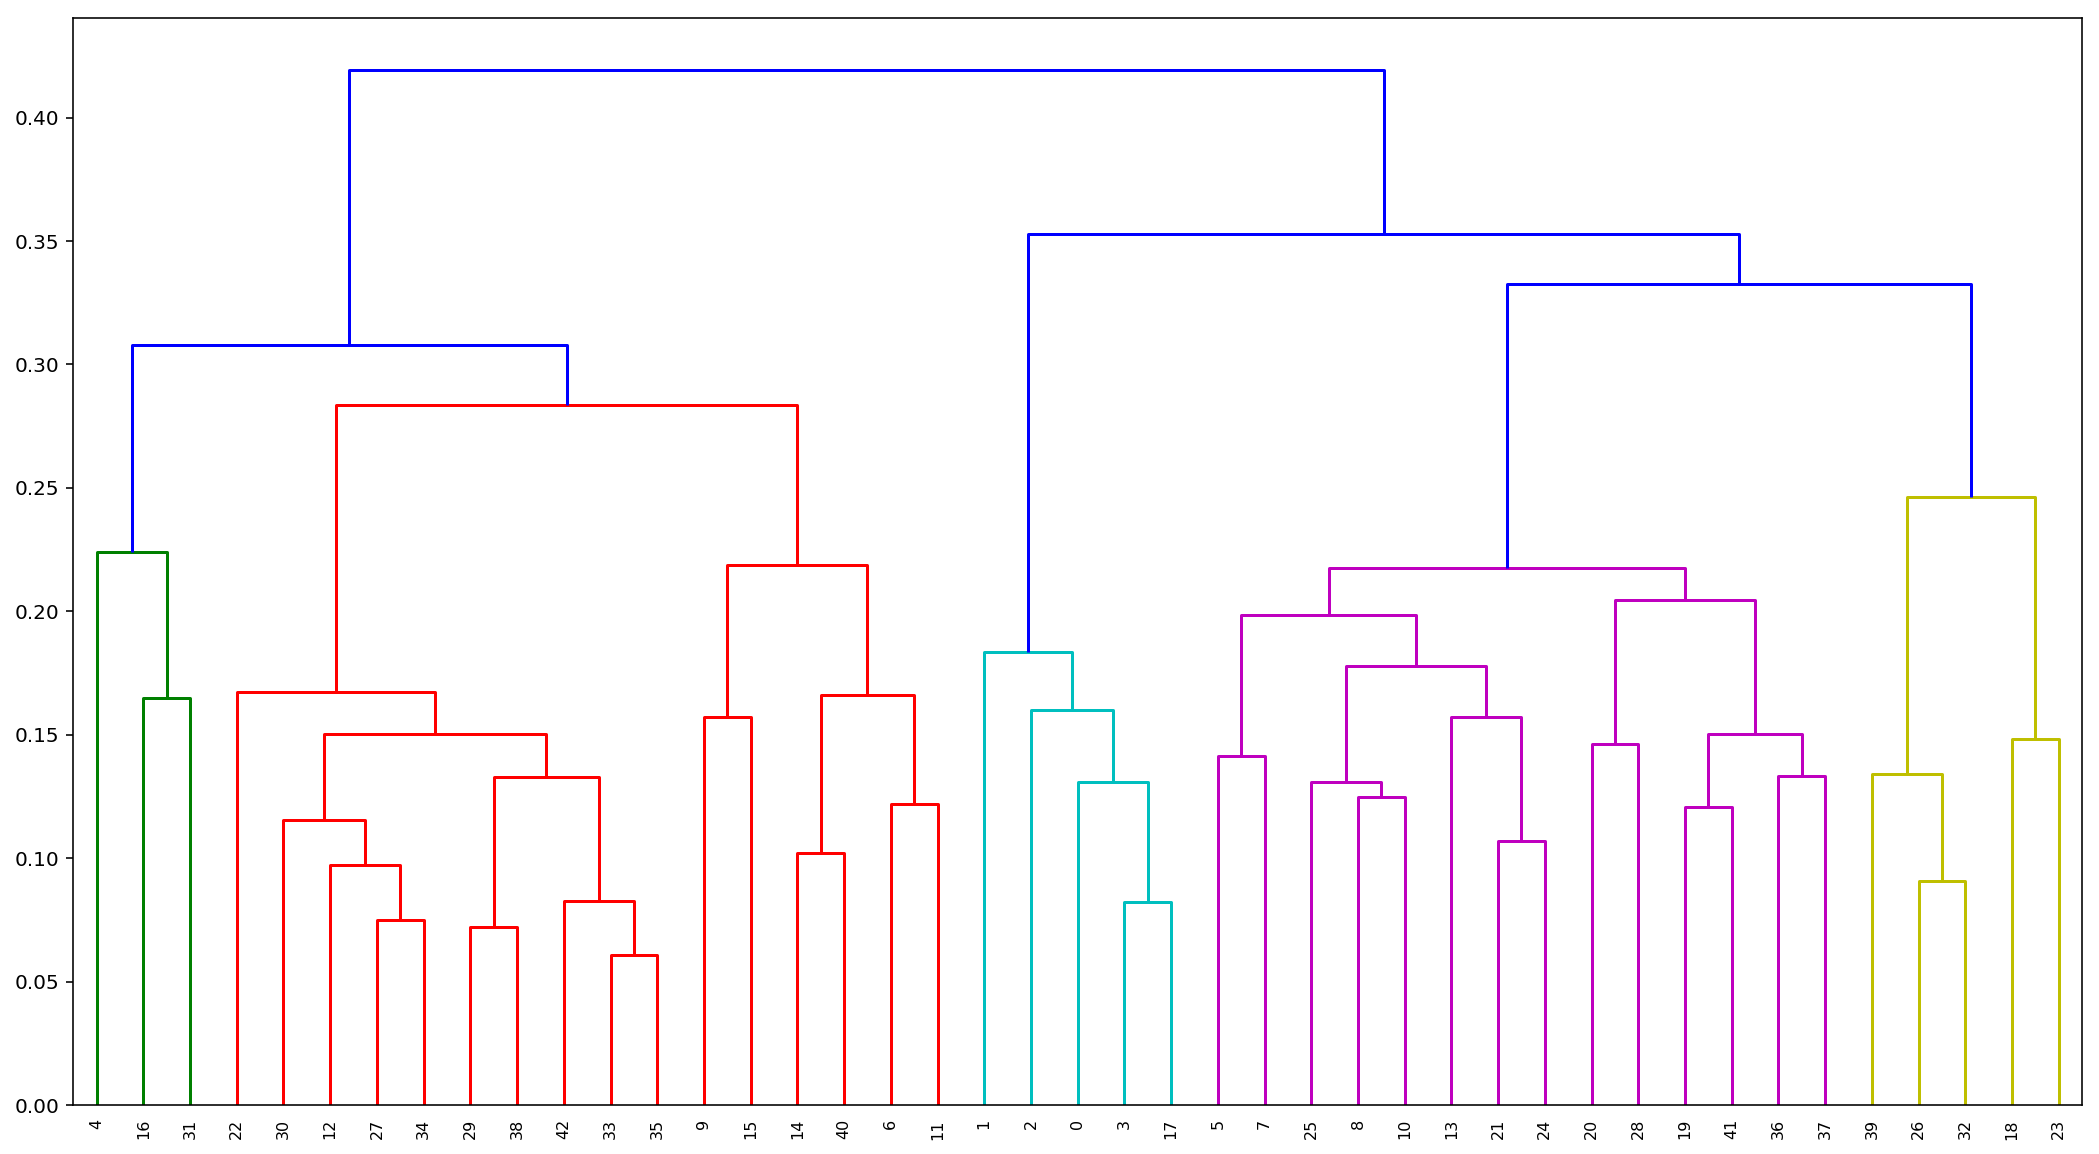

In [535]:
c.dendrogram()

## Comptute dendrogram merging order

In [530]:
merges = []
breakdown = {i: set([i]) for i in range(len(seqs))}
new_node = len(seqs)
for x in c.precomputed["ward"]:
    i, j = map(int, x[:2])
    #print(int(i), int(j))
    merges.append((i, j))
    breakdown[new_node] = breakdown[i] | breakdown[j]
    new_node += 1

In [470]:
merges

[(33, 35),
 (29, 38),
 (27, 34),
 (3, 17),
 (42, 43),
 (26, 32),
 (12, 45),
 (14, 40),
 (21, 24),
 (30, 49),
 (19, 41),
 (6, 11),
 (8, 10),
 (0, 46),
 (25, 55),
 (44, 47),
 (36, 37),
 (39, 48),
 (5, 7),
 (20, 28),
 (18, 23),
 (52, 58),
 (53, 59),
 (13, 51),
 (9, 15),
 (2, 56),
 (16, 31),
 (50, 54),
 (22, 64),
 (57, 66),
 (1, 68),
 (61, 72),
 (62, 65),
 (74, 75),
 (67, 70),
 (4, 69),
 (60, 63),
 (71, 77),
 (78, 80),
 (76, 79),
 (73, 82),
 (81, 83)]

In [471]:
breakdown

{0: {0},
 1: {1},
 2: {2},
 3: {3},
 4: {4},
 5: {5},
 6: {6},
 7: {7},
 8: {8},
 9: {9},
 10: {10},
 11: {11},
 12: {12},
 13: {13},
 14: {14},
 15: {15},
 16: {16},
 17: {17},
 18: {18},
 19: {19},
 20: {20},
 21: {21},
 22: {22},
 23: {23},
 24: {24},
 25: {25},
 26: {26},
 27: {27},
 28: {28},
 29: {29},
 30: {30},
 31: {31},
 32: {32},
 33: {33},
 34: {34},
 35: {35},
 36: {36},
 37: {37},
 38: {38},
 39: {39},
 40: {40},
 41: {41},
 42: {42},
 43: {33, 35},
 44: {29, 38},
 45: {27, 34},
 46: {3, 17},
 47: {33, 35, 42},
 48: {26, 32},
 49: {12, 27, 34},
 50: {14, 40},
 51: {21, 24},
 52: {12, 27, 30, 34},
 53: {19, 41},
 54: {6, 11},
 55: {8, 10},
 56: {0, 3, 17},
 57: {8, 10, 25},
 58: {29, 33, 35, 38, 42},
 59: {36, 37},
 60: {26, 32, 39},
 61: {5, 7},
 62: {20, 28},
 63: {18, 23},
 64: {12, 27, 29, 30, 33, 34, 35, 38, 42},
 65: {19, 36, 37, 41},
 66: {13, 21, 24},
 67: {9, 15},
 68: {0, 2, 3, 17},
 69: {16, 31},
 70: {6, 11, 14, 40},
 71: {12, 22, 27, 29, 30, 33, 34, 35, 38, 42

## Definition of `MaskedSeq` class

In [3]:
class MaskedSeq:
    def __init__(self, seq, cigar):
        self.string = ""
        self.reliable = set()
        pos = 0
        tmp_pos = 0
        for c in cigar:
            if c == '=':
                self.string += seq[tmp_pos].upper()
                self.reliable.add(pos)
            elif c == 'I':
                self.string += '~'
            elif c == 'J':
                self.reliable.add(pos)
            elif c == 'D' or c == 'N':
                self.string += seq[tmp_pos]
            #print(pos)
            #print(c)
            #print(self.string)
            #print(self.reliable)
            if c != 'J':
                pos += 1
            if c != 'I' and c != 'J':
                tmp_pos += 1

## Calculation MaskedSeqs for 1 read

In [617]:
units = [ExtSeq(u) for u in seqs]
masked_units = {}
for i, j in merges:
    print(f"merge {i}({units[i].size}) and {j}({units[j].size}) -> {len(units)}")
    ui, uj = units[i], units[j]
    #PairwiseAlignment(ui.consensus(single=True, full=True), uj.consensus(single=True, full=True)).show()
    uij, diff, cigar = align_ext_seq(ui, uj)
    units.append(uij)
    #print(f"diff={round(diff, 3)}")
    uij.show()
    print(cigar)
    if units[i].size == 1:
        masked_units[i] = MaskedSeq(ui.consensus(single=True), cigar)
        print(f"unit {i}: {masked_units[i].string}")
    if units[j].size == 1:
        uij, diff, cigar = align_ext_seq(uj, ui)
        masked_units[j] = MaskedSeq(uj.consensus(single=True), cigar)
        print(f"unit {j}: {masked_units[j].string}")
    #print()
    #print()

merge 33(1) and 35(1) -> 43
atctgtagagtat*ctc*gtgtctgtag*tgatcgatcacatgacgctatgtactagcata**tgtgctacgcagtgacaga
=============I===I==========I================================II===================
unit 33: ATCTGTAGAGTAT~CTC~GTGTCTGTAG~TGATCGATCACATGACGCTATGTACTAGCATA~~TGTGCTACGCAGTGACAGA
unit 35: ATCTGTAGAGTATgCTCtGTGTCTGTAGcTGATCGATCACATGACGCTATGTACTAGCATAgcTGTGCTACGCAGTGACAGA
merge 29(1) and 38(1) -> 44
atctgtagatagtatctctgtgtctgtactgatcgatcac*tgacg**tatgtactagcatactgtgc*tac**agtgacaga
========================================I=====NI====================D===II=========
unit 29: ATCTGTAGATAGTATCTCTGTGTCTGTACTGATCGATCAC~TGACGc~TATGTACTAGCATACTGTGCgTAC~~AGTGACAGA
unit 38: ATCTGTAGATAGTATCTCTGTGTCTGTACTGATCGATCACaTGACGtaTATGTACTAGCATACTGTGC~TACgcAGTGACAGA
merge 27(1) and 34(1) -> 45
atctgtagagtatct**gtgtctgtactgatcgat*acatgacgctat**gtactagcatactgt*gctacagtgacaga
===============II==================N============II===============I==============
unit 27: ATCTGTAGAGTATCT~~GTGTCTGTACTGATCGATcACATG

at-ctgta-ga-gtat-ct**gtgtctgtactg-atcgat---c--a--catga-c-g-cgct-a---tgtact-ag--cat-*ctgtgctacagtgac-aga
==J=====E==E====J==II============J======EDE=EE=JI=====E=J=J====J=EED======E==EE===JD===============J===
merge 1(1) and 68(4) -> 73
atc-tgta*-a--gtatctctgt-cgctgta-c-tcgatcgtatac--a---tga-cg-c---tata-tgtac-t-a-gc-ata-ctgtgc*tacagtg-a-caga
===D====NJ=DD==========D=======J=J============JJ=DDD===J==J=JDD====J====IJ=J=J==D===J======I=======J=J====
unit 1: ATCgTGTAcAtaGTATCTCTGTgCGCTGTACTCGATCGTATACAgcaTGACGCgcTATATGTA~TAGCgATACTGTGC~TACAGTGACAGA
merge 61(2) and 72(6) -> 74
at-ctgta-ga-gtat-ct**gtgtctgta-ctg-atcgat---c--a--c-a---tg-a-*-g--cgct-a---tgta-ct--ag----c-at-*ctgtgctacagtga-c-aga
==J=====J==J====J=============E===J======JJJ=JJ=JJ=E=DED==E=JNJ=JD====J=JJJ====E==JE==JJEE=E==J===============E=J===
merge 62(2) and 65(4) -> 75
a-tctgtag-agtatctc-tgtgtctgta-ctg-a--tcga-t--*-ca-cat--gacgcgctatatgta--cta---gcata*-tgt---gcta-cagtga-caga
=E=======E=======NE==========E===J=JJ====J=JJIJ==J===

### Some alignment visualization trials

In [29]:
print("""
Unit 1: atcgtgtacatagtatctctgtgcgctgtactcgatcgtatacagcatgacgcgctatatgtatagcgatactgtgctacagtgacaga
          ↓
        ATCgTGTAcAtaGTATCTCTGTgCGCTGTACTCGATCGTATACAgcaTGACGCgcTATATGTA~TAGCgATACTGTGC~TACAGTGACAGA
""")


Unit 1: atcgtgtacatagtatctctgtgcgctgtactcgatcgtatacagcatgacgcgctatatgtatagcgatactgtgctacagtgacaga
          ↓
        ATCgTGTAcAtaGTATCTCTGTgCGCTGTACTCGATCGTATACAgcaTGACGCgcTATATGTA~TAGCgATACTGTGC~TACAGTGACAGA



In [620]:
# THIS IS IMPORTANT!

for i, ms in sorted(masked_units.items()):
    print(i)
    print(seqs[i])
    print(ms.string)

0
atctctacagtatctctgtcgctgtagctcgatcgtatacgcatgacgtctatatgtactacgcatactgtgcgtacagtgacaga
ATCTcTAcAGTATCTCTGTCGCTGTAgCTCGATCGTATACgcATGACGtCTATATGTACTAcGCATACTGTGCGTACAGTGACAGA
1
atcgtgtacatagtatctctgtgcgctgtactcgatcgtatacagcatgacgcgctatatgtatagcgatactgtgctacagtgacaga
ATCgTGTAcAtaGTATCTCTGTgCGCTGTACTCGATCGTATACAgcaTGACGCgcTATATGTA~TAGCgATACTGTGC~TACAGTGACAGA
2
atctgtatcagtatctctgtcgctgtactcgatcgtatacatgacgcatatactgtacatagcatagctgtgctacagtgcacag
ATCTGTAtcAGTATCTCTGTCGCTGTACTCGATCGTATACATGACGCaTATAcTGTACaTAGCATAgCTGTGC~TACAGTGcACAG~
3
atgtagagtatctctgtcgctgtacgtcgatcgtatacatgacgctatatgtactagcatctgtgcgtacagtgagcaga
AT~~GTAGAGTATCTCTGTCGCTGTACgTCGATCGTATACATGA~CGCTATATGTACT~AGCAT~CTGTGCGTACAGTGAgCAGA
4
atctagtagtatctctgtcatctgtgatcgacatcacatgacgtagatgtactagcatactgtctgctatcagtgacaga
ATCTagTAGtA~TcTCTGTCatCTGT~~~GATCGACATCACATGACGTAgATGTACTAGCATACTGTctGCTAtCAGTGACAGA
5
atctgtagagtatctctgtgtctgtagctgatcgatcacacatgtgacgctatgtactcagagctatactgtgctacagtgagcaga
ATCTGTAGAGTATCTCTGTGTCTGTAgCTGATCGATC

In [625]:
PairwiseAlignment(masked_units[1].string, masked_units[33].string).show(by_cigar=True)

ATCgTGTAcAtaGTAT-CTCTGTgCGCTGTAC-TCGATCGTATACAgcaTGACGCgcTATATGTA~TAGCgATAC-TGTGC~TAC--AGTGACAGA
===D====X=DD====I===X===XD=====XI=D=====D==D==D========DD===DD===X====D===XI=====D===II=========
ATC-TGTAGA--GTAT~CTC~GTGT-CTGTAG~T-GATCG-AT-CA-CATGACGC--TAT--GTACTAGC-ATA~~TGTGC-TACGCAGTGACAGA


## Some operations definition for MaskedSeq

In [4]:
def is_reliable(c):
    return c in set(['A', 'C', 'G', 'T', '-'])

def align_masked_seq(a, b):
    pa = PairwiseAlignment(a.string, b.string)
    fcigar = ''
    ai = 0
    bi = 0
    for i, c in enumerate(pa.fcigar):
        if c == '=' or (ai < len(a.string) and is_reliable(a.string[ai]) and bi < len(b.string) and is_reliable(b.string[bi])):
            fcigar += c
        elif c == 'X':
            fcigar += '='
        else:
            fcigar += '*'
        if pa.source[i] != '-':
            ai += 1
        if pa.target[i] != '-':
            bi += 1
    return fcigar.replace('*', '')

In [5]:
def fcigar_to_diff(fcigar):
    tot = len(fcigar)
    non_match = len(fcigar.replace('=', ''))
    return non_match / tot

## Distance matrix of MaskedSeqs

In [656]:
dist_mat = np.zeros((len(seqs), len(seqs)))
for i in range(len(seqs)):
    for j in range(len(seqs)):
        if i == j:
            continue
        elif i > j:
            dist_mat[i][j] = dist_mat[j][i]
        else:
            dist_mat[i][j] = fcigar_to_diff(align_masked_seq(masked_units[i], masked_units[j]))

In [658]:
dist_mat[0]

array([0.        , 0.        , 0.        , 0.        , 0.10588235,
       0.1011236 , 0.14117647, 0.12359551, 0.08139535, 0.09411765,
       0.09302326, 0.11904762, 0.08433735, 0.0952381 , 0.14285714,
       0.10588235, 0.09302326, 0.        , 0.11494253, 0.11111111,
       0.10227273, 0.10465116, 0.10344828, 0.09411765, 0.09411765,
       0.08139535, 0.10344828, 0.06024096, 0.1       , 0.09302326,
       0.0952381 , 0.09302326, 0.1011236 , 0.11494253, 0.06097561,
       0.11494253, 0.08045977, 0.08045977, 0.08235294, 0.08235294,
       0.13333333, 0.11111111, 0.10344828])

In [660]:
c = ClusteringSeqs(pd.Series(seqs))
c.s_dist_mat = dist_mat

In [661]:
c.plot_dist_mat()

In [ ]:
# 他のリードでも見てみる

In [662]:
with open("/home/yoshihiko_s/work2/project/CentromereAssembly/consed_output/720.0.seqs", 'r') as f:
    seqs = [line.strip() for line in f]

In [664]:
seqs = [s.replace('N', '') for i, s in enumerate(seqs) if i != 0]

In [665]:
seqs

['tctgtcatcgtcatcatatcatatgtgcatatatctgtctgatatgatgtcatactcactgagctcgtatatcatcactgtgtcatgatatgtgcagtatgcatgatgacactctcgcatatgcgatatcatatctatctcatagtatagatcgtcgcactgtatagctgctgcacagtgtctacatctatgtcacatgtagcagtatacgatcgtgtatatcacatgcga',
 'tctgtcacatcgtctacactatcatatgcagcacatagatatcgatatgatgtctactcactgagctcgtatatgtctatgcacacactgtgtcatgatatgcatatgcatgatgacactctcacactctcgcgatatcacacatatcgctatctcagtatagatcgtagcactgtatagctgctcacagtgtctacatctactgtcacatagcagtatacgatcgtgtatatcacatgcaga',
 'tctgtcacatcgtctcactatcatatgcacacatatatgtctgatatgatgtcatactcatgagctgtatatcatcactgtgtcatgatatgcatatgtatcgatgactctctacatgcgatatgatcgatatctacatctcagatagcgagtcgtagcacgtatcgctgctcagcagtatctacatatgtgacatagcgagtatacgcatcgtgtatcatactgcaga',
 'tcacatctgtctcatatcatctgcacacatatactgtctgatatgagtgtcatactcactgagctgtagtatcatcactgtgtcgacatgatatgcatatgtatgtcgatgactctctacatgcgatgatgacgatatctatctcagtatagatcgtagcactgtatagctgctcacagtatctagcatctatcagcatagcagtatacacgatcgtgtatatcacatgcaga',
 'tctgtcacatcgtctcatcatatgcgcacatatatgtcagat

In [666]:
c = ClusteringSeqs(pd.Series(seqs))
c.calc_dist_mat()

[I 190521 10:07:43 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba576bd86d8>,), kwds={})
[D 190521 10:07:43 clustering:178] Starting row 0-27
[I 190521 10:07:44 utils:57] Finished distance matrix calculation


In [667]:
c.plot_dist_mat()

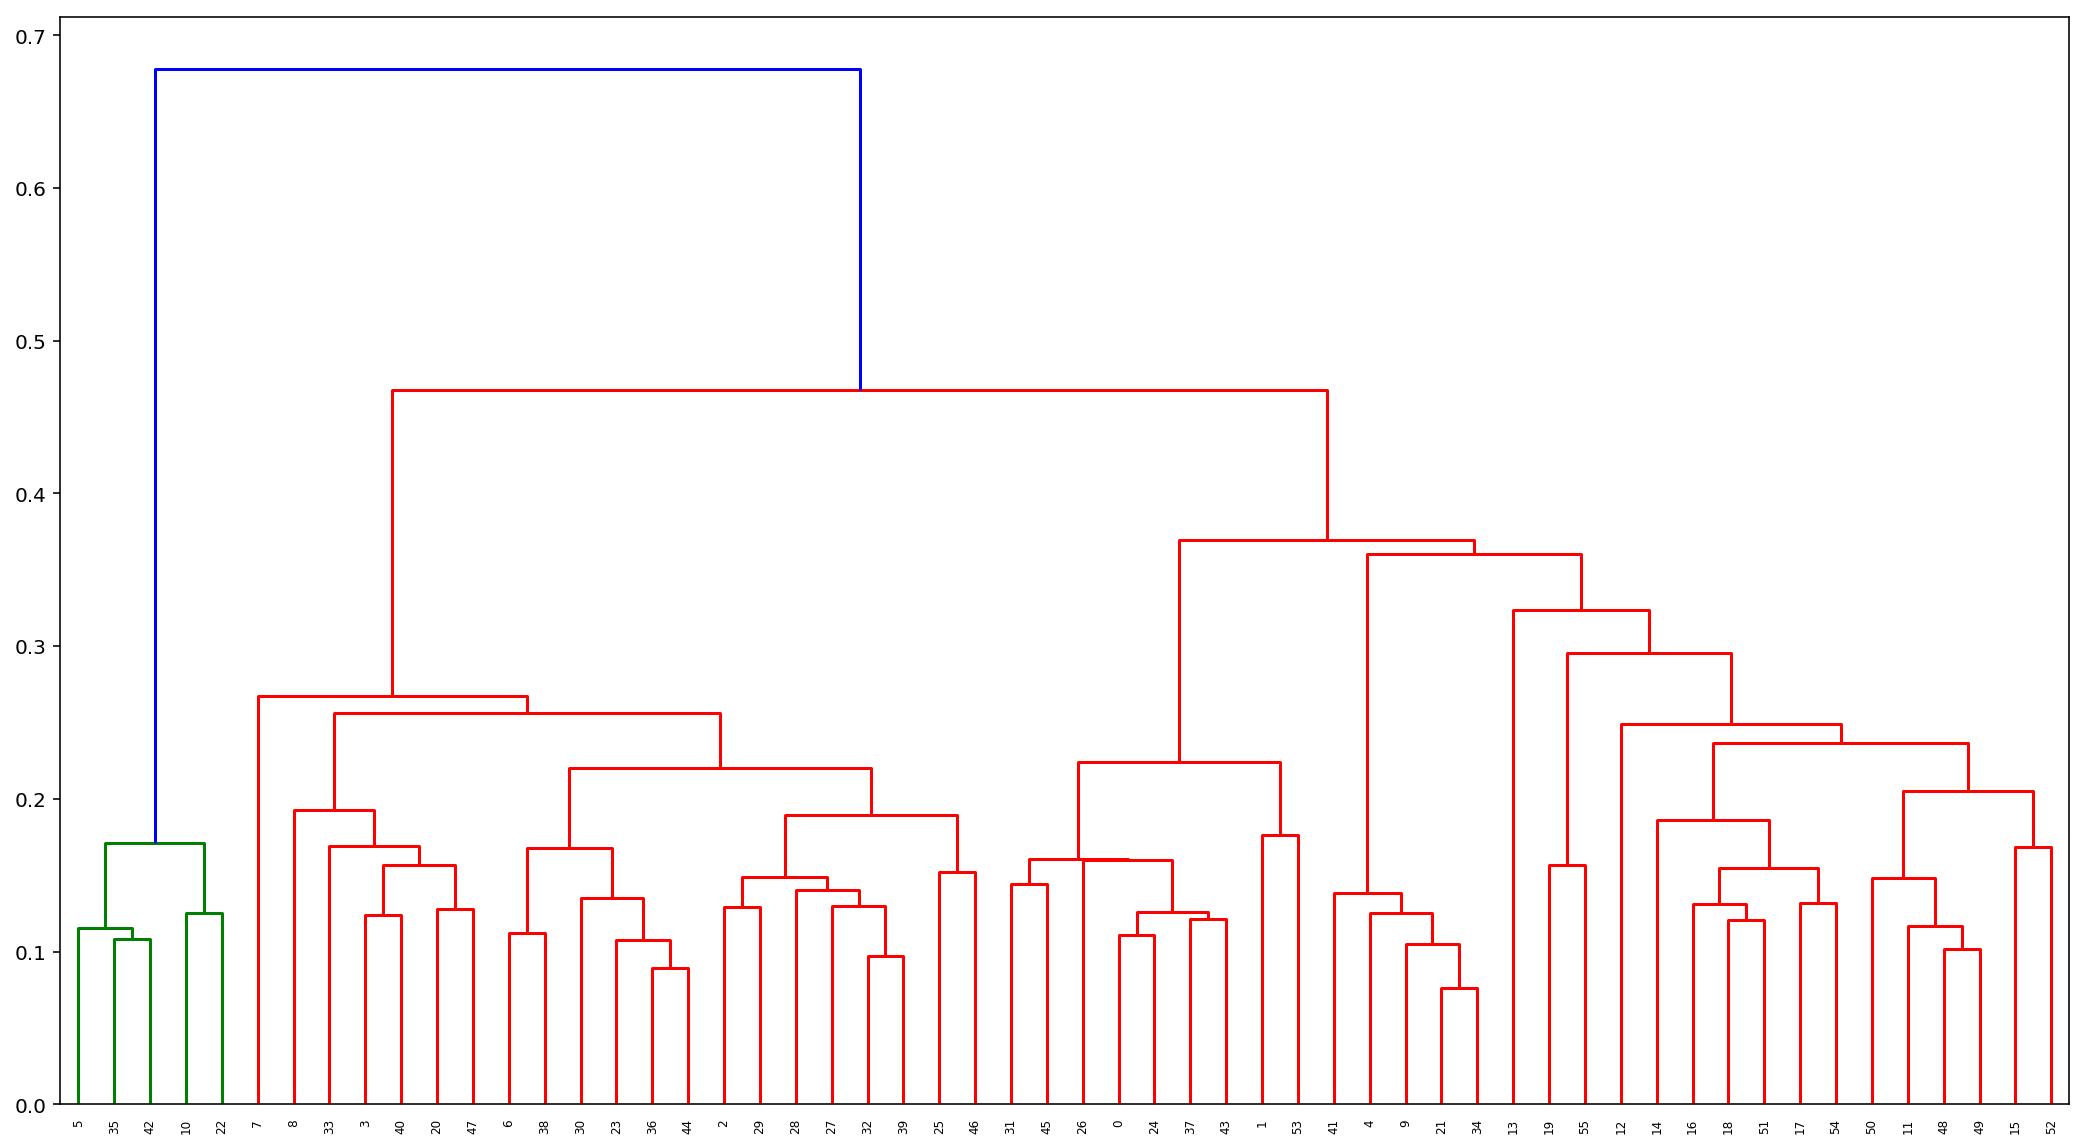

In [668]:
c.dendrogram()

In [669]:
merges = []
breakdown = {i: set([i]) for i in range(len(seqs))}
new_node = len(seqs)
for x in c.precomputed["ward"]:
    i, j = map(int, x[:2])
    #print(int(i), int(j))
    merges.append((i, j))
    breakdown[new_node] = breakdown[i] | breakdown[j]
    new_node += 1

In [670]:
units = [ExtSeq(u) for u in seqs]
masked_units = {}
for i, j in merges:
    print(f"merge {i}({units[i].size}) and {j}({units[j].size}) -> {len(units)}")
    ui, uj = units[i], units[j]
    #PairwiseAlignment(ui.consensus(single=True, full=True), uj.consensus(single=True, full=True)).show()
    uij, diff, cigar = align_ext_seq(ui, uj)
    units.append(uij)
    #print(f"diff={round(diff, 3)}")
    uij.show()
    print(cigar)
    if units[i].size == 1:
        masked_units[i] = MaskedSeq(ui.consensus(single=True), cigar)
        print(f"unit {i}: {masked_units[i].string}")
    if units[j].size == 1:
        uij, diff, cigar = align_ext_seq(uj, ui)
        masked_units[j] = MaskedSeq(uj.consensus(single=True), cigar)
        print(f"unit {j}: {masked_units[j].string}")

merge 21(1) and 34(1) -> 56
tctgtcacatcgtctcatatcatatg*cgcacatatatgtcagatatagatgt*atactca**tgagctcatata*ca**cac**tgtatcatgatatgcatatgcatatga*ct*ctcatgcga*tgatcgatatatctatctcagatagcgatcgtagca*ctgtat*a**ctgctcacagtatctacat**tatgtgacatagcactatacgatcgtgtatatcacatgcaga
==========================D==========================I=======II============D==ND===DD===========================D==D=========I====================================I======I=NI===================NI==========================================
unit 21: TCTGTCACATCGTCTCATATCATATGtCGCACATATATGTCAGATATAGATGT~ATACTCA~~TGAGCTCATATAtCAcgCACacTGTATCATGATATGCATATGCATATGAgCTgCTCATGCGA~TGATCGATATATCTATCTCAGATAGCGATCGTAGCA~CTGTAT~Ag~CTGCTCACAGTATCTACATa~TATGTGACATAGCACTATACGATCGTGTATATCACATGCAGA
unit 34: TCTGTCACATCGTCTCATATCATATG~CGCACATATATGTCAGATATAGATGTcATACTCAgcTGAGCTCATATA~CAt~CAC~~TGTATCATGATATGCATATGCATATGA~CT~CTCATGCGAcTGATCGATATATCTATCTCAGATAGCGATCGTAGCAgCTGTATgAtaCTGCTCACAGTATCTACATgcTATGTGACATAGCACTATACGATCGTGTATATCACATGCAGA
merge 

unit 38: TCTGTCACATCGTCTCA~TgATCATAT~~GCACAtAgaTATGtCTGATA~GAT~~CATAgCTCACTGAGCTGTATATC~~ATCAcACTGTGTgCATGATATGCATATGTATCGAtGACTCTCTACATGCGATGATCGATATCTAT~~CTCAcGATaGCGATCGTAGCACTGTATAGCTGCT~CACAGTAT~CT~AG~ATCTATGTGACATAGcACGTATACGATGTGTATATcACATGCACA
merge 5(1) and 62(2) -> 65
gtctgtcat--c-tgatatga--tgtcatac--tcactgagctcgtatacatca-tcactgtgtcatgatatg-catatgtatgtcgatgactcgct-ctacatgcgatgata-cgatatctatctcagtatagatcgtagcactgtata-ctgctcacag---tgtctacatctatgtcacatagcacagtatac-ga-tcgtgtatatcaca-tgcaga
=========DD=J========JJ========DD================II===J==================D===============I=======J==============IJ====================================J=========NDDD================================J==J==============J======
unit 5: GTCTGTCATgtCTGATATGATGTCATACacTCACTGAGCTCGTATA~~TCATCACTGTGTCATGATATGaCATATGTATGTCGAT~ACTCGCTCTACATGCGATGAT~CGATATCTATCTCAGTATAGATCGTAGCACTGTATACTGCTCACAcacaTGTCTACATCTATGTCACATAGCACAGTATACGATCGTGTATATCACATGCAGA
merge 11(1) and 59(2) -> 66
tctatcatcga--catcatatcat-atat

tctgtcacatcgt*ctca*tatcatatgcacacatatatgtctgatatg*atgtcatactca*tgagctgtatatcatcactgtgtcatgatatgcatatgta*tcgatgactctctacatgcgatatgatcg*a**tatcta*c*tc*cag*atag**a*tcgtagc*a*c*gtat*gctgctca**cagt*tctacat*t*tg*acatagc*ga*tat*acg*atcgtgtat**catac*tgcaga
=============I====D==============================I============I========================================I=============================I=II======I=D==N===I====DD=D=======I=I=I====N========NI====N=======N=N==I=======I==D===I===D=========II=====I======
unit 2: TCTGTCACATCGT~CTCAcTATCATATGCACACATATATGTCTGATATG~ATGTCATACTCA~TGAGCTGTATATCATCACTGTGTCATGATATGCATATGTA~TCGATGACTCTCTACATGCGATATGATCG~A~~TATCTA~CaTCtCAG~ATAGcgAgTCGTAGC~A~C~GTATcGCTGCTCAg~CAGTaTCTACATaTgTG~ACATAGC~GAgTAT~ACGcATCGTGTAT~~CATAC~TGCAGA
unit 29: TCTGTCACATCGTgCTCA~TATCATATGCACACATATATGTCTGATATGtATGTCATACTCAcTGAGCTGTATATCATCACTGTGTCATGATATGCATATGTAgTCGATGACTCTCTACATGCGATATGATCGtAcaTATCTAtC~TCaCAGtATAG~~A~TCGTAGCgAgCtGTATaGCTGCTCAcaCAGTgTCTACATcTaTGcACATAGC~AGaTATcACG~ATCGTGTATat

tctgtcacatcgtctc**t*tc*at*t*g***cacaca**tagatatgtctgatatgatgtcat*ctcactgagctgtatat**catcactgtgt*at**gatatgcgcatatgta*tcgatgac*tctctaca**tgcgatgat*c*gatatcgcta*ctcagatagcgat*cgtagcactgtatagctgc*t**aca*tatctaca*t*tgtgacatagca**gtatacga**t*gtgtatatca**ctgcag*a
================ND=N==D==N=D=DDD======DD========================D=================NN===========I==II================D========I========II=========I=D==========I=============I===================I=ND===D========D=N============II========II=I==========II======D=
unit 25: TCTGTCACATCGTCTCtcTcTCtATcTcGagaCACACAcaTAGATATGTCTGATATGATGTCATaCTCACTGAGCTGTATATatCATCACTGTGT~AT~~GATATGCGCATATGTAcTCGATGAC~TCTCTACA~~TGCGATGAT~CtGATATCGCTA~CTCAGATAGCGAT~CGTAGCACTGTATAGCTGC~TagACAgTATCTACAcTaTGTGACATAGCA~~GTATACGA~~T~GTGTATATCA~~CTGCAGcA
unit 46: TCTGTCACATCGTCTCa~TaTC~ATaT~G~~~CACACA~~TAGATATGTCTGATATGATGTCAT~CTCACTGAGCTGTATATcgCATCACTGTGTcATatGATATGCGCATATGTA~TCGATGACaTCTCTACAgaTGCGATGATgC~GATATCGCTAtCTCAGATAGCGATgCGTAGCACTGTATAGCTGC~AtcACA~TATCTACA

tctgt-c---a-t-cgac-atcatatc-atatgca-c-ac-atatat*-t--ctgatat--gatgtcatactc-actgagctc-gtata--tcatca--tgtgtca--tga--ta----tg--c--atactgcatgatga---c--tc--t--aca-tgcga-tgat--a-cat-atc--t-atc--tca---gtat---ga----tc-g--tagca-ctgtata**gctgct-ca--ca--gta--tctacatctat-gtga-c-atagcagtat--a--cgatcg-t-----gta--tatca-ca--tgcaga
=II==J=JJJ=J=J===IJI=======J=======J=J==D======NJ=JJ=======JJ========I===D=========J=====JJ======JJ=======JJ===JJ==JJDD==DD=JJ==============JJJ=JJ==DD=DD===D=====JI===JD=D===J===JJ=J===JJ===DDD====JJD==JJJJ==J=JD=====J======III===I==J==JJ==JJ===JJ===========D====J=J==========JJ=DD======D=JJJDD===DD=====J==JJ======
unit 14: T~~GTCATCGA~~TCATATCATATGCACACgATATATgTCTGATATGATGTCAT~CTCgACTGAGCTCGTATATCATCATGTGTCATGATAcaTGtgCATACTGCATGATGACTCgcTctACAcTGCGA~GATgAtCATATCTATCTCAtcaGTATaGATCGcTAGCACTGTAT~~~GCT~CTCACAGTATCTACATCTATaGTGACATAGCAGTATAtaCGATCGcTatGTAcaTATCACATGCAGA
merge 83(6) and 84(2) -> 96
tctgtc--a-------------tcgt-c-tc--a----tatc-atat-g---caca-ca--t--a----ta--tgtctgata

tct--*t-c---a-t-cg-a---c-at-catatc-at-a-t*---gca-c-a---c-a--ta---ta--t-g-t--ctgata--t--g-at*tcatac----tc-actgagc-tc--gtat--a------tc--atca------tgtgtca----tga--t-a----t------g----c----ata-*-tg---*-a-tg-a---*g-*---c--t-c---t---ac-a--t-----gc-g-a---tgat----*---c-a----t-atc-----t-at-c--tca---g---tat-----g-a**----t-c-g---t--agca-ct-g--tata----gctg-ct--ca----ca--gta--tctacatctat-gtga--c-atag--c-a-g-ta-t----a----c--ga--t--cg--t--------gta---t-atc-a---ca--tgcag-a
===JJ==J=JJJ=J=J==J=JJJ=J==E======J==J=E=JJJJ===J=J=JJJ=J=JJ==JJJ==JJ=J=J=JJ======JJ=JJ=J=III===NIJJJJ==J=I=I===JIIJJII==JJIJJJJJJI=JJ=I=IJJJJJJ=======JJEE===JJ=J=JJJJ=JJJJJJ=JJJJ=JJJJ===JND==JJJ=E=J==J=JEEN=JIJJJ=JJ=J=JJE=JJJ==E=JJ=JJJJJ==J=J=JJJ====JJJJIJJJ=E=JJJJ=J===JJEEE=J==J=JJ===JJJ=JJE==IJJJJJ=JN==JJJJ=J=J=JJE=JJ====J==J=JJ====JJEE====J==JJ==JJJJ==JJ===JJ===========J====JJ=J====JJ=J=J=J==E=JJJJ=JJJJ=JJ==JJ=JJ=IJJ=JJJJJJJJ===JJJ=J===J=JJJ==JJ=====J=
merge 13(1) and 105(15) -> 106
tct--*t-c----a-t-cg-a-----c-at-catatc-at-a-t*--

In [671]:
dist_mat = np.zeros((len(seqs), len(seqs)))
for i in range(len(seqs)):
    for j in range(len(seqs)):
        if i == j:
            continue
        elif i > j:
            dist_mat[i][j] = dist_mat[j][i]
        else:
            dist_mat[i][j] = fcigar_to_diff(align_masked_seq(masked_units[i], masked_units[j]))

In [672]:
c = ClusteringSeqs(pd.Series(seqs))
c.s_dist_mat = dist_mat

In [673]:
c.plot_dist_mat()

## [MAIN] Define a function for the pipeline above

In [11]:
def encode_bu(read_id):
    with open(f"/home/yoshihiko_s/work2/project/CentromereAssembly/consed_output/{read_id}.0.seqs", 'r') as f:
        seqs = [line.strip() for line in f]
    seqs = [s.replace('N', '') for i, s in enumerate(seqs) if i != 0]
    
    # before
    c = ClusteringSeqs(pd.Series(seqs))
    c.calc_dist_mat()
    c.plot_dist_mat(zmin=None, zmax=None, show_scale=True)
    
    # encode
    c.dendrogram()
    merges = []
    breakdown = {i: set([i]) for i in range(len(seqs))}
    new_node = len(seqs)
    for x in c.precomputed["ward"]:
        i, j = map(int, x[:2])
        #print(int(i), int(j))
        merges.append((i, j))
        breakdown[new_node] = breakdown[i] | breakdown[j]
        new_node += 1

    units = [ExtSeq(u) for u in seqs]
    masked_units = {}
    for i, j in merges:
        #print(f"merge {i}({units[i].size}) and {j}({units[j].size}) -> {len(units)}")
        ui, uj = units[i], units[j]
        uij, diff, cigar = align_ext_seq(ui, uj)
        units.append(uij)
        #uij.show()
        #print(cigar)
        if units[i].size == 1:
            masked_units[i] = MaskedSeq(ui.consensus(single=True), cigar)
            #print(f"unit {i}: {masked_units[i].string}")
        if units[j].size == 1:
            uij, diff, cigar = align_ext_seq(uj, ui)
            masked_units[j] = MaskedSeq(uj.consensus(single=True), cigar)
            #print(f"unit {j}: {masked_units[j].string}")
        
    dist_mat = np.zeros((len(seqs), len(seqs)))
    for i in range(len(seqs)):
        for j in range(len(seqs)):
            if i == j:
                continue
            elif i > j:
                dist_mat[i][j] = dist_mat[j][i]
            else:
                dist_mat[i][j] = fcigar_to_diff(align_masked_seq(masked_units[i], masked_units[j]))
                
    # after
    c = ClusteringSeqs(pd.Series(seqs))
    c.s_dist_mat = dist_mat
    c.plot_dist_mat(zmin=None, zmax=None, show_scale=True)
    c.c_dist_mat = squareform(c.s_dist_mat)
    c.dendrogram()

### Some examples before/after masking unreliable regions

[I 190521 12:59:29 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a451da0>,), kwds={})
[D 190521 12:59:29 clustering:178] Starting row 0-21
[I 190521 12:59:29 utils:57] Finished distance matrix calculation


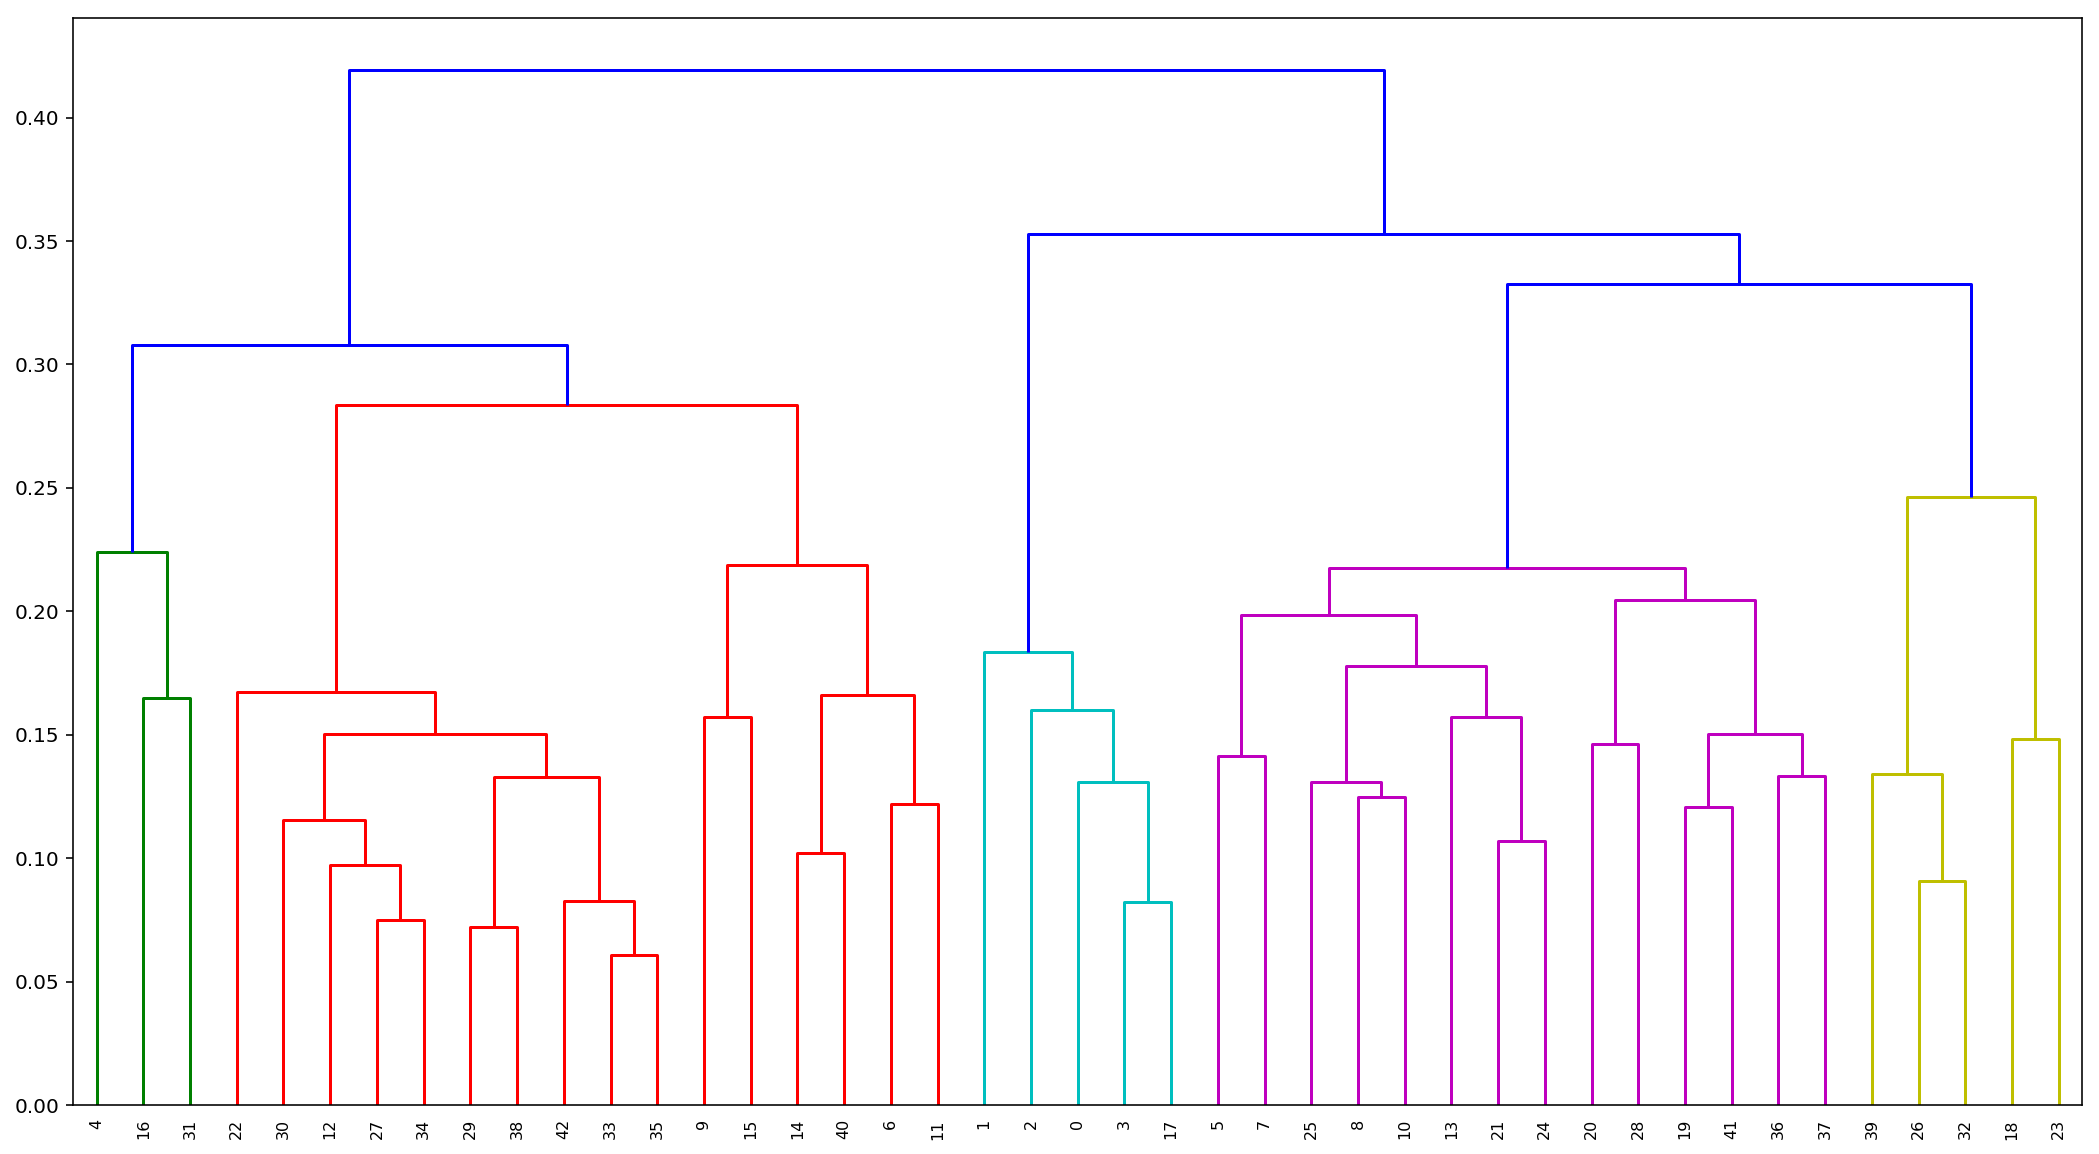

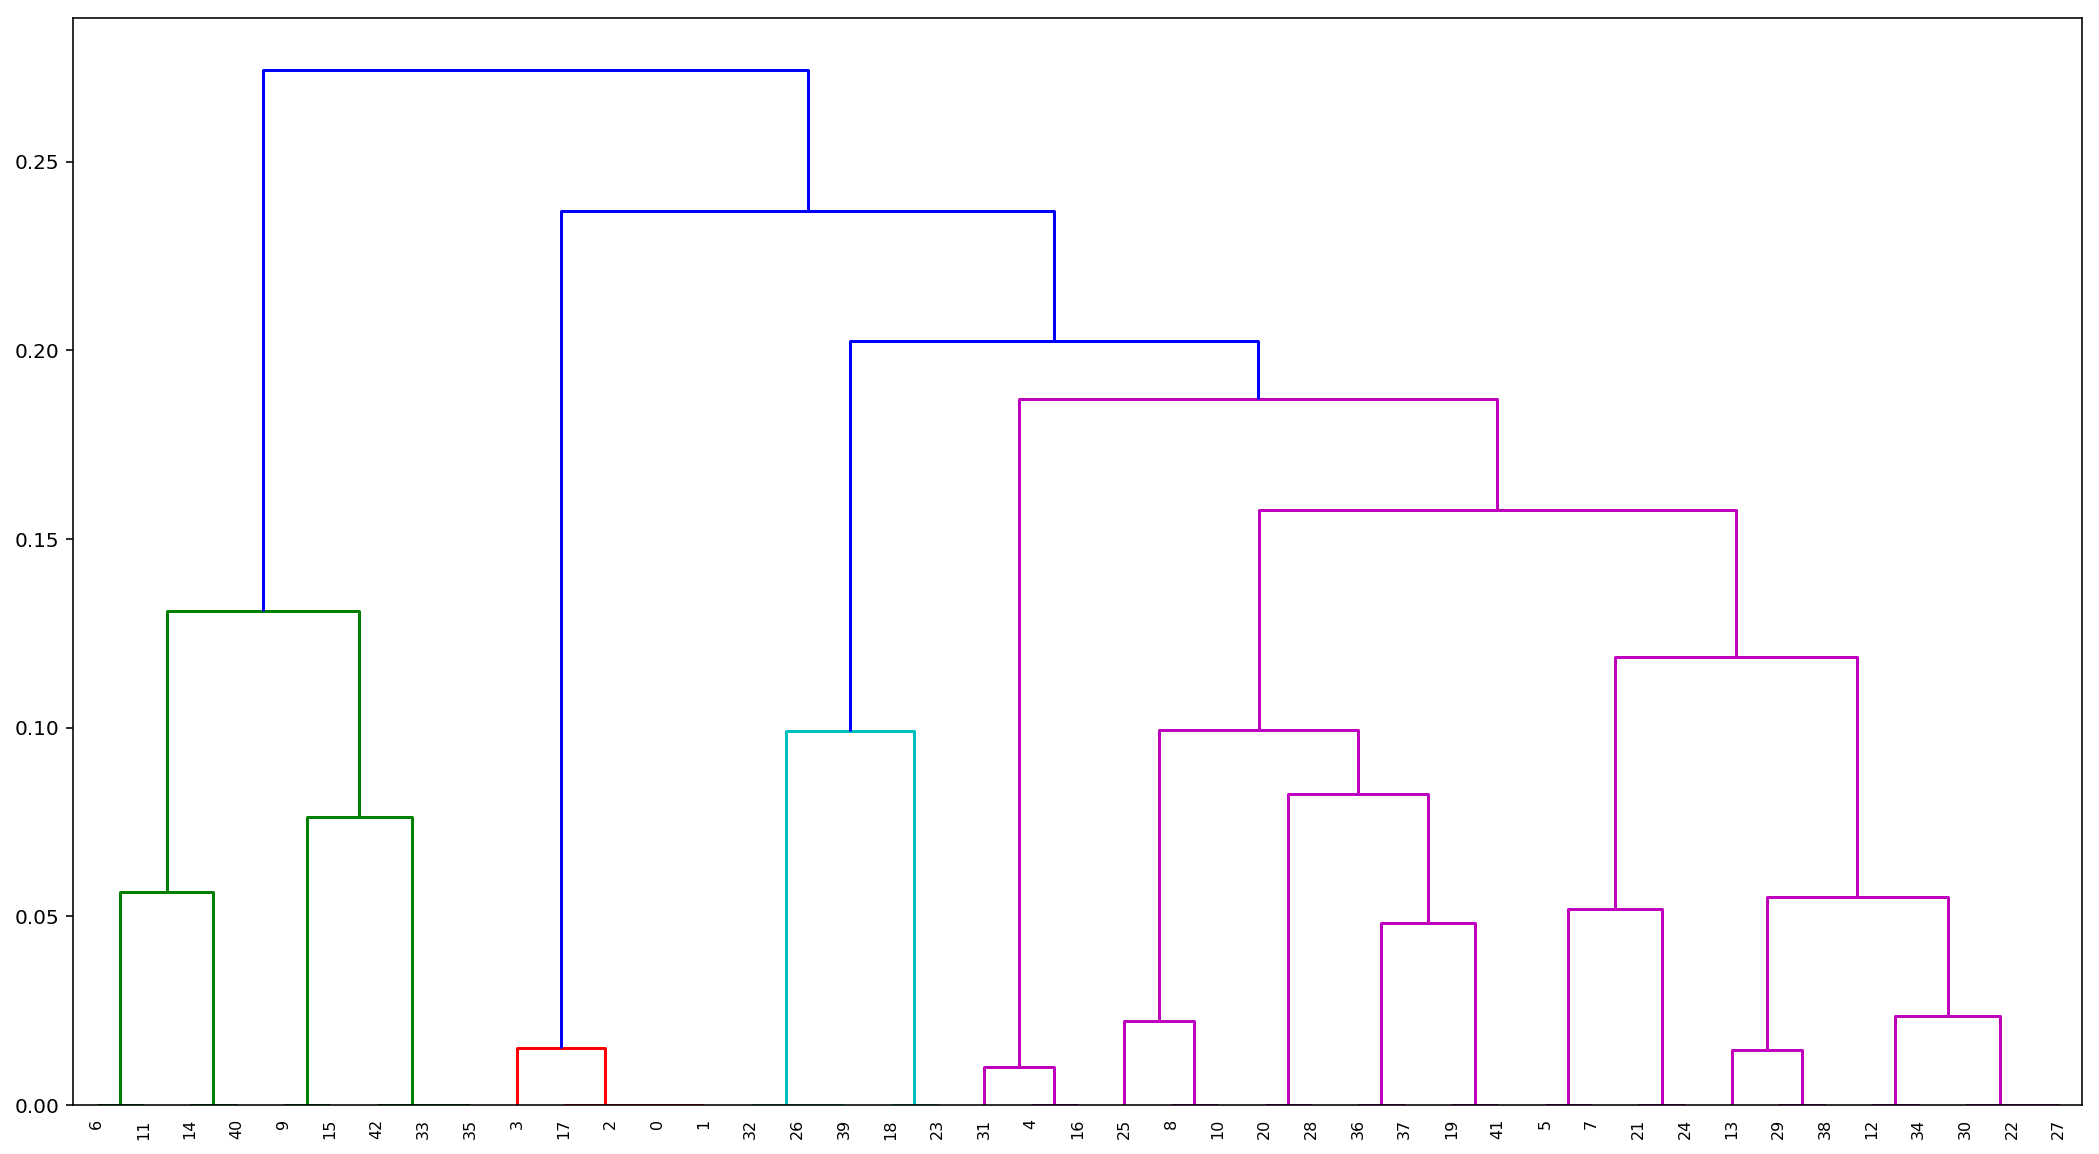

In [12]:
encode_bu(4677)

[I 190521 13:00:38 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a03b3c8>,), kwds={})
[D 190521 13:00:38 clustering:178] Starting row 0-27
[I 190521 13:00:39 utils:57] Finished distance matrix calculation


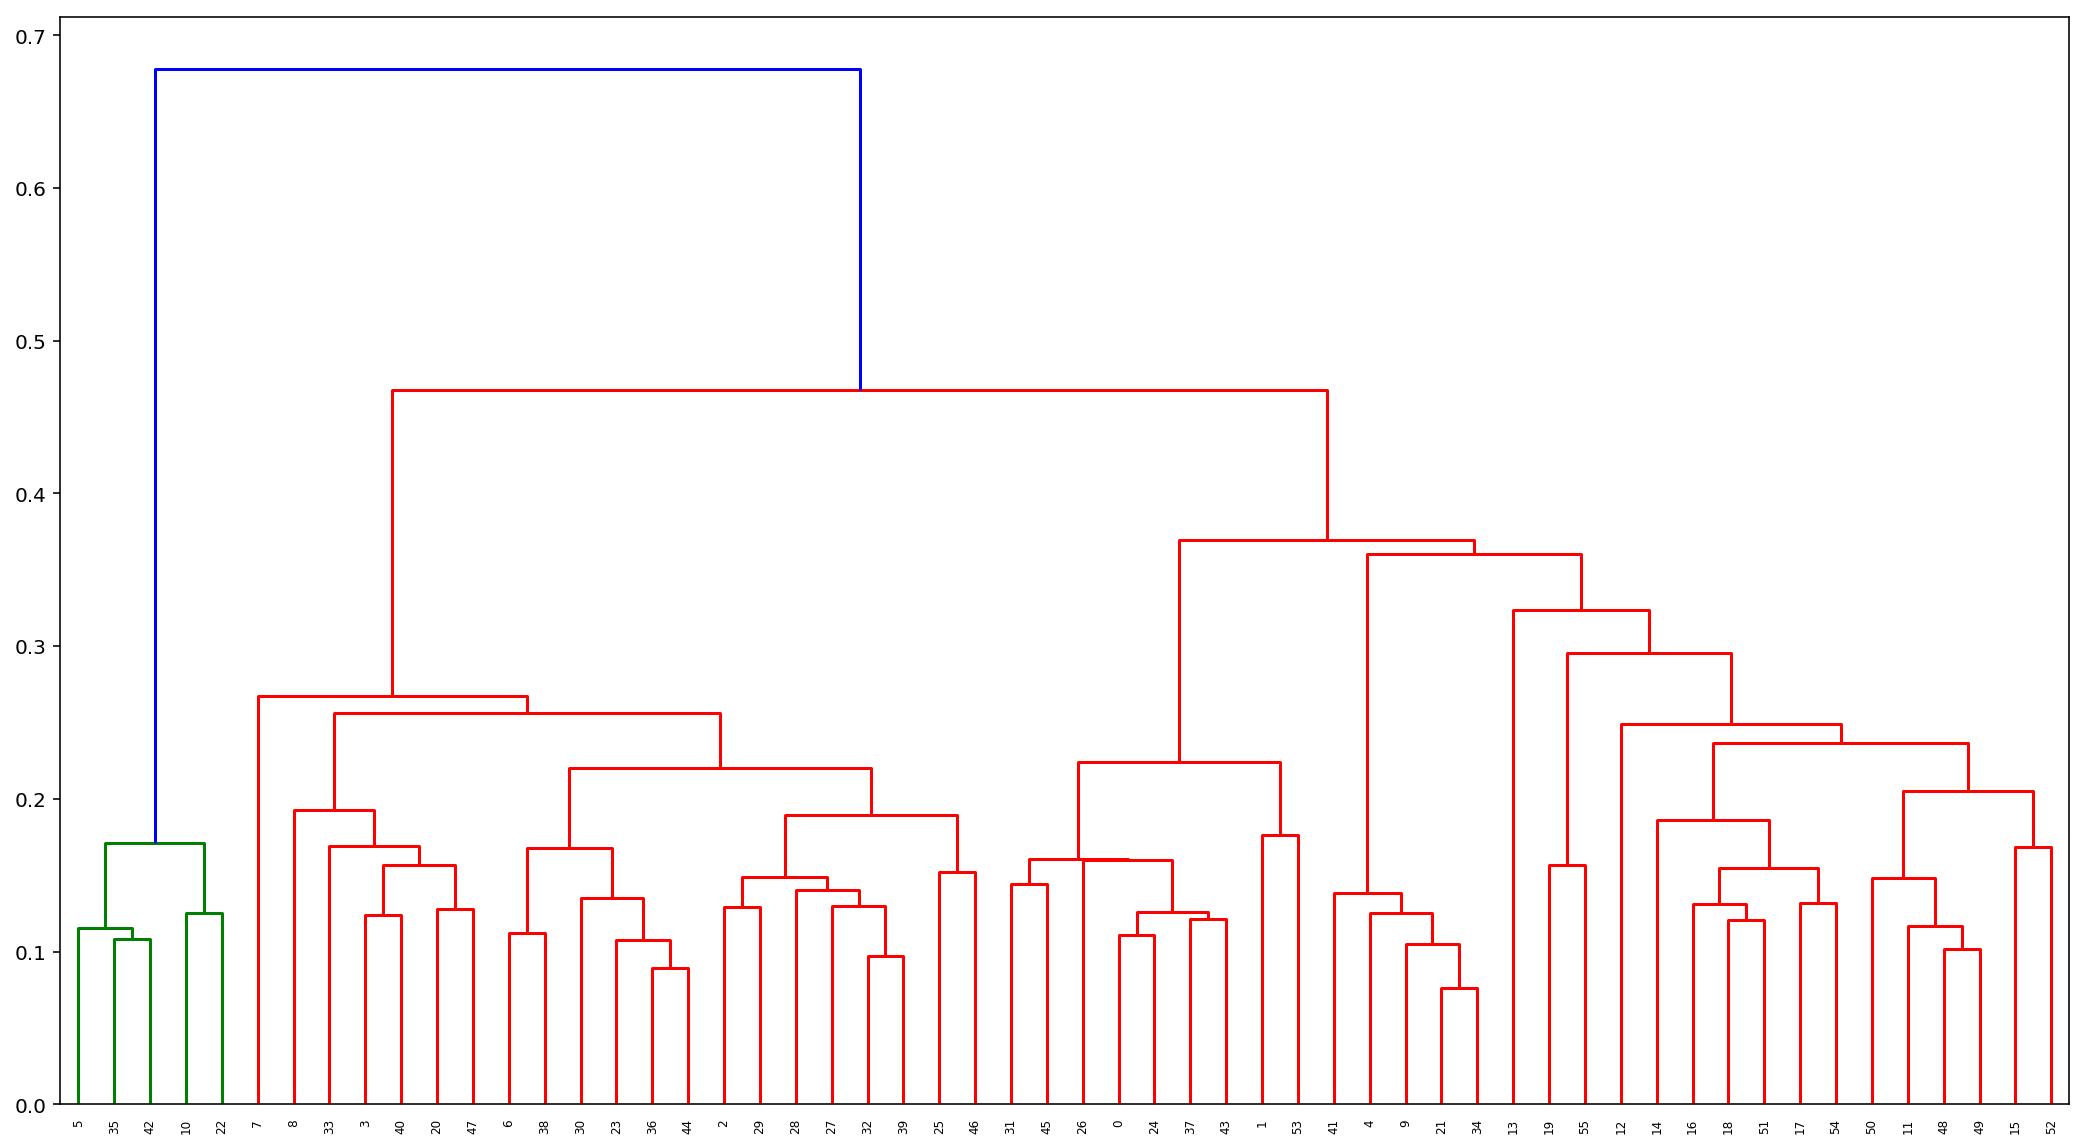

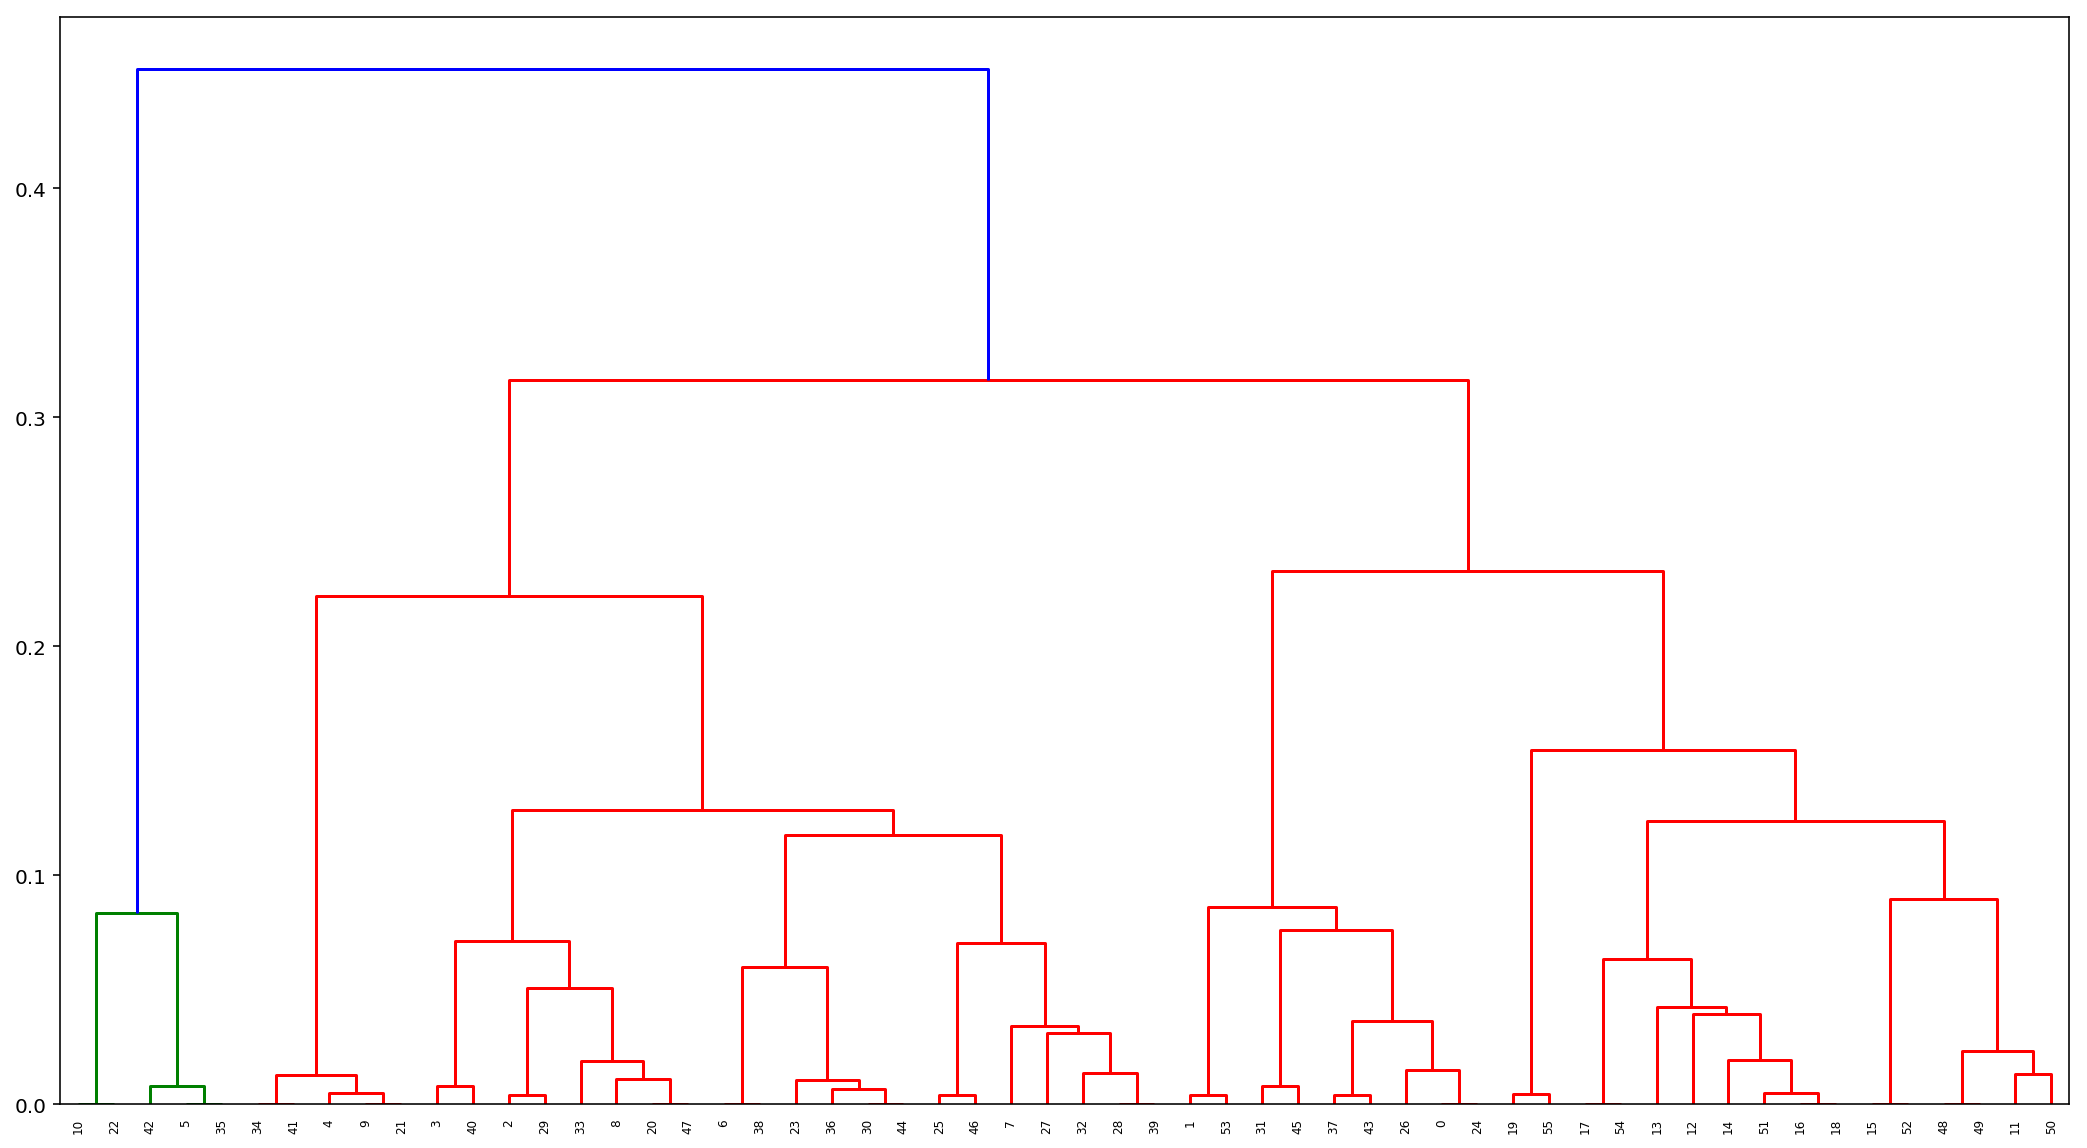

In [13]:
encode_bu(720)

[I 190521 13:03:26 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b31fac87a90>,), kwds={})
[D 190521 13:03:26 clustering:178] Starting row 0-26
[I 190521 13:03:26 utils:57] Finished distance matrix calculation


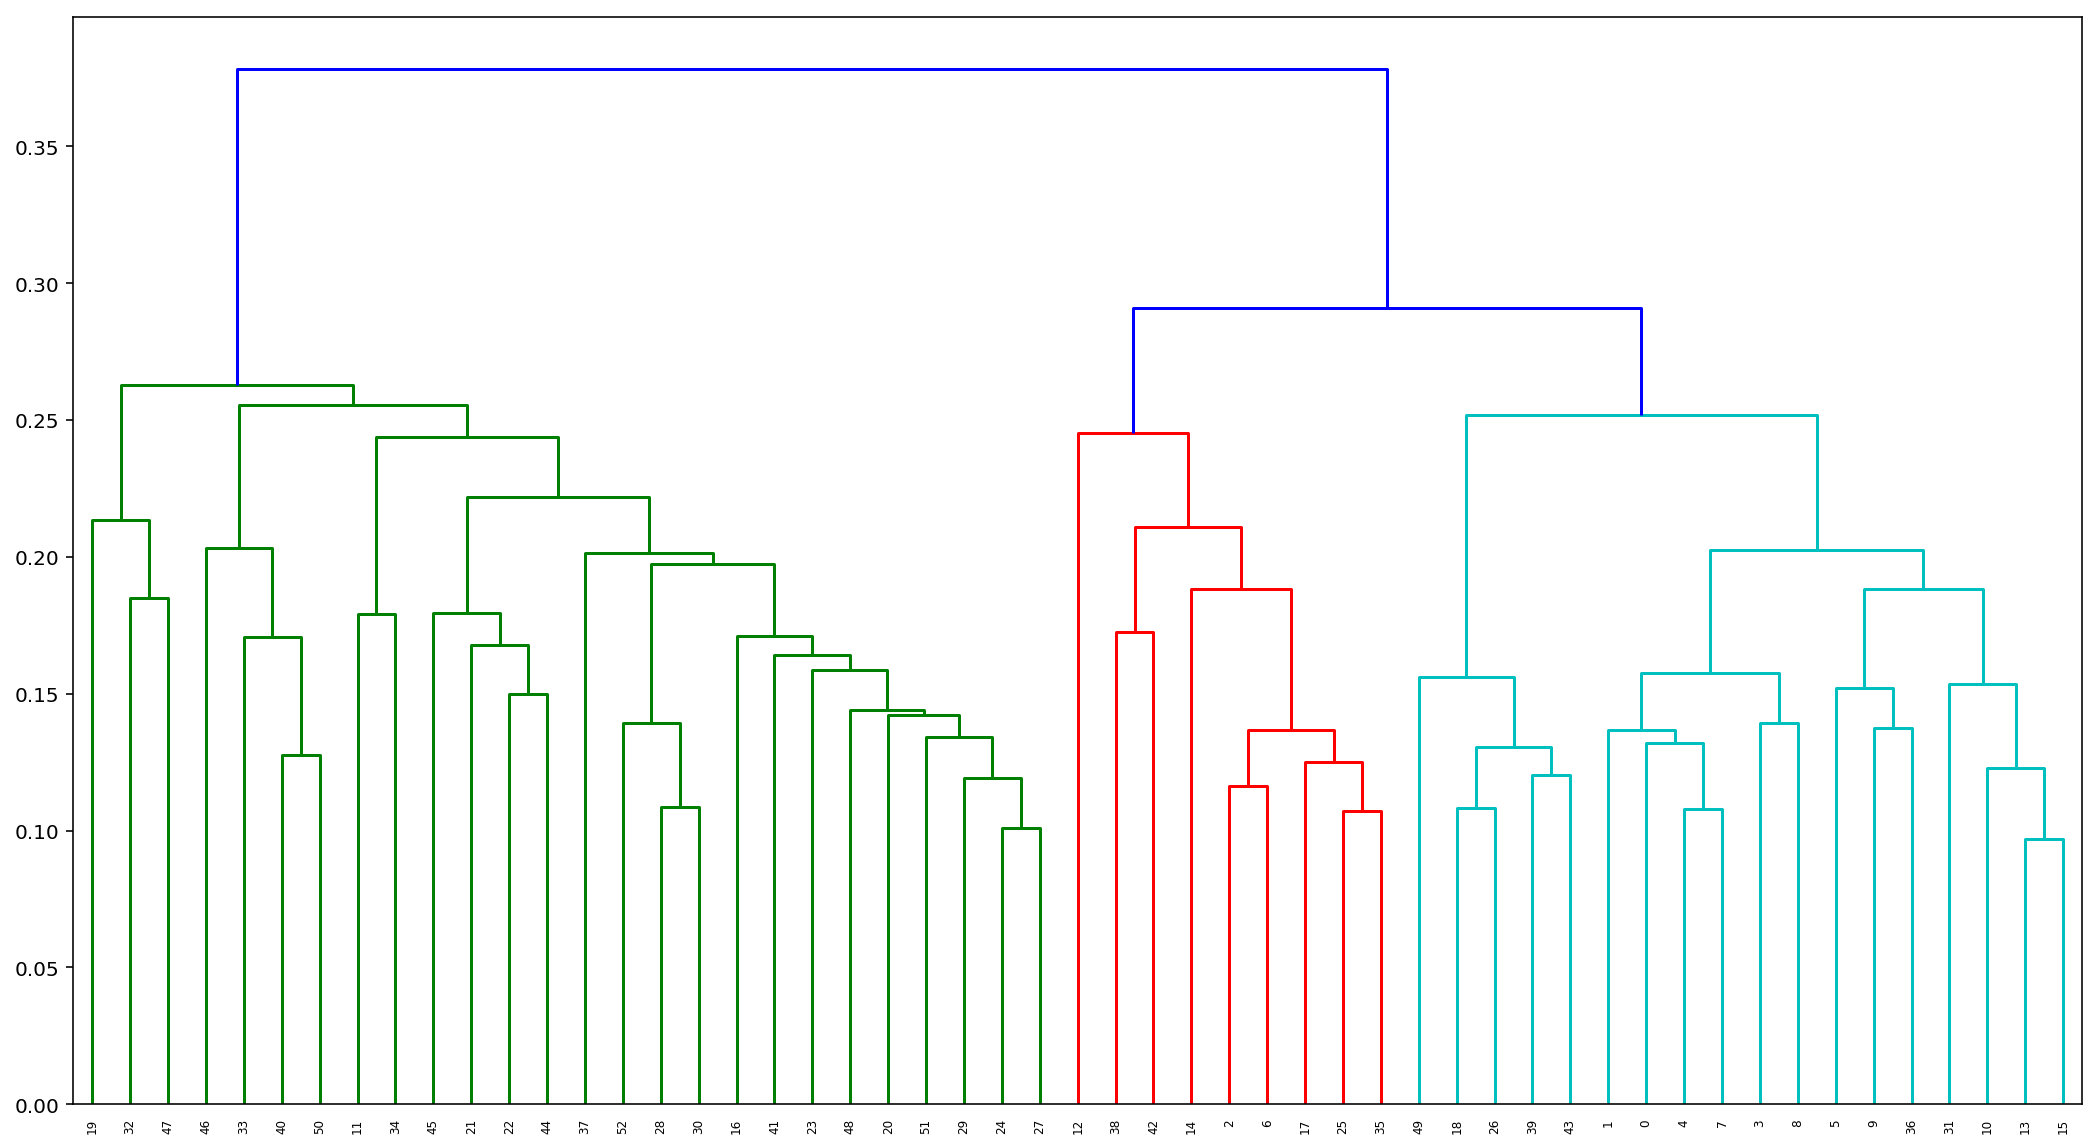

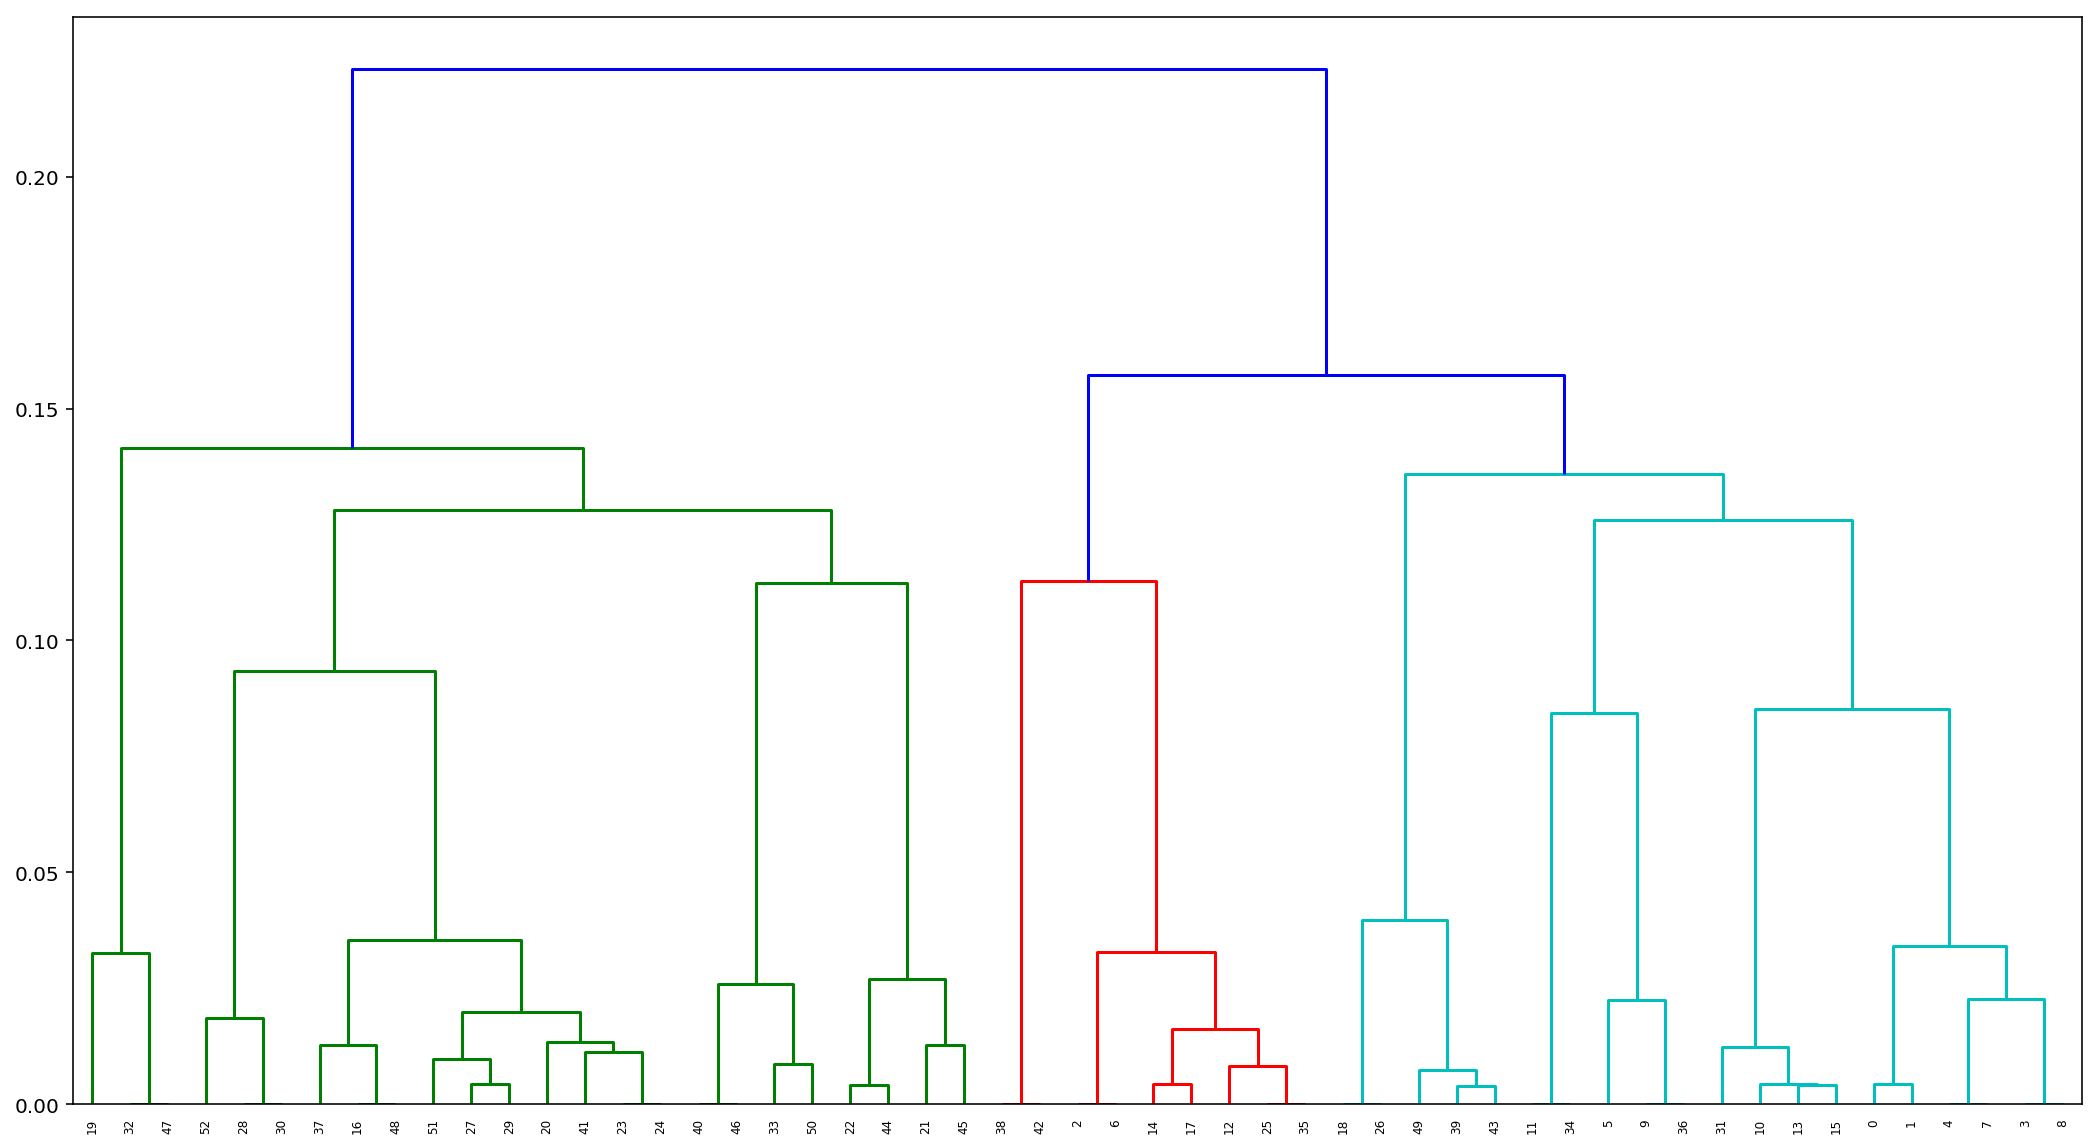

In [14]:
encode_bu(1380)

[I 190521 13:04:46 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320af7d6d8>,), kwds={})
[D 190521 13:04:46 clustering:178] Starting row 0-33
[I 190521 13:04:46 utils:57] Finished distance matrix calculation


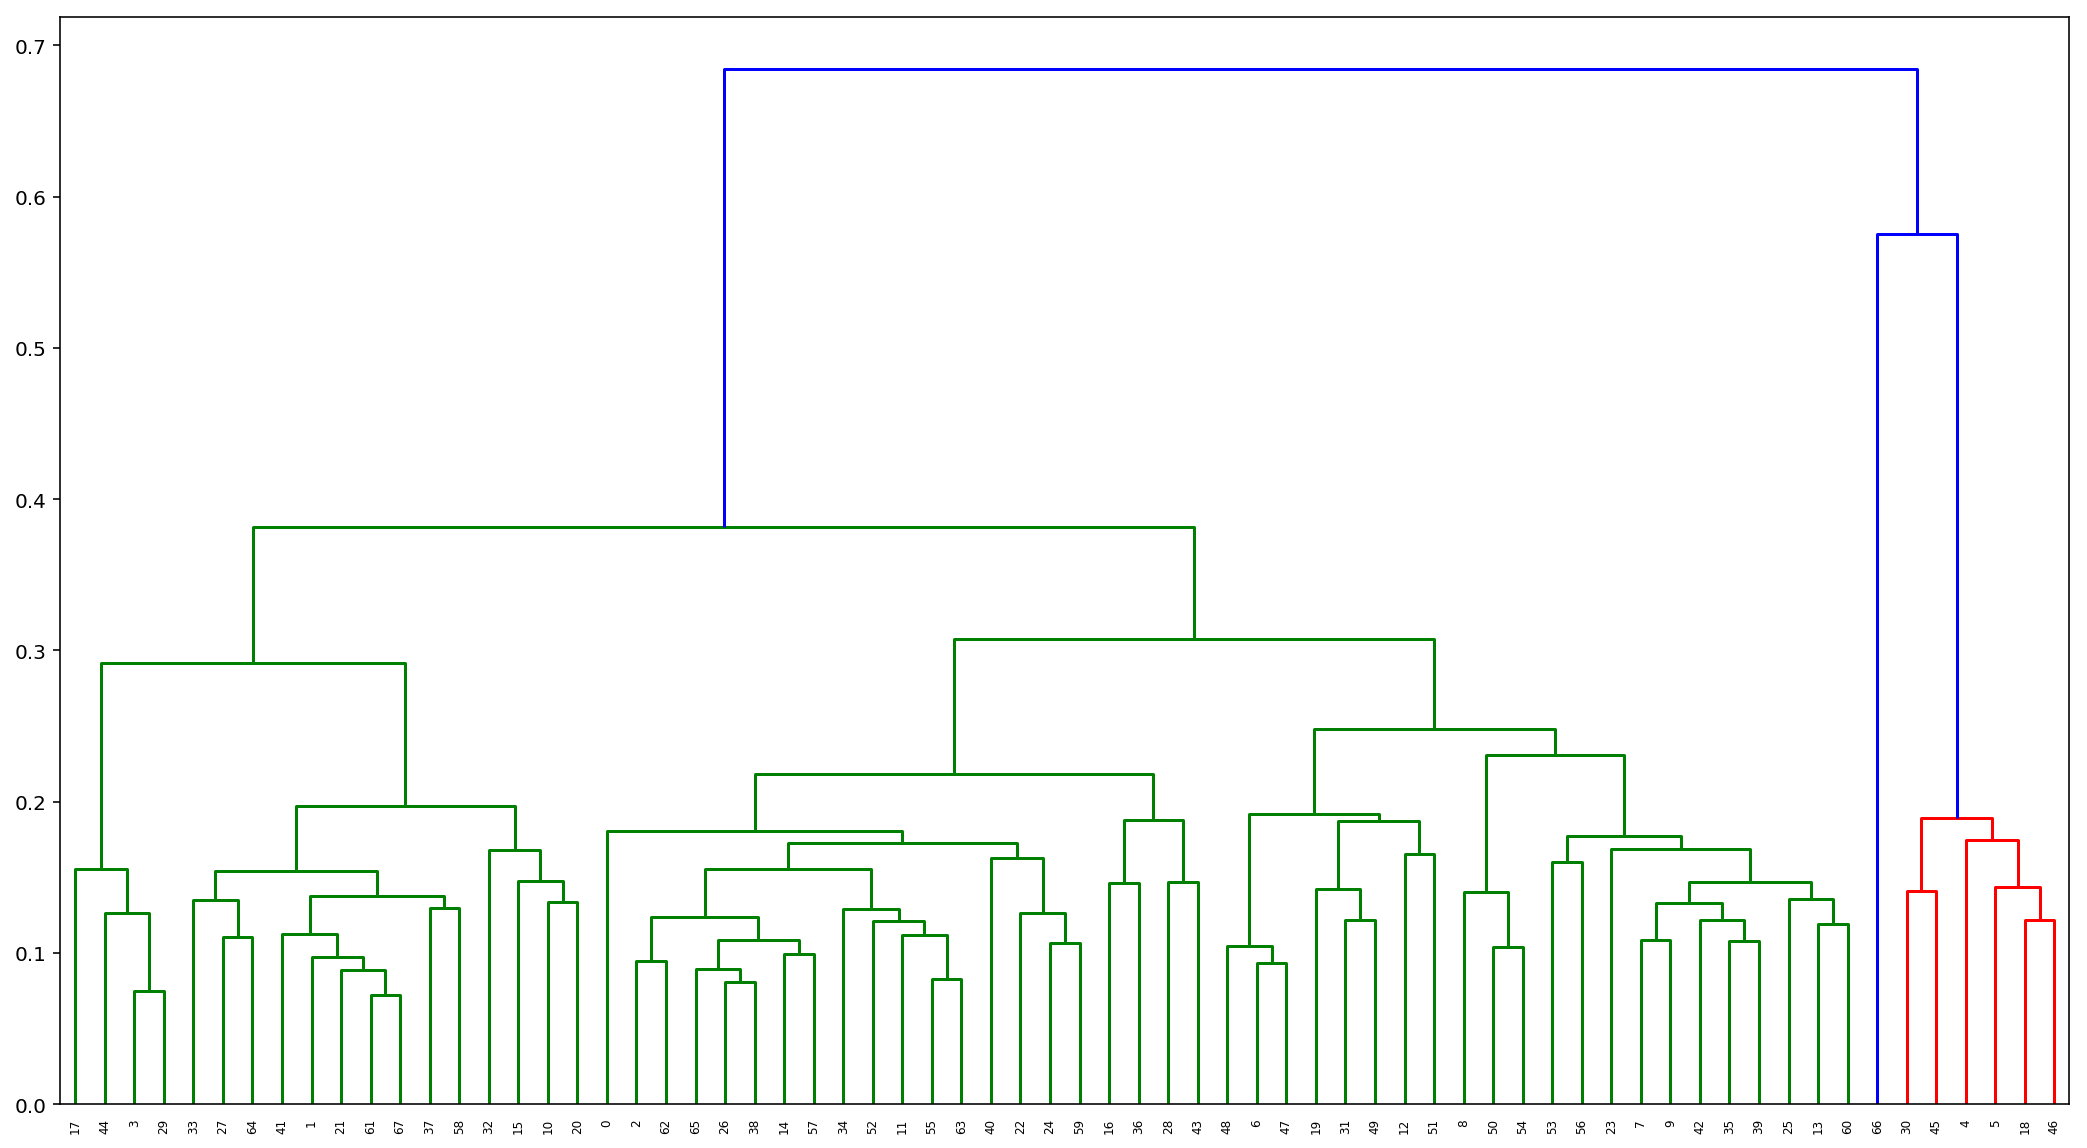

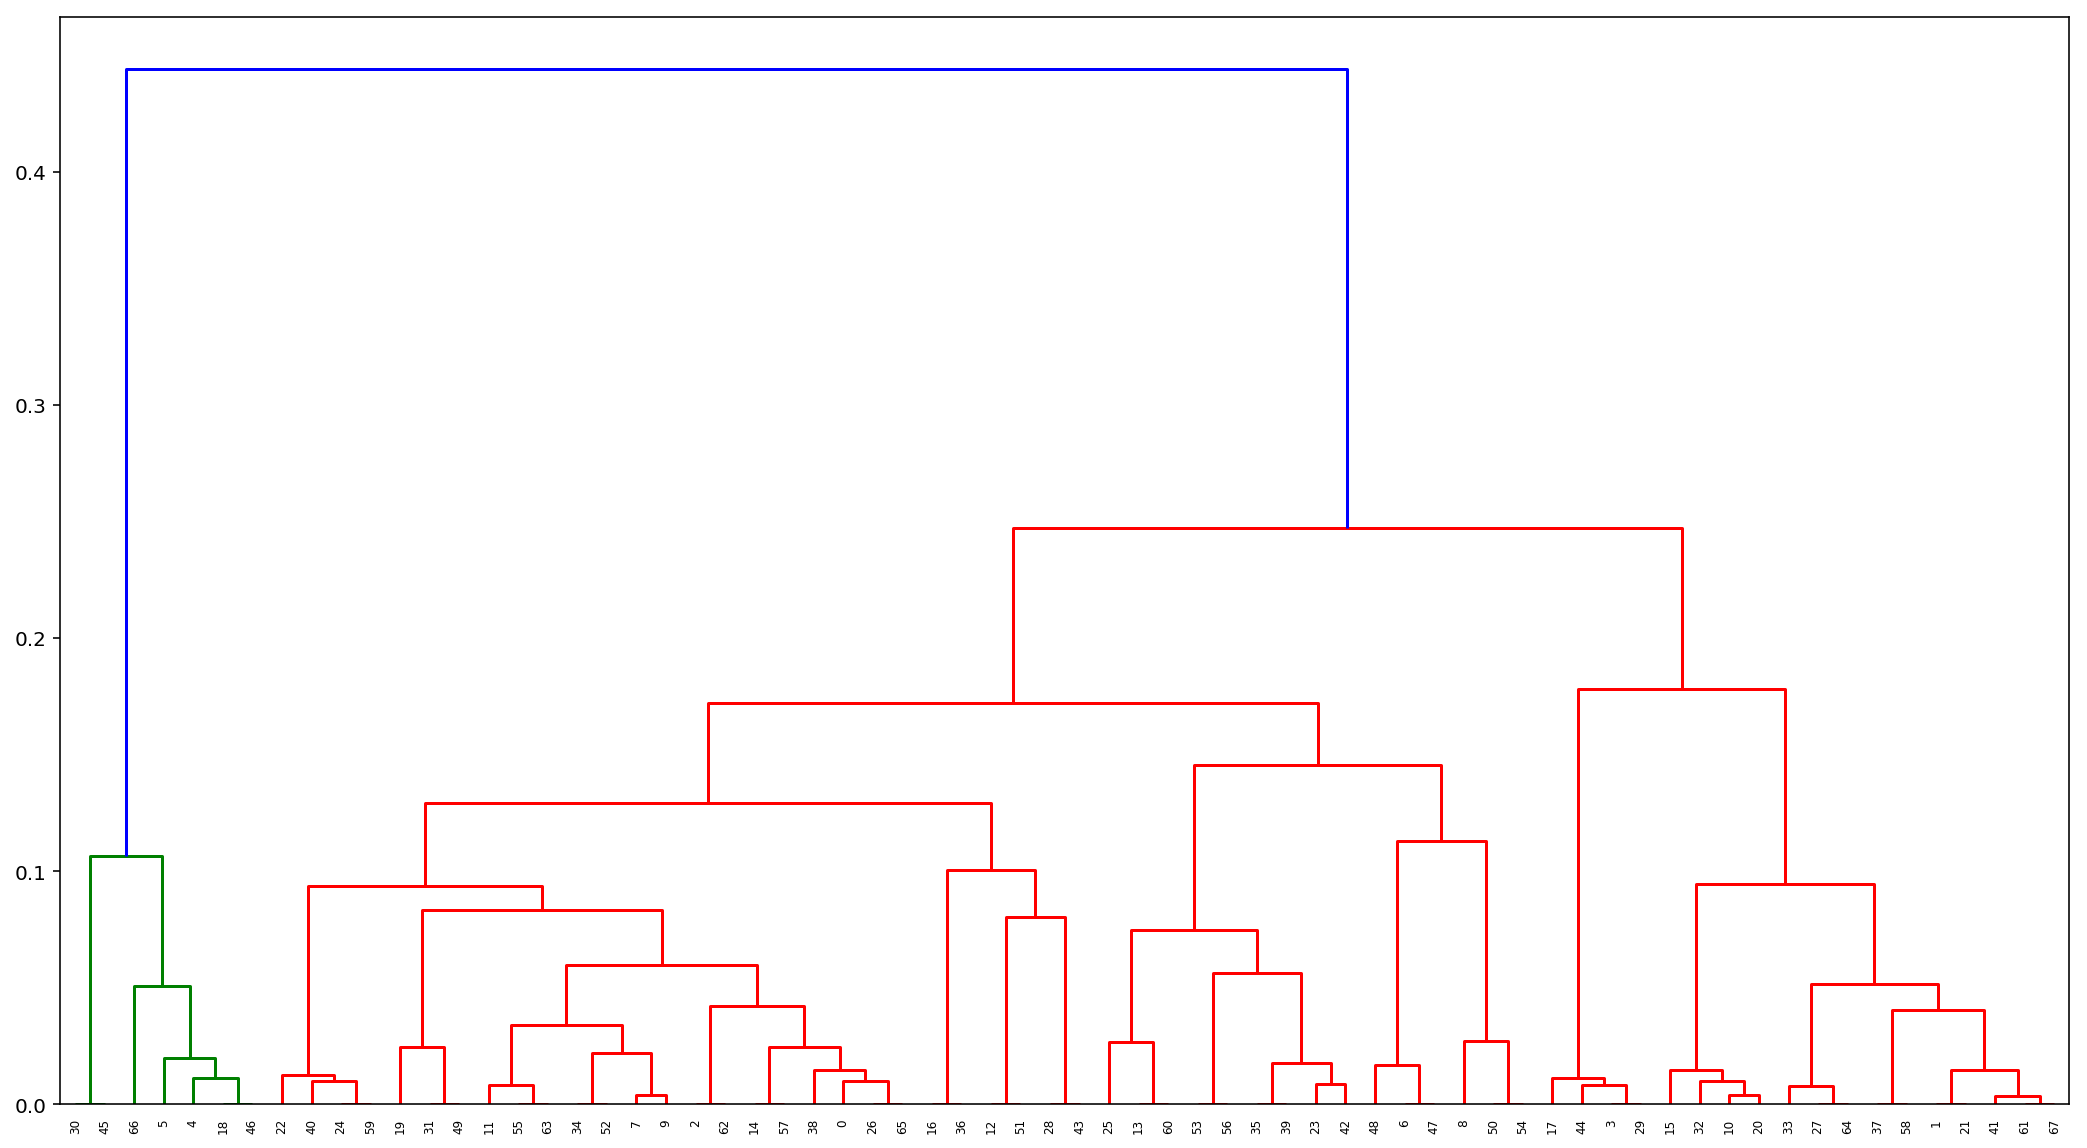

In [15]:
encode_bu(2193)

[I 190521 11:03:00 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58da866d8>,), kwds={})
[D 190521 11:03:00 clustering:178] Starting row 0-32
[I 190521 11:03:00 utils:57] Finished distance matrix calculation


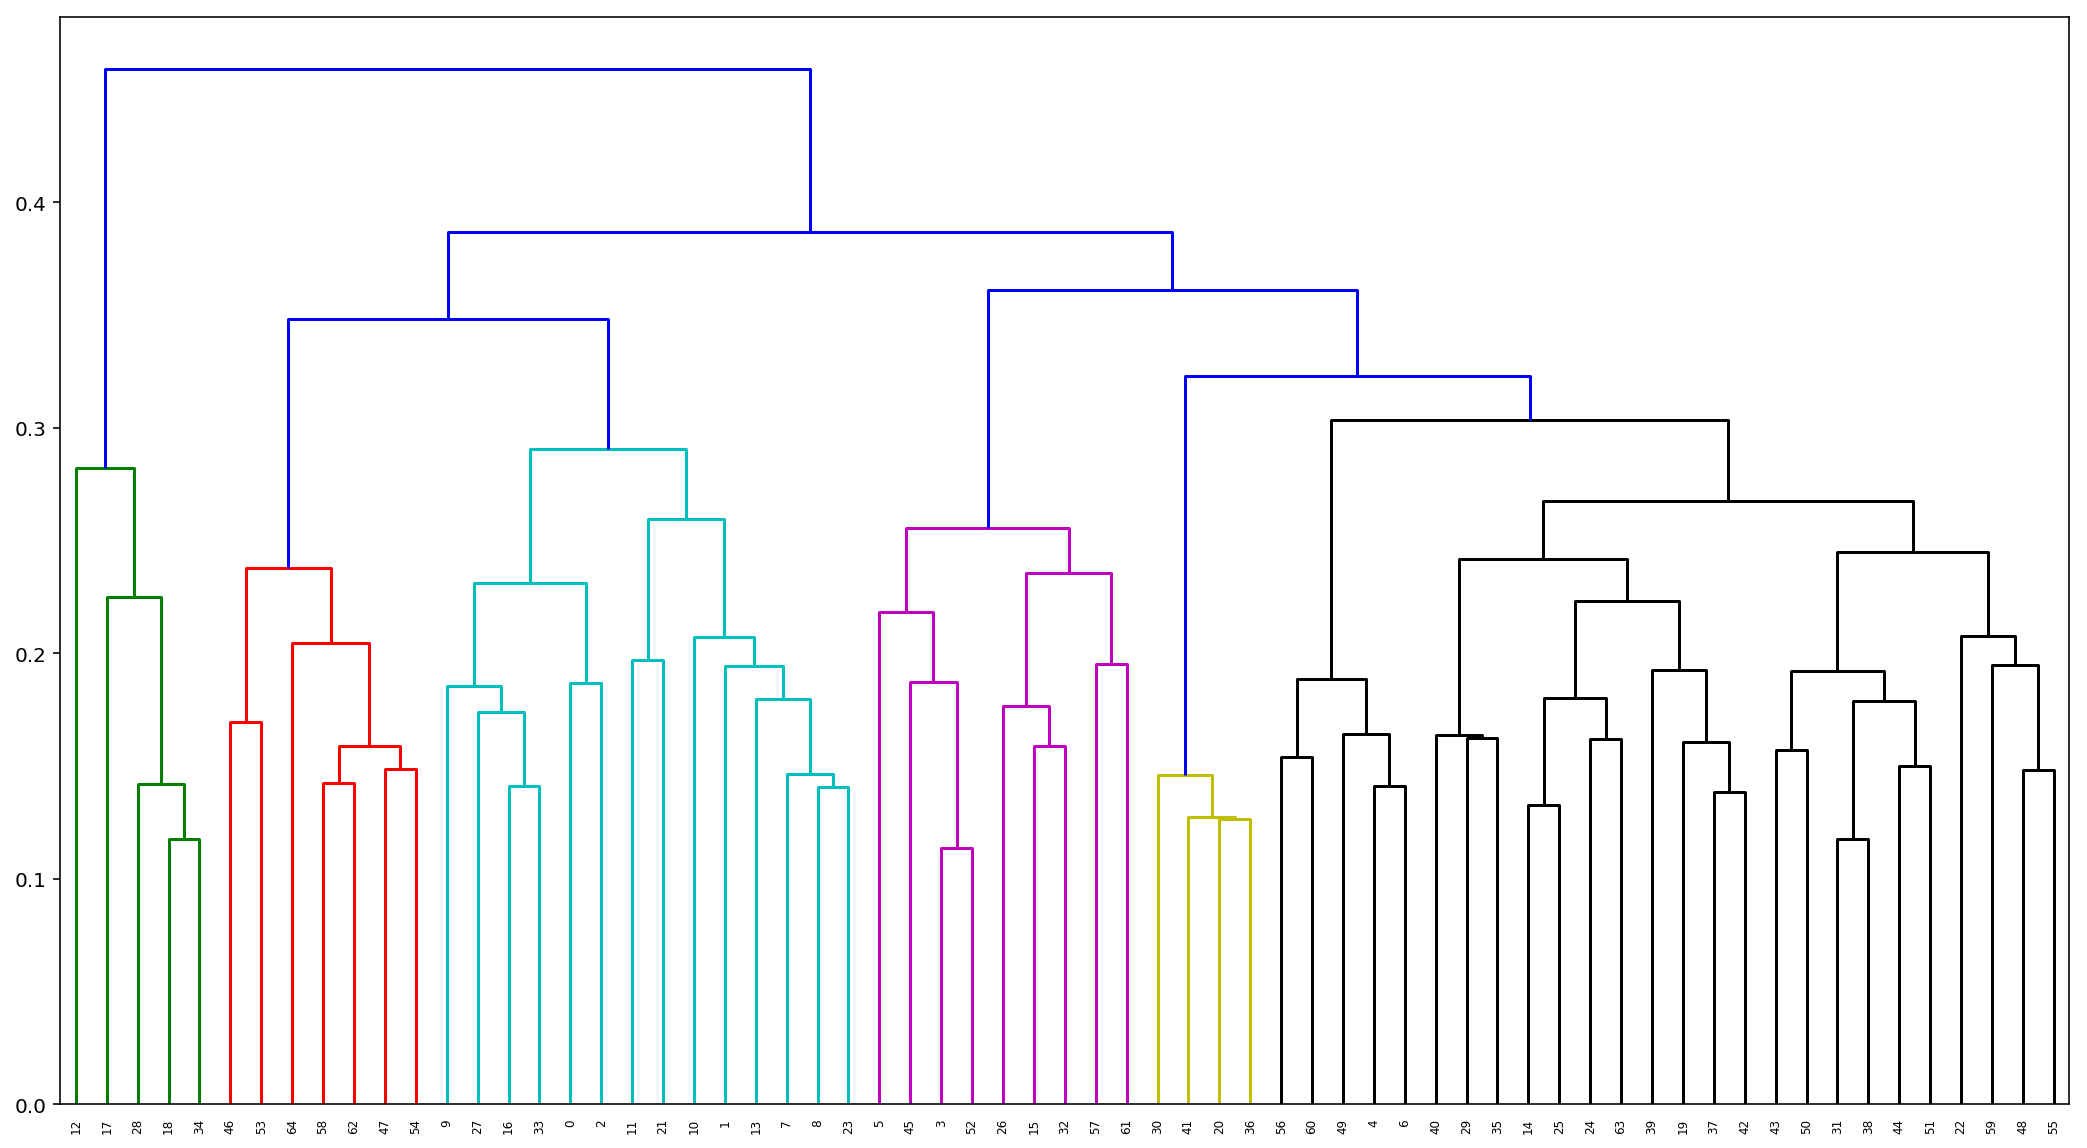

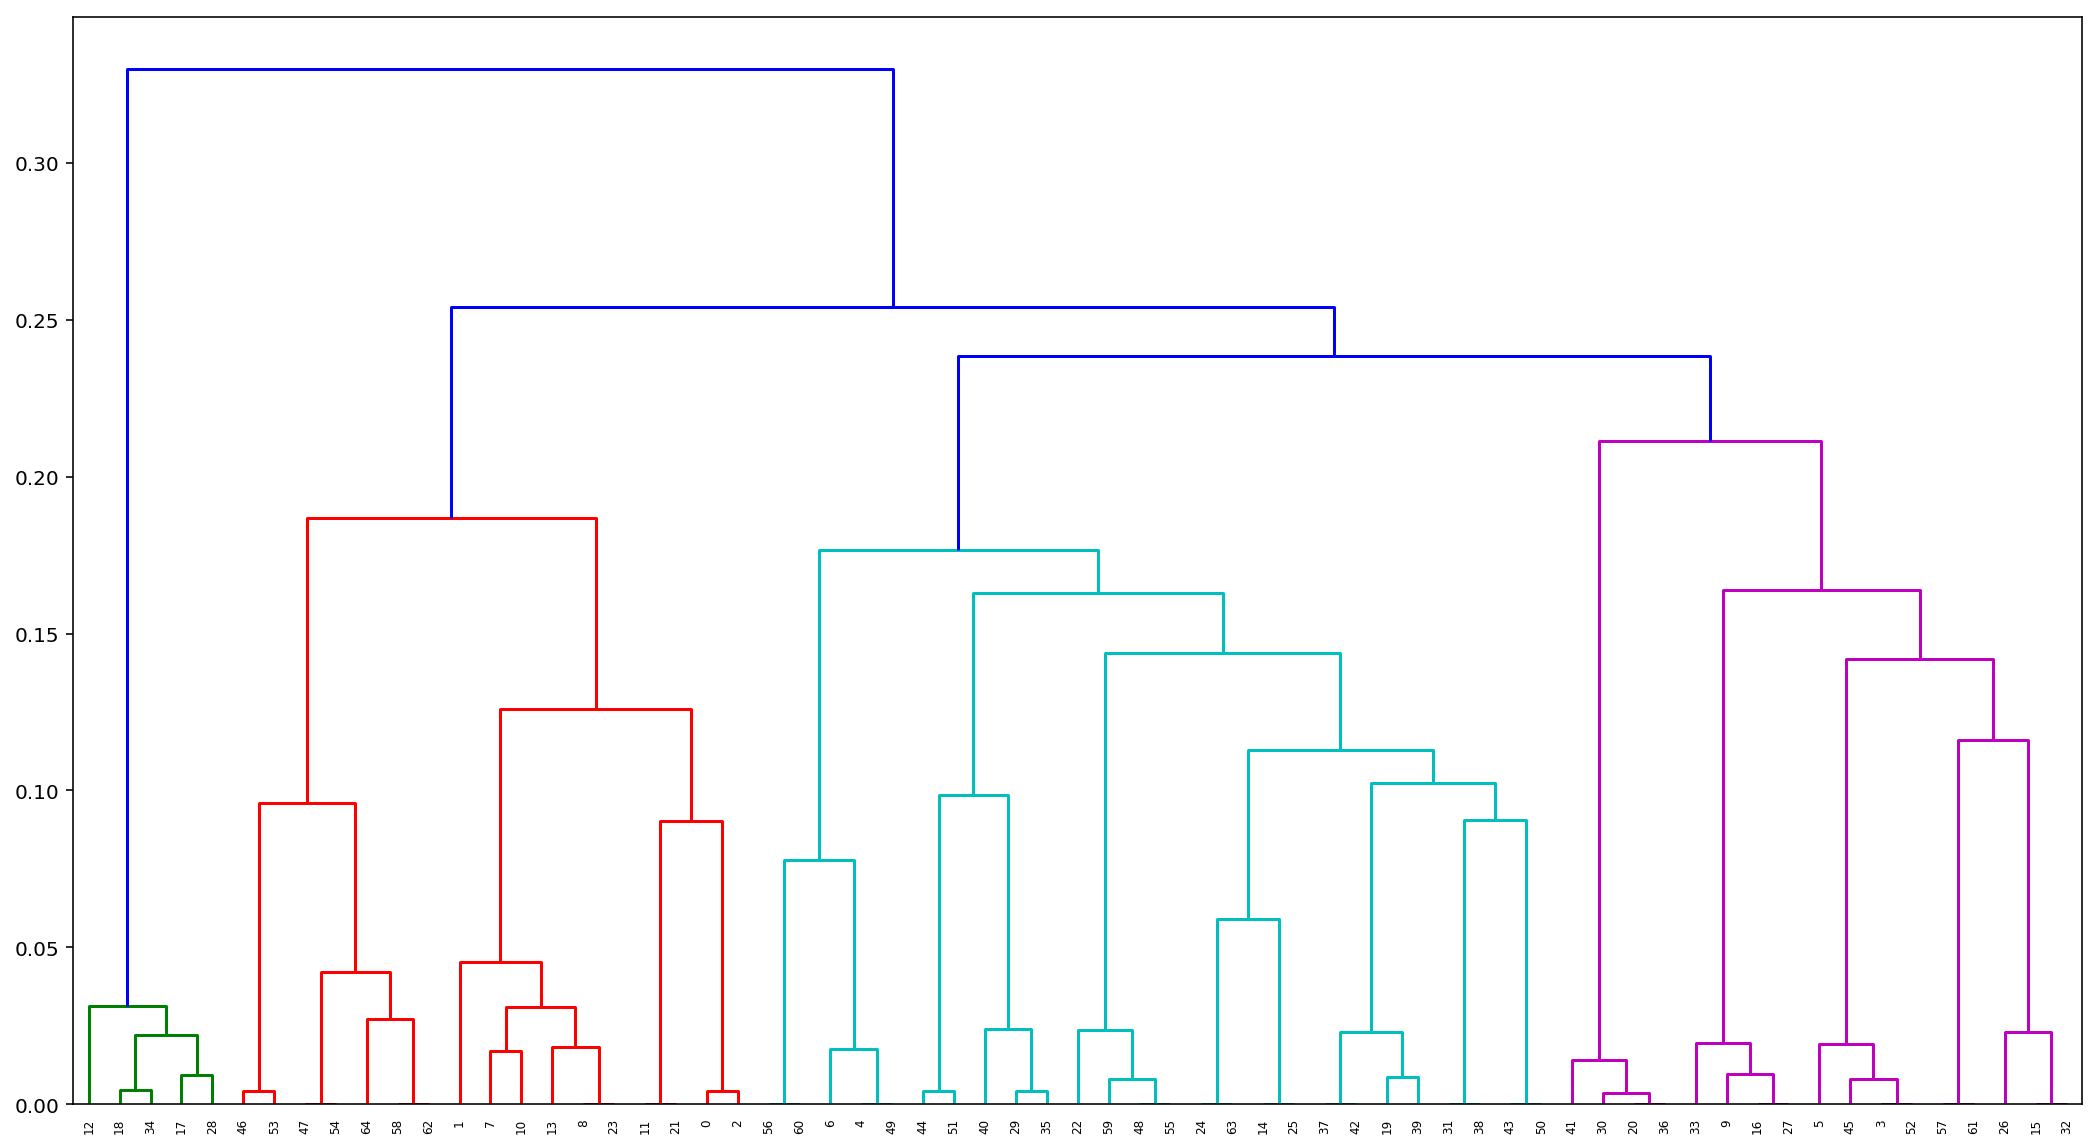

In [684]:
encode_bu(3219)

[I 190521 14:12:55 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320acc83c8>,), kwds={})
[D 190521 14:12:55 clustering:178] Starting row 0-32
[I 190521 14:12:55 utils:57] Finished distance matrix calculation


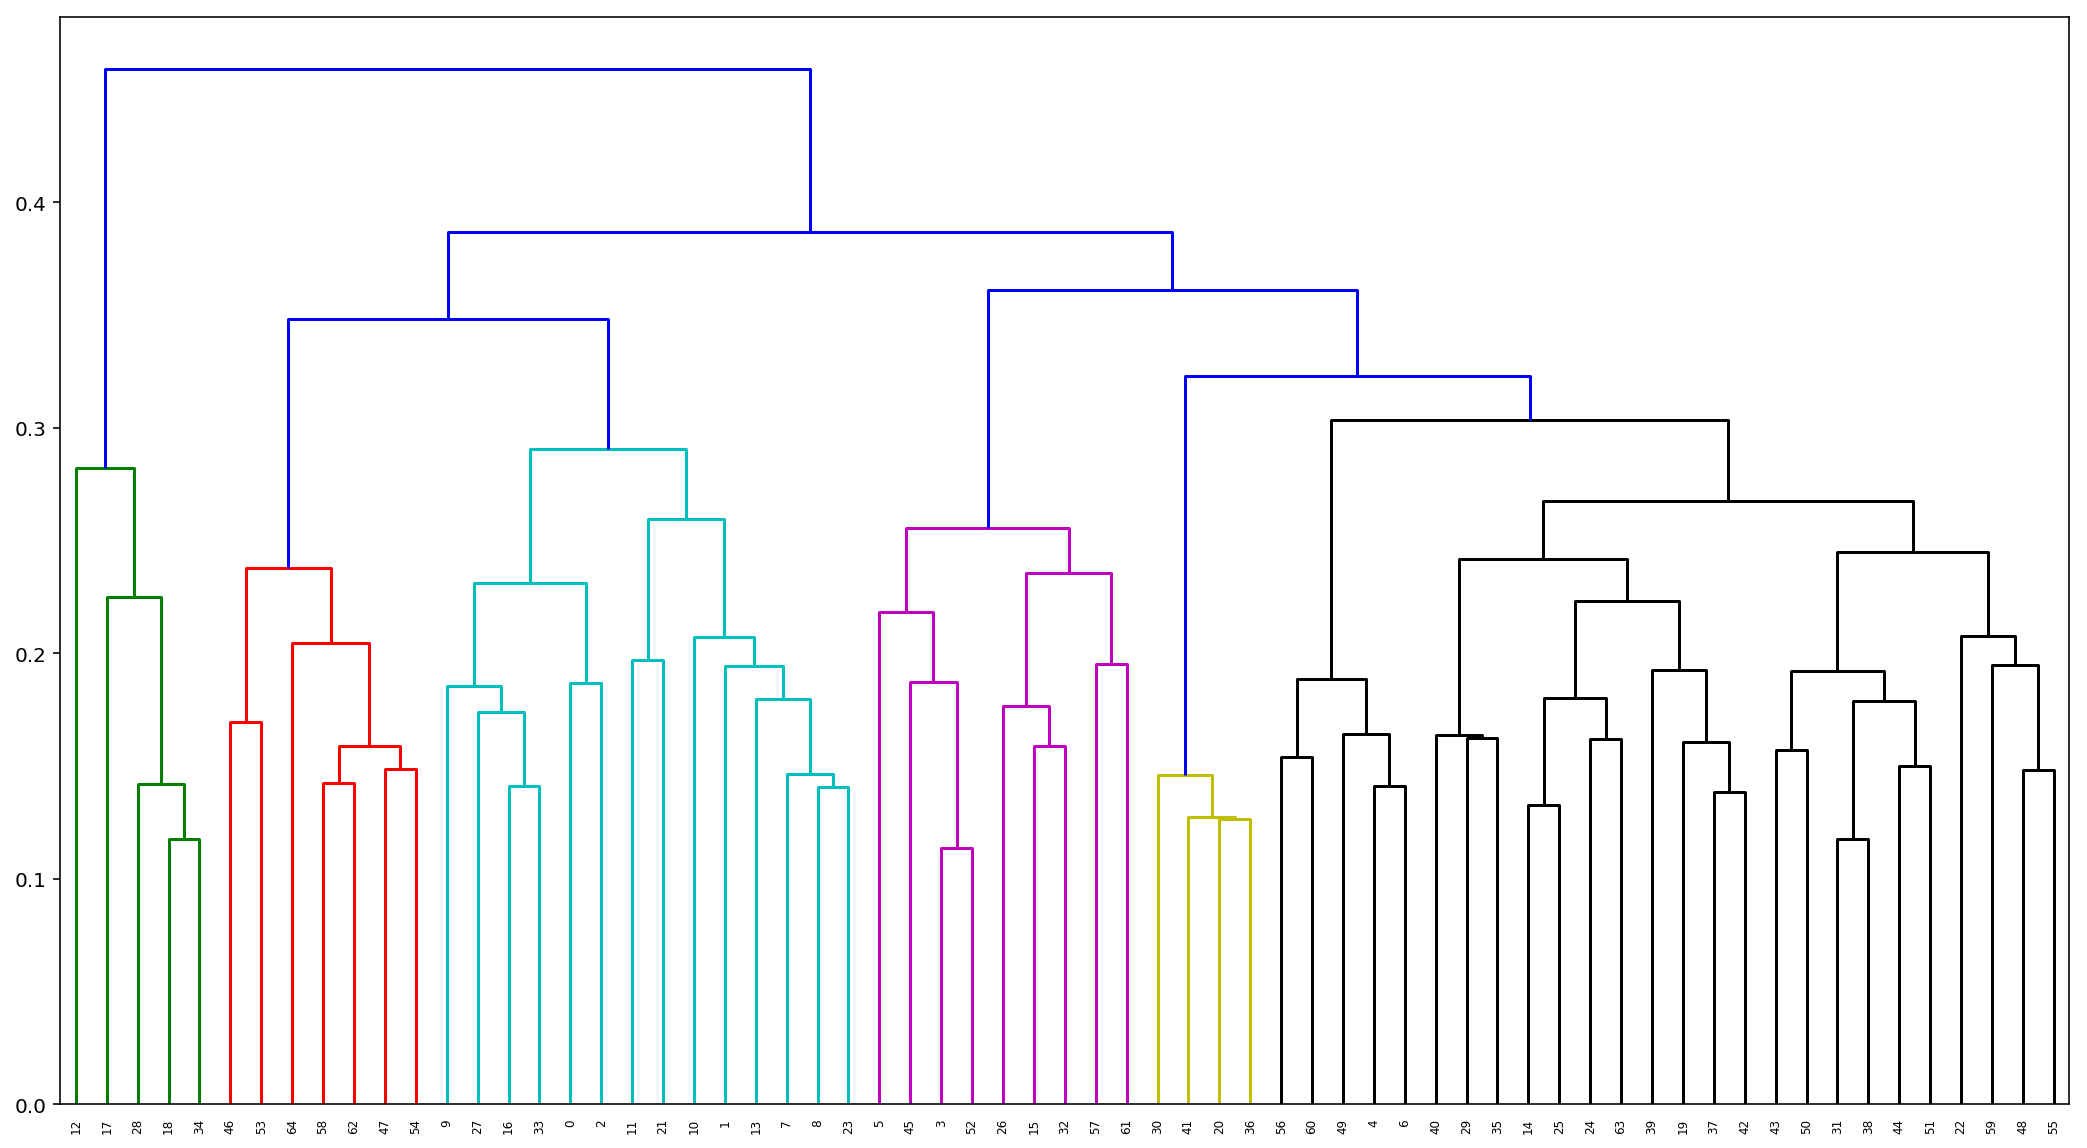

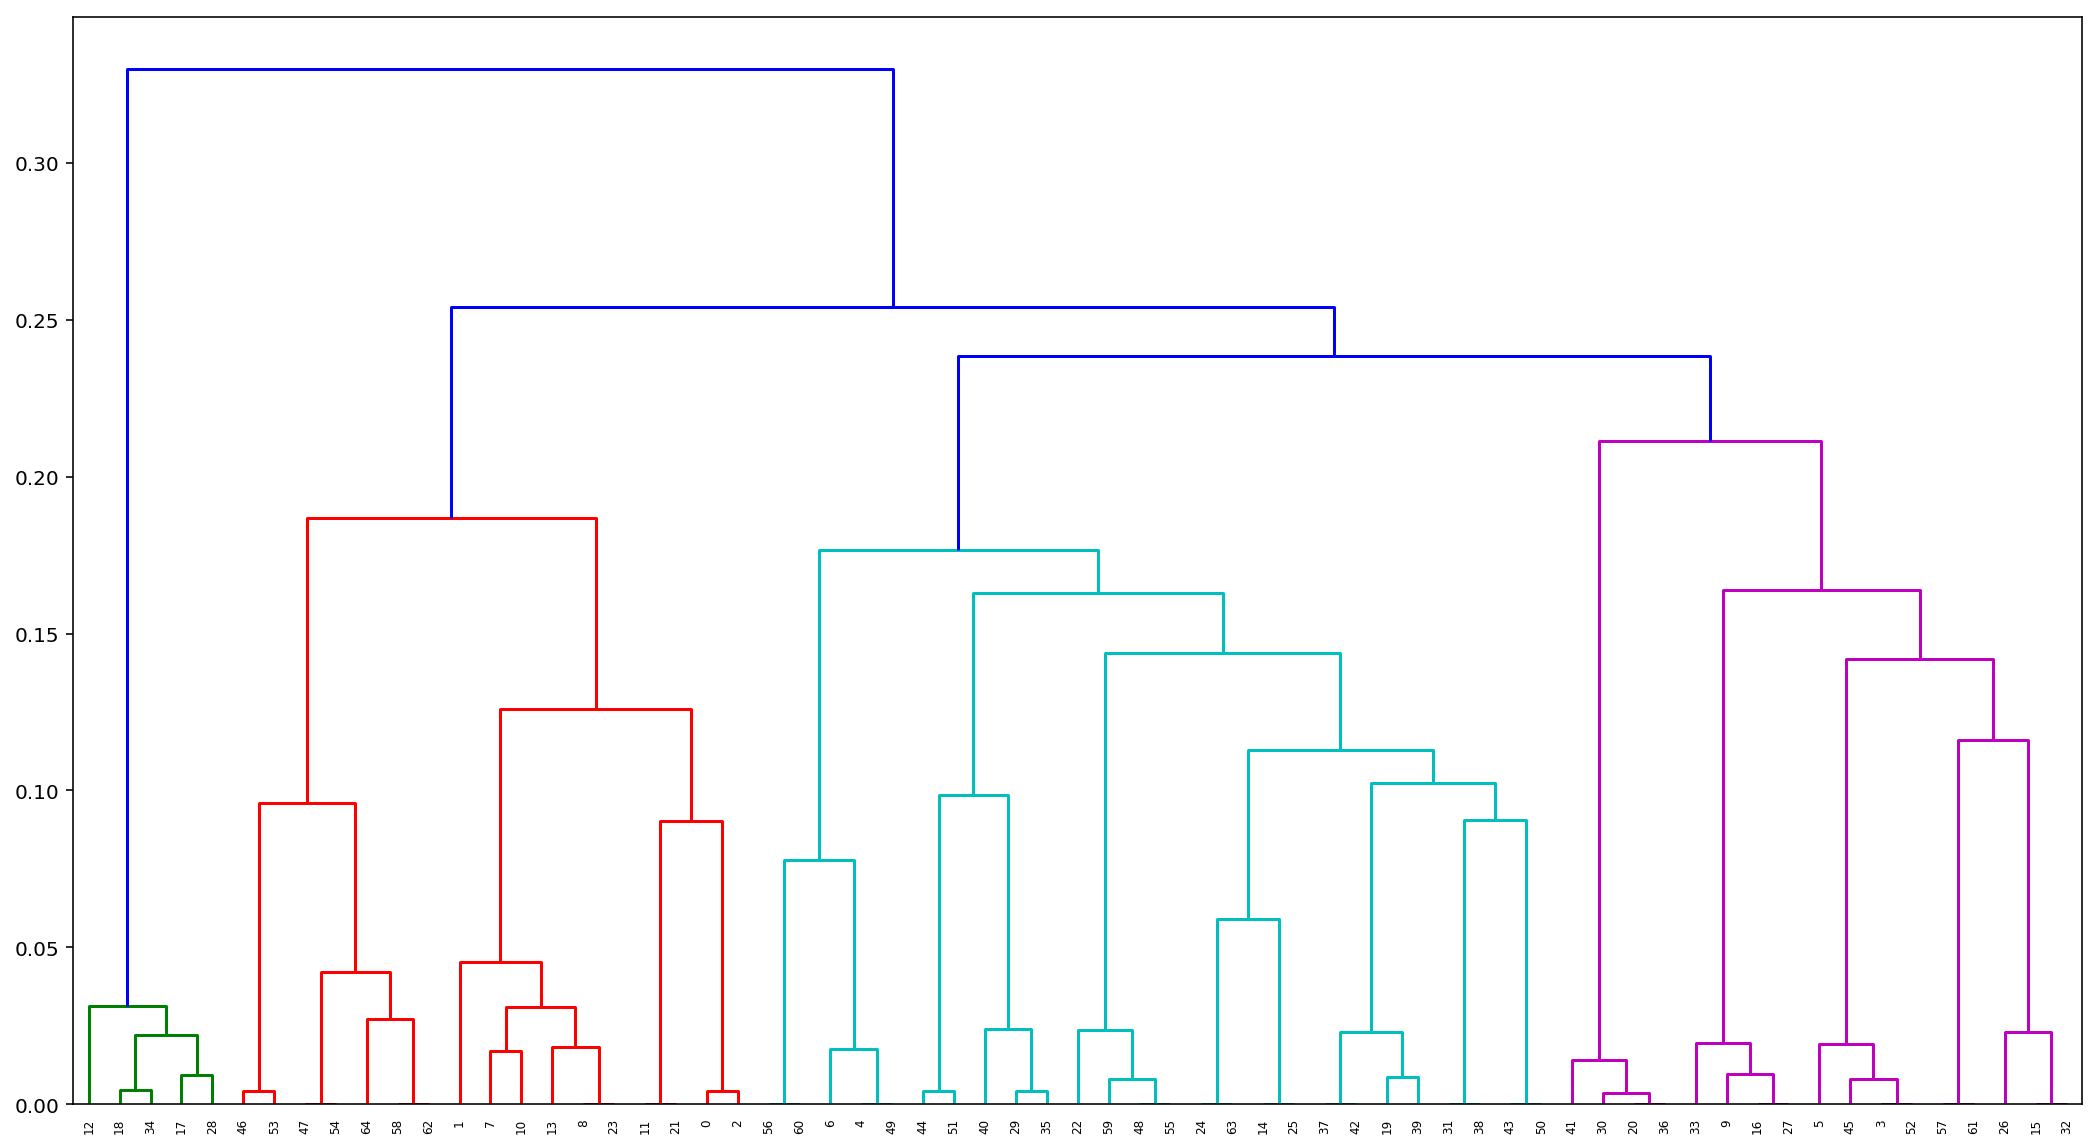

In [16]:
encode_bu(3219)

[I 190521 14:30:51 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320b4386d8>,), kwds={})
[D 190521 14:30:51 clustering:178] Starting row 0-16
[I 190521 14:30:51 utils:57] Finished distance matrix calculation


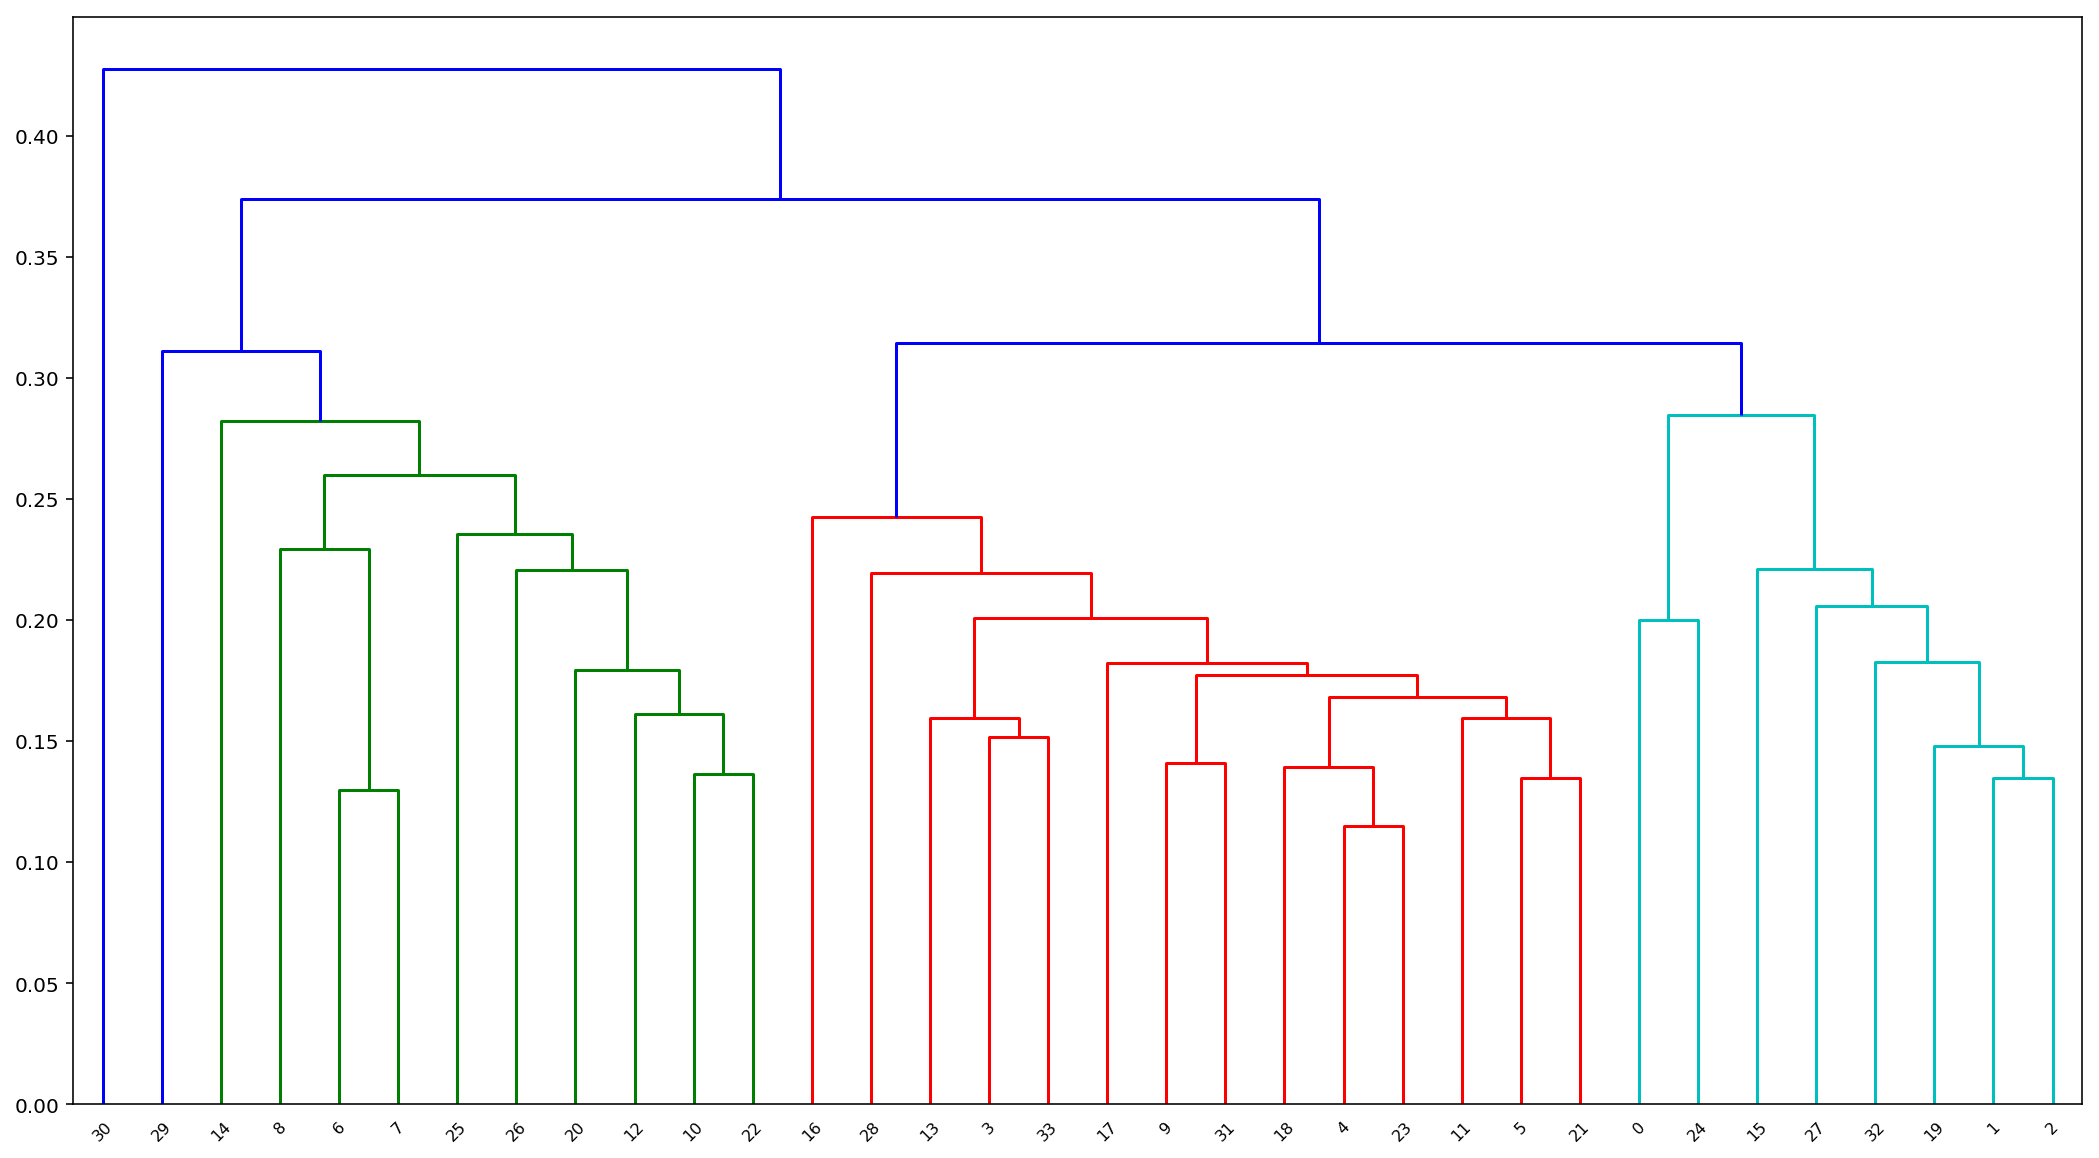

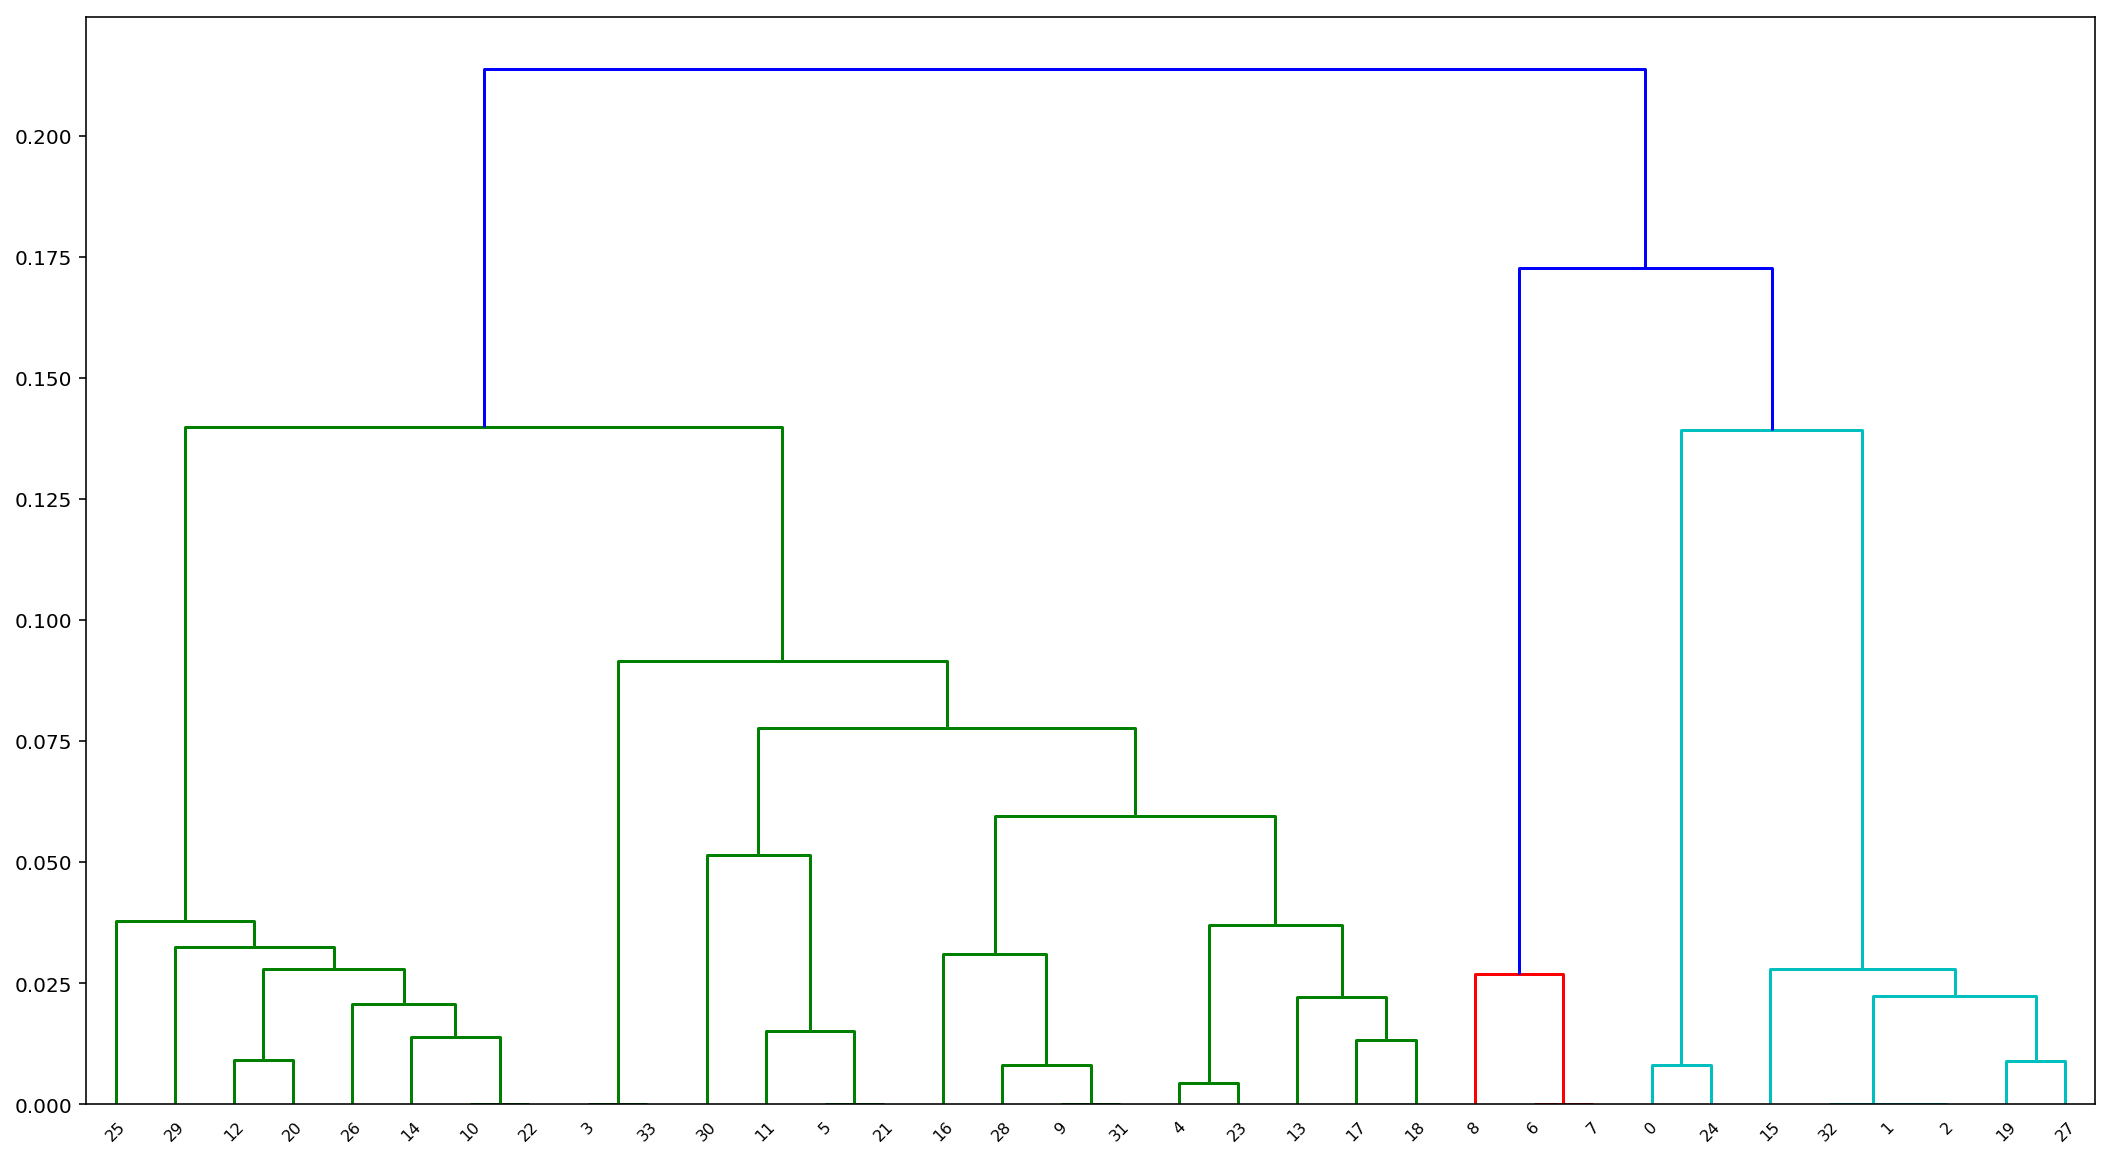

In [17]:
encode_bu(3360)

[I 190521 14:32:21 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a12a400>,), kwds={})
[D 190521 14:32:21 clustering:178] Starting row 0-28
[I 190521 14:32:22 utils:57] Finished distance matrix calculation


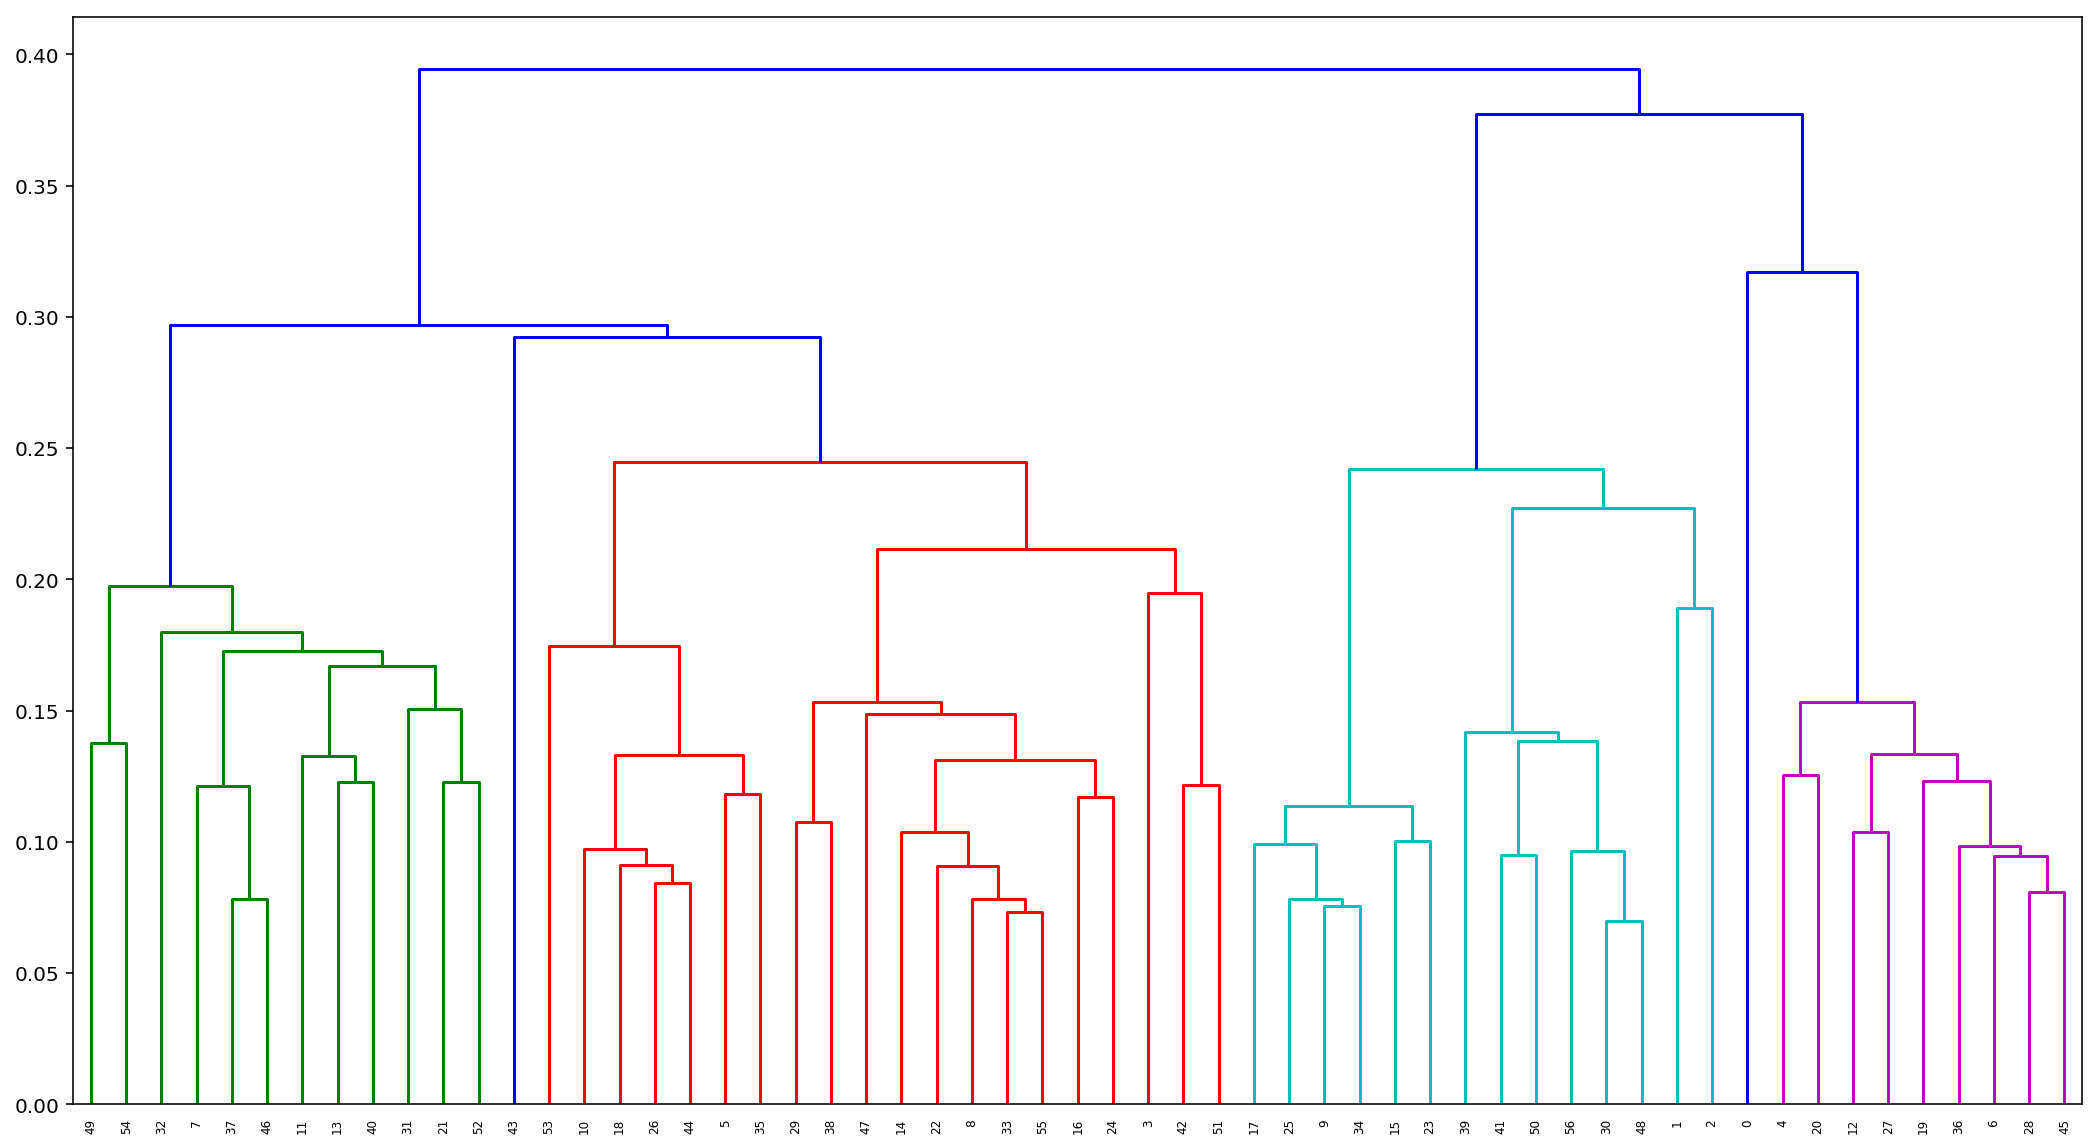

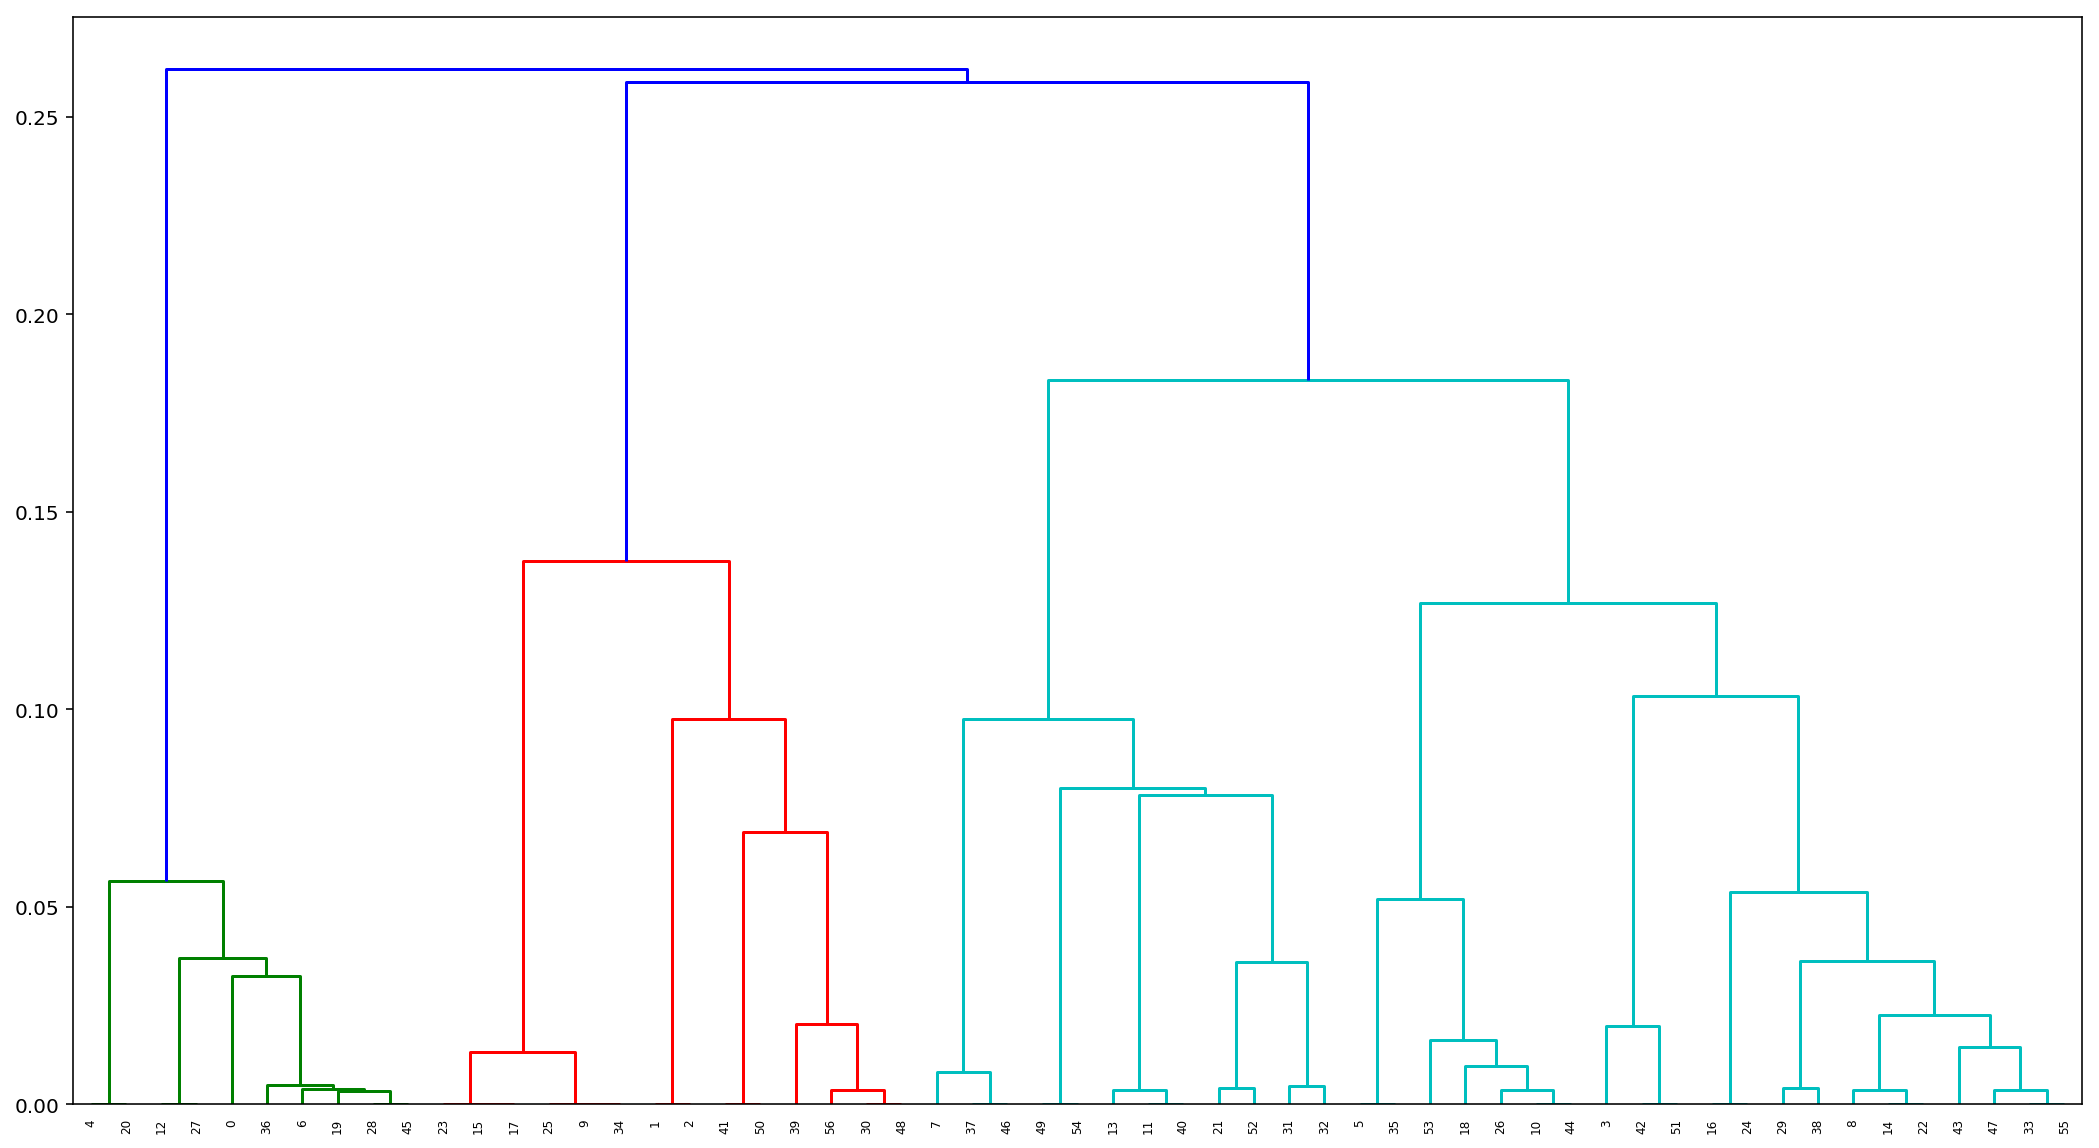

In [19]:
encode_bu(4200)

[I 190521 14:33:11 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320ad64ef0>,), kwds={})
[D 190521 14:33:11 clustering:178] Starting row 0-28
[I 190521 14:33:11 utils:57] Finished distance matrix calculation


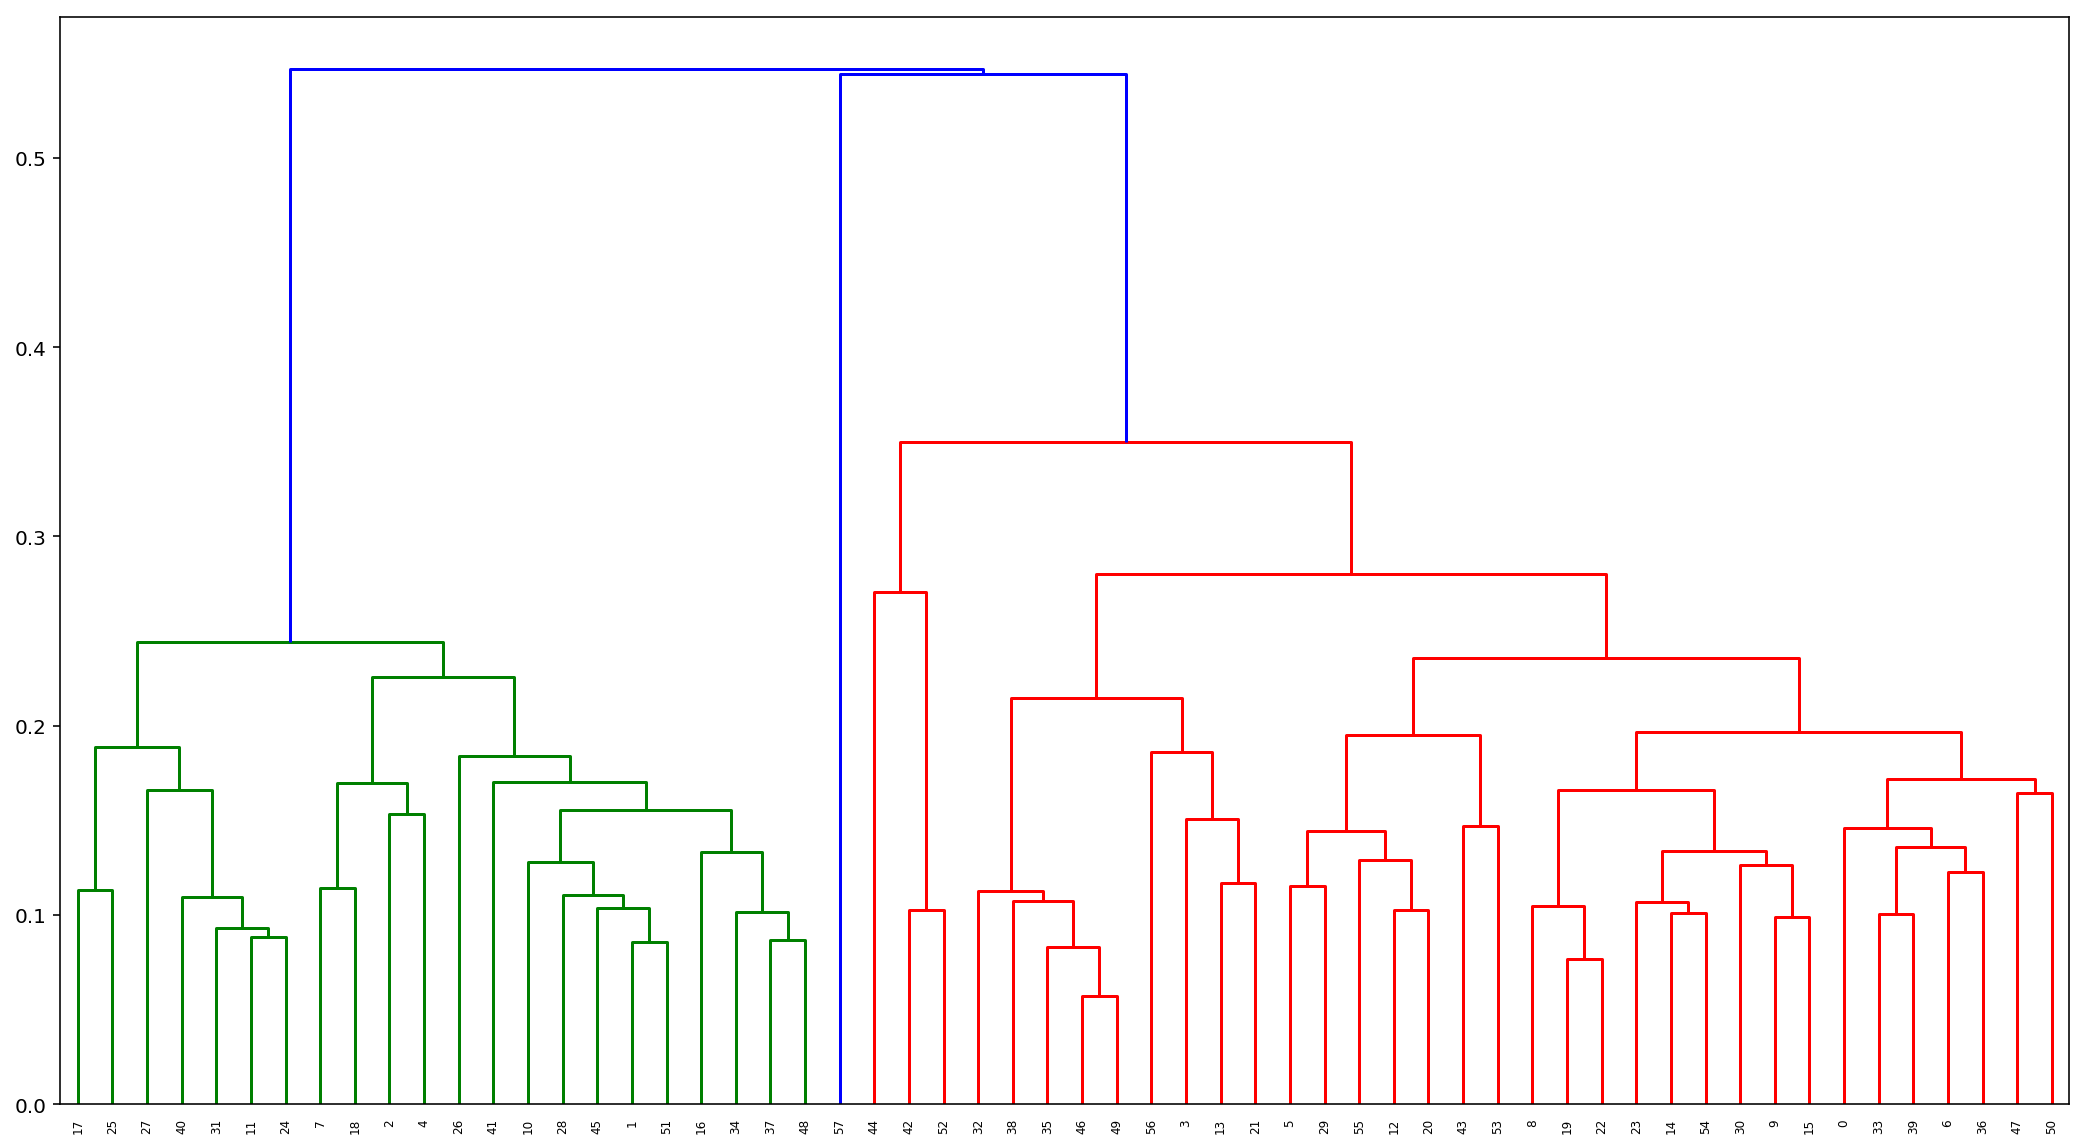

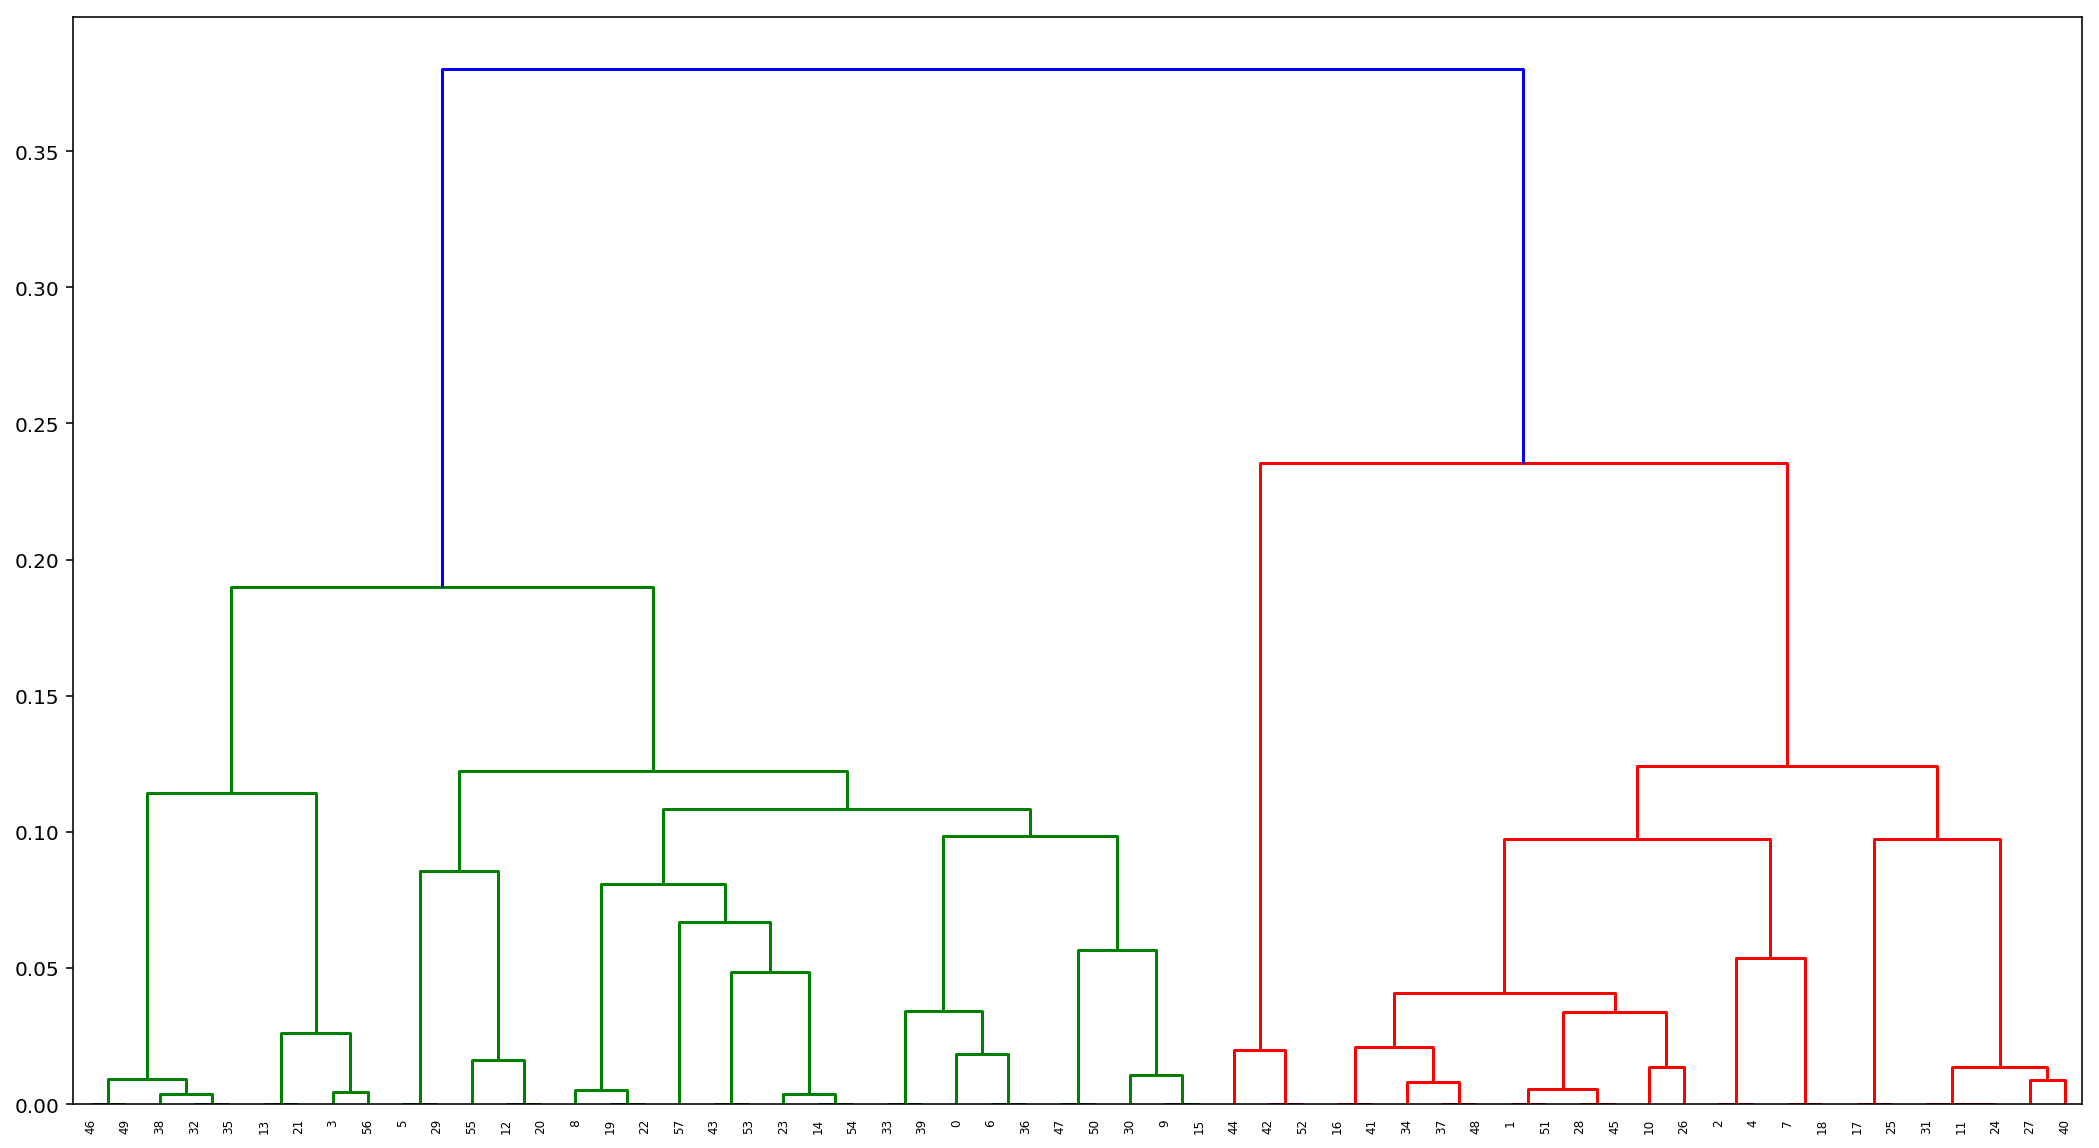

In [20]:
encode_bu(4460)

[I 190521 14:34:00 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a2e6550>,), kwds={})
[D 190521 14:34:00 clustering:178] Starting row 0-27
[I 190521 14:34:01 utils:57] Finished distance matrix calculation


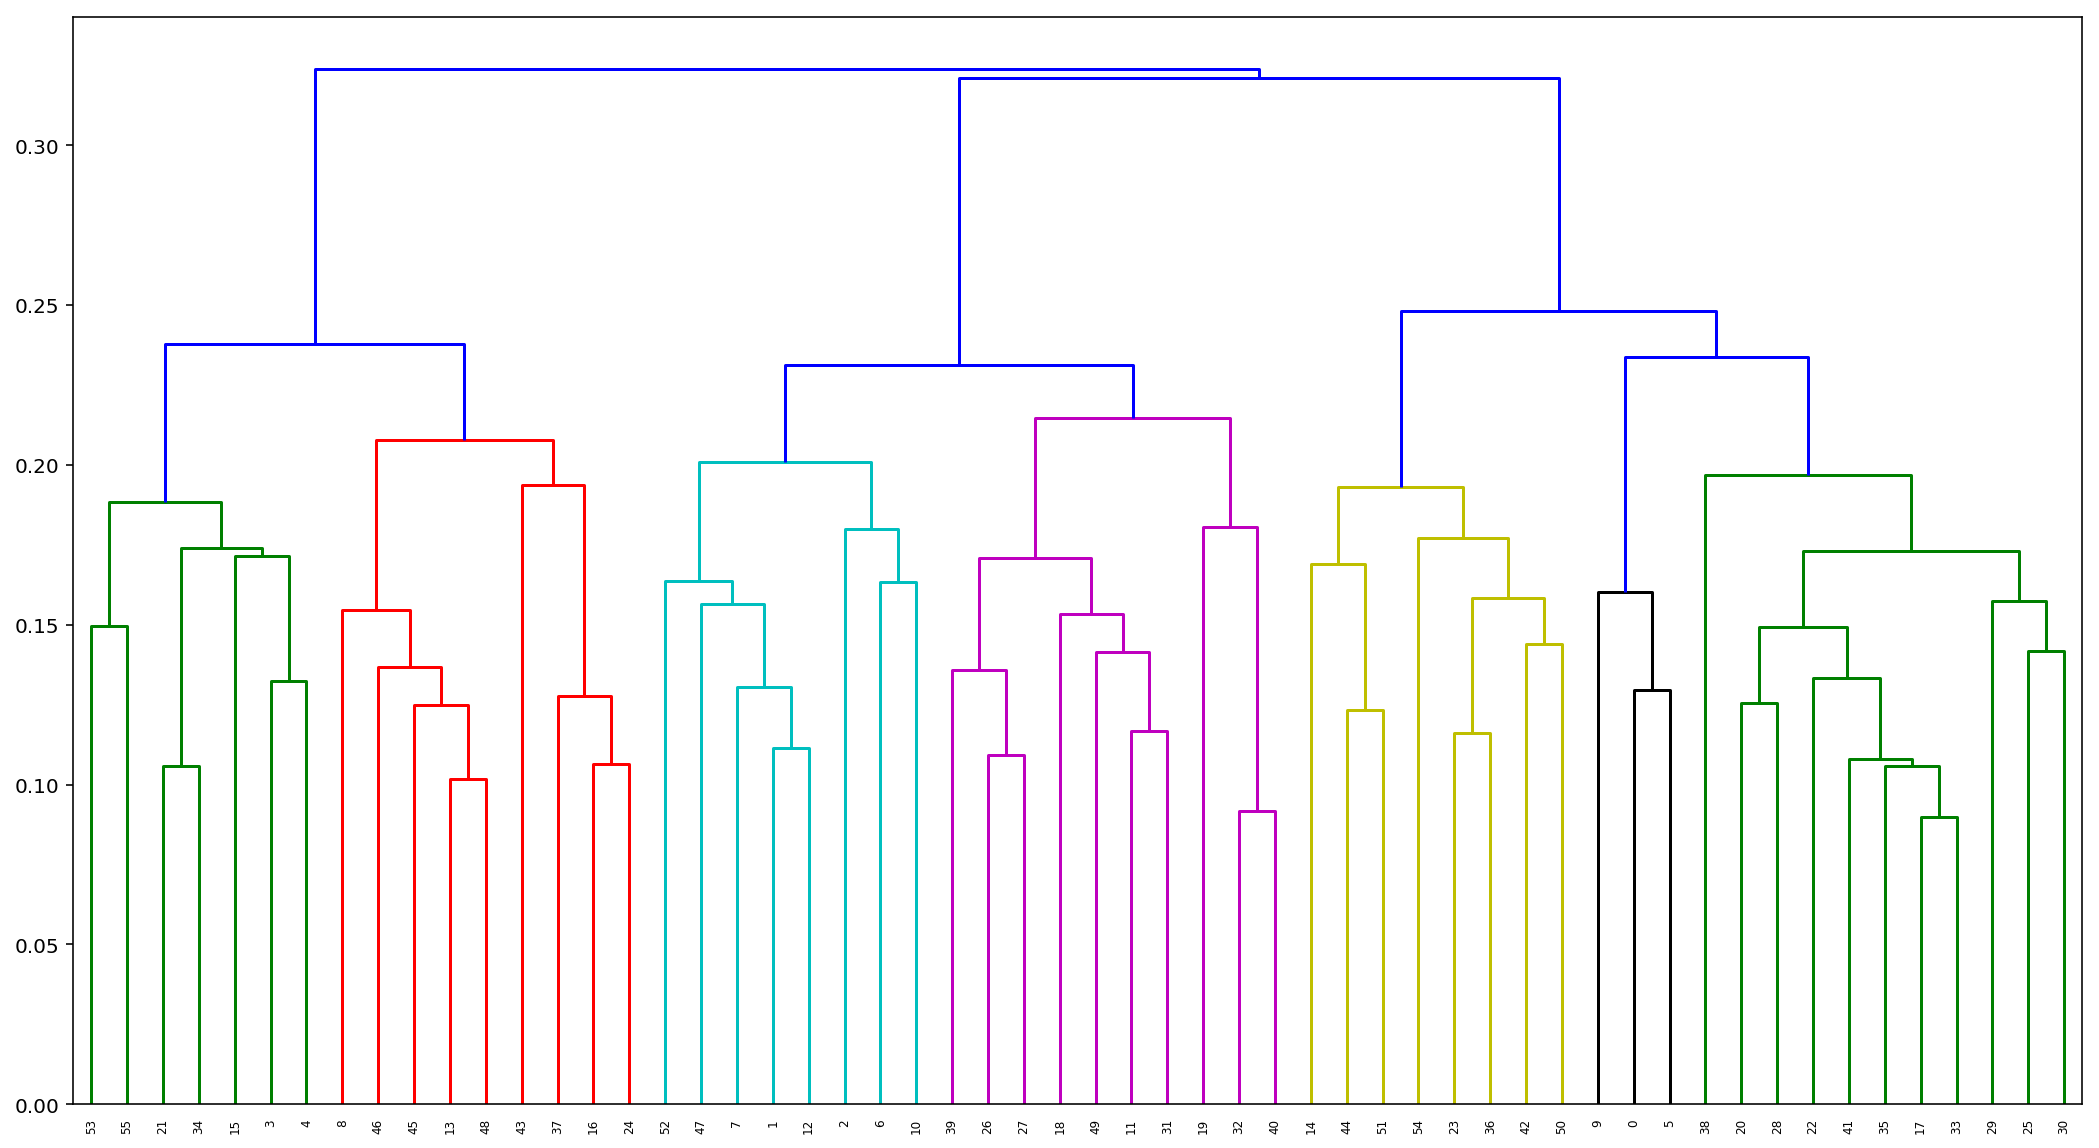

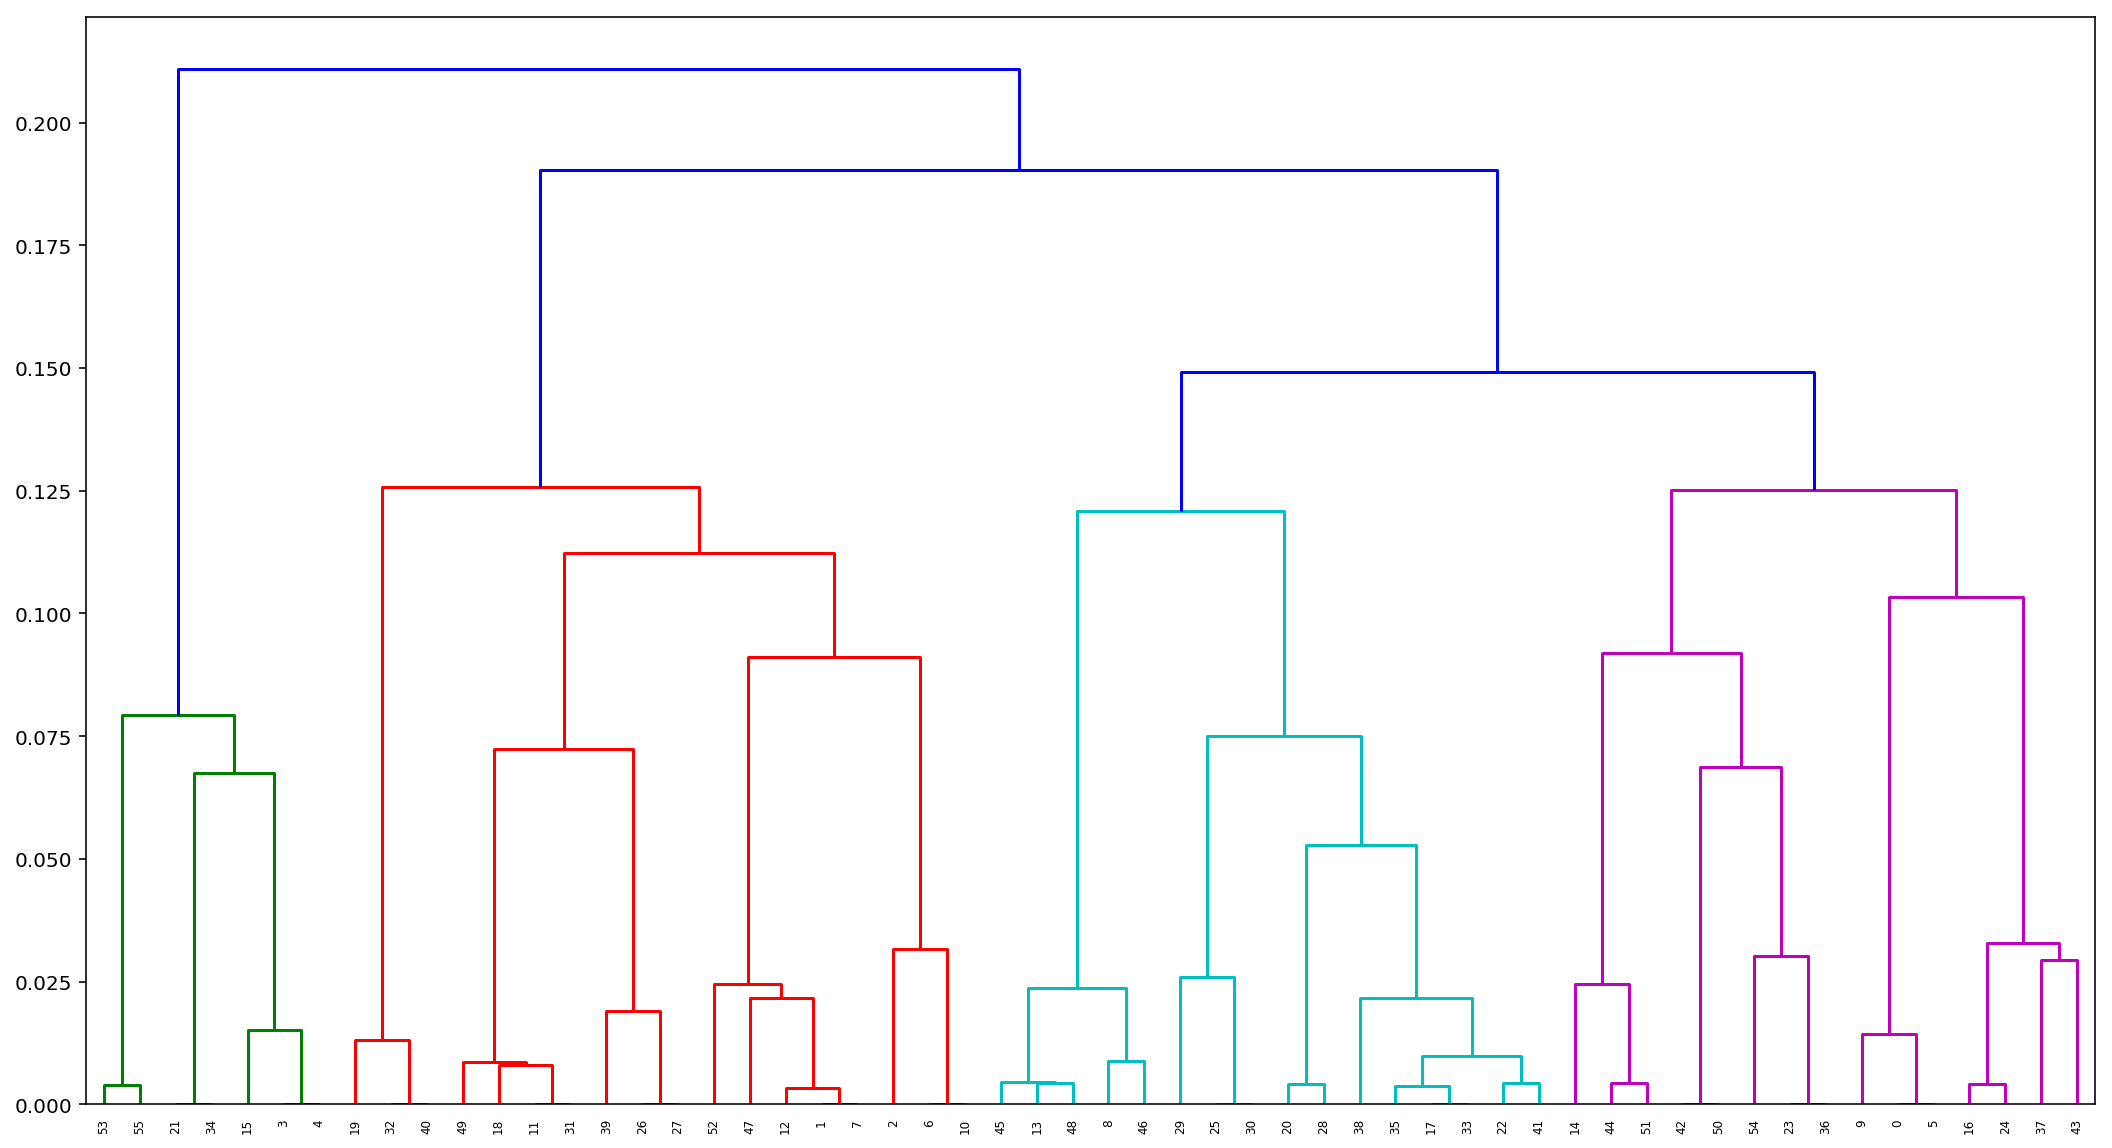

In [21]:
encode_bu(5902)

[I 190521 14:34:50 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2b320a2809b0>,), kwds={})
[D 190521 14:34:50 clustering:178] Starting row 0-32
[I 190521 14:34:50 utils:57] Finished distance matrix calculation


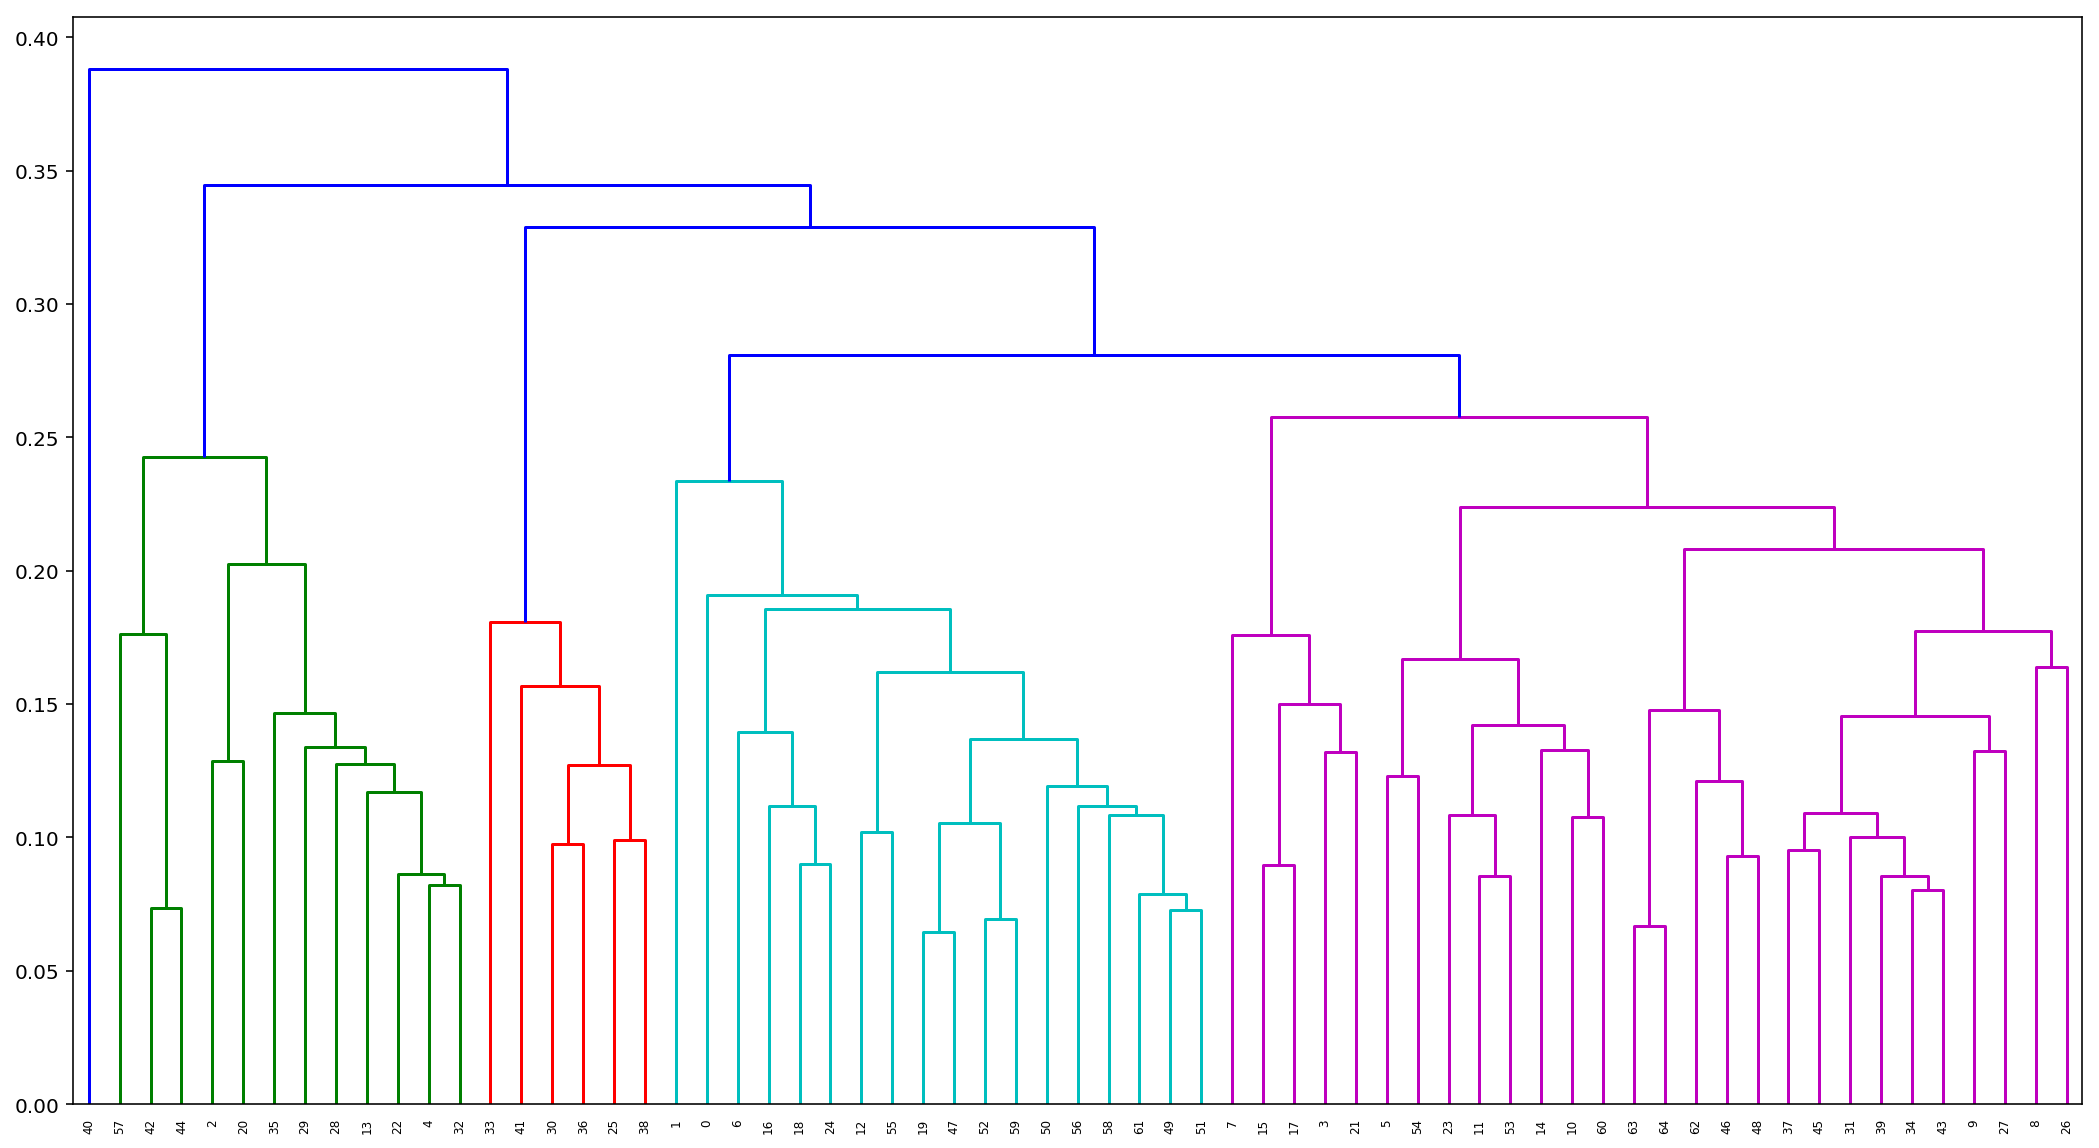

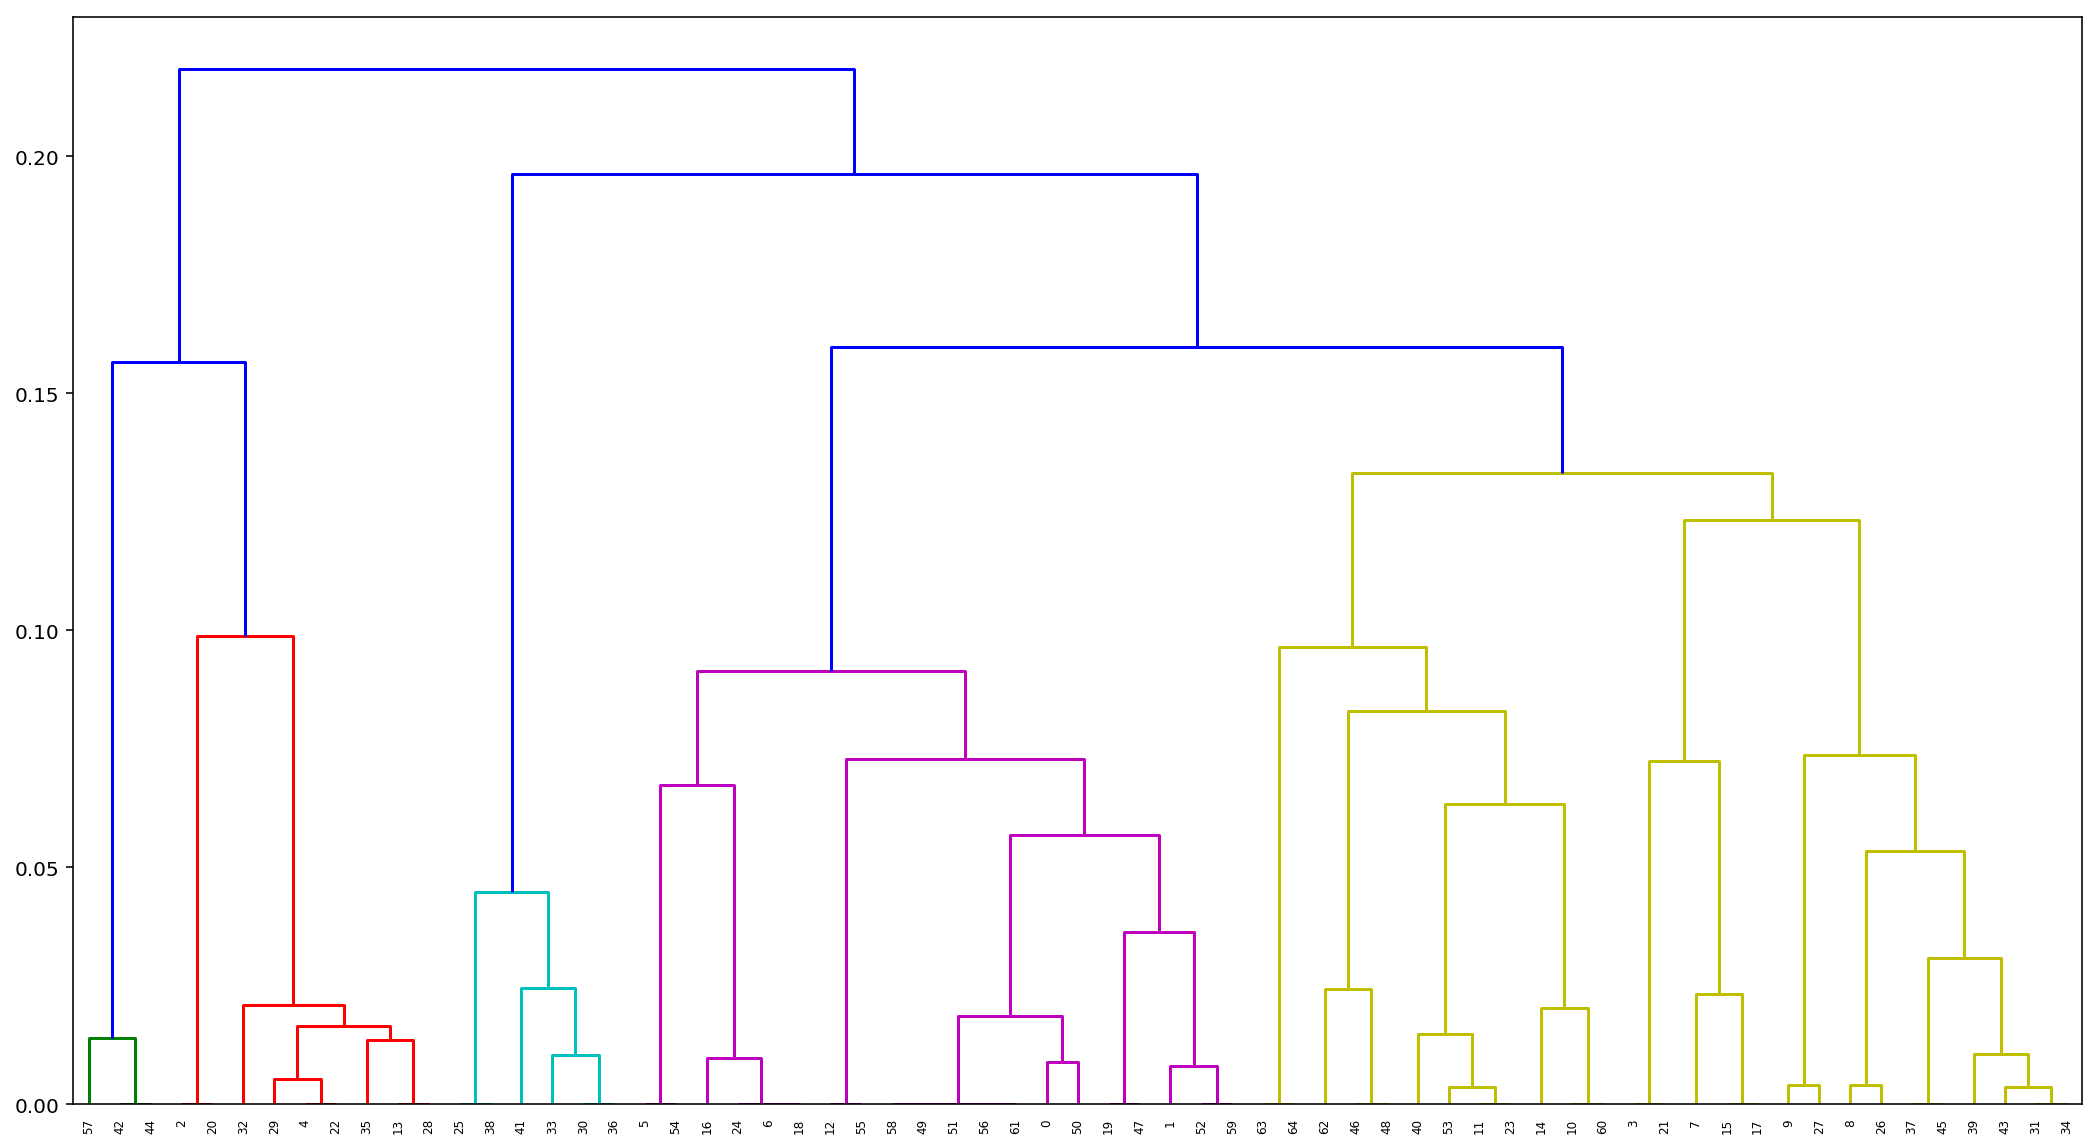

In [22]:
encode_bu(6461)

## [DEVELOP] [MAIN] ExtSeq - class for sequence profile

In [381]:
# とりあえず単純にExtSeq.consensusで置き換えながらやる(本当はn=2の時とかによくないのであとで変える)


in_seqs = copy.copy(seqs)
valid_indice = set(range(len(in_seqs)))
breakdown = {i: set([i]) for i in range(len(in_seqs))}
while True:
    # recalculate the distance matrix
    c = ClusteringSeqs(pd.Series([u if type(u) == str
                                  else u.consensus(single=True, full=True)
                                  for i, u in enumerate(in_seqs)
                                  if i in valid_indice]))
    c.calc_dist_mat()
    #c.dendrogram()
    logger.info(f"ext seq = {[i for i, u in enumerate(in_seqs) if i in valid_indice and type(u) == ExtSeq]}")

    # find closest pair
    for i in range(c.s_dist_mat.shape[0]):
        c.s_dist_mat[i][i] = np.inf
    i, j = np.unravel_index(np.argmin(c.s_dist_mat), c.s_dist_mat.shape)
    d = c.s_dist_mat[i][j]
    if d >= 0.15:
        break
    map_table = {i: val for i, val in enumerate(sorted(valid_indice))}
    i, j = map_table[i], map_table[j]
    if i > j:
        i, j = j, i
    i, j = min([i, j]), max([i, j])
    new_index = len(in_seqs)
    logger.info(f"merge {i}({len(breakdown[i])}) and {j}({len(breakdown[j])}) (d={d:.2}) -> {new_index}")

    # merge them
    valid_indice -= set([i, j])
    valid_indice.add(new_index)
    breakdown[new_index] = breakdown[i] | breakdown[j]
    ui, uj = in_seqs[i], in_seqs[j]
    ui, uj = ui if type(ui) == ExtSeq else ExtSeq(ui), uj if type(uj) == ExtSeq else ExtSeq(uj)
    PairwiseAlignment(ui if type(ui) == str else ui.consensus(single=True, full=True),
                      uj if type(uj) == str else uj.consensus(single=True, full=True)).show()
    uij, diff, cigar = align_ext_seq(ui, uj)
    in_seqs.append(uij)
    print(round(diff, 3))

[I 190517 10:45:43 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58cdb9e48>,), kwds={})
[D 190517 10:45:43 clustering:178] Starting row 0-21
[I 190517 10:45:43 utils:57] Finished distance matrix calculation
[I 190517 10:45:43 <ipython-input-381-0a6e63d88387>:15] ext seq = []
[I 190517 10:45:43 <ipython-input-381-0a6e63d88387>:30] merge 33(1) and 35(1) (d=0.061) -> 43
[I 190517 10:45:43 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894e10>,), kwds={})


             -   -          -                                --                   
atctgtagagtat ctc gtgtctgtag tgatcgatcacatgacgctatgtactagcata  tgtgctacgcagtgacaga
             g   t          c                                gc                   
0.061


[D 190517 10:45:43 clustering:178] Starting row 0-20
[I 190517 10:45:43 utils:57] Finished distance matrix calculation
[I 190517 10:45:43 <ipython-input-381-0a6e63d88387>:15] ext seq = [43]
[I 190517 10:45:43 <ipython-input-381-0a6e63d88387>:30] merge 27(1) and 43(2) (d=0.051) -> 44
[I 190517 10:45:44 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8947b8>,), kwds={})


               -         -                                          --         
atctgtagagtatct gtgtctgta ctgatcgatcacatgacgctatgtactagcatactgtgctac  agtgacaga
               c         g                                          gc         
0.049


[D 190517 10:45:44 clustering:178] Starting row 0-20
[I 190517 10:45:44 utils:57] Finished distance matrix calculation
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:15] ext seq = [44]
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:30] merge 29(1) and 38(1) (d=0.072) -> 45
[I 190517 10:45:44 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894198>,), kwds={})


                                        -     c-                    g   --         
atctgtagatagtatctctgtgtctgtactgatcgatcac tgacg  tatgtactagcatactgtgc tac  agtgacaga
                                        a     ta                    -   gc         
0.072


[D 190517 10:45:44 clustering:178] Starting row 0-19
[I 190517 10:45:44 utils:57] Finished distance matrix calculation
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:15] ext seq = [44, 45]
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:30] merge 34(1) and 45(2) (d=0.072) -> 46
[I 190517 10:45:44 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894e10>,), kwds={})


         --                          g         t                   a     -         
atctgtaga  gtatctctgtgtctgtactgatcgat acatgacgc atatgtactagcatactgt gctac agtgacaga
         ta                          c         -                   -     c         
0.059


[D 190517 10:45:44 clustering:178] Starting row 0-19
[I 190517 10:45:44 utils:57] Finished distance matrix calculation
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:15] ext seq = [44, 46]
[I 190517 10:45:44 <ipython-input-381-0a6e63d88387>:30] merge 42(1) and 44(3) (d=0.072) -> 47
[I 190517 10:45:45 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8947b8>,), kwds={})


           g    t          c                  g                 a        t         
atctgtagagt tctc gtgtctgtag tgatcgatcacatgacgc tatgtactagcatactg tgctacgc agtgacaga
           a    -          -                  -                 -        -         
0.069


[D 190517 10:45:45 clustering:178] Starting row 0-18
[I 190517 10:45:45 utils:57] Finished distance matrix calculation
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:15] ext seq = [46, 47]
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:30] merge 3(1) and 17(1) (d=0.082) -> 48
[I 190517 10:45:45 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894cc0>,), kwds={})


  --                       g                -             -     -               g    
at  gtagagtatctctgtcgctgtac tcgatcgtatacatga cgctatatgtact agcat ctgtgcgtacagtga caga
  ct                       -                g             g     a               -    
0.082


[D 190517 10:45:45 clustering:178] Starting row 0-18
[I 190517 10:45:45 utils:57] Finished distance matrix calculation
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:15] ext seq = [46, 47, 48]
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:30] merge 46(3) and 47(4) (d=0.085) -> 49
[I 190517 10:45:45 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894fd0>,), kwds={})


         ta       t         c                  a                       --         
atctgtaga  gtatctc gtgtctgta tgatcgatcacatgacgc tatgtactagcatactgtgctac  agtgacaga
         --       -         g                  -                       gc         
0.073


[D 190517 10:45:45 clustering:178] Starting row 0-17
[I 190517 10:45:45 utils:57] Finished distance matrix calculation
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:15] ext seq = [48, 49]
[I 190517 10:45:45 <ipython-input-381-0a6e63d88387>:30] merge 12(1) and 49(7) (d=0.075) -> 50
[I 190517 10:45:46 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894208>,), kwds={})


                t         g         -                      -            a  g    
atctgtagagtatctc gtgtctgta ctgatcgat acatgacgctatgtactagcat ctgtgctacagt ga caga
                -         -         c                      a            -  -    
0.06


[D 190517 10:45:46 clustering:178] Starting row 0-17
[I 190517 10:45:46 utils:57] Finished distance matrix calculation
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:15] ext seq = [48, 50]
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:30] merge 30(1) and 50(8) (d=0.087) -> 51
[I 190517 10:45:46 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894908>,), kwds={})


             a  t     a                                t   g              ta    
atctgtagagtat tc gtgtc gtactgatcgatcacatgacgctatgtactag cat ctgtgctacagtga  caga
             c  -     t                                -   a              --    
0.067


[D 190517 10:45:46 clustering:178] Starting row 0-16
[I 190517 10:45:46 utils:57] Finished distance matrix calculation
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:15] ext seq = [48, 51]
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:30] merge 11(1) and 51(9) (d=0.09) -> 52
[I 190517 10:45:46 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894550>,), kwds={})


  a c          -           -  -      gc                                       
at t tagagtatct gtgtctgtact at gatcac  atgacgctatgtactagcatactgtgctacagtgacaga
  c g          c           g  c      --                                       
0.066


[D 190517 10:45:46 clustering:178] Starting row 0-16
[I 190517 10:45:46 utils:57] Finished distance matrix calculation
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:15] ext seq = [48, 52]
[I 190517 10:45:46 <ipython-input-381-0a6e63d88387>:30] merge 26(1) and 32(1) (d=0.091) -> 53
[I 190517 10:45:46 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8949e8>,), kwds={})


                    --              cg  at          --                                  
atctgtagagtatctctgtg  tgtctgtactgatg  at  cacatgacgc  tatatgtactagcatactgtgtacagtgagcaga
                    cg              --  --          gc                                  
0.091


[D 190517 10:45:46 clustering:178] Starting row 0-15
[I 190517 10:45:47 utils:57] Finished distance matrix calculation
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:15] ext seq = [48, 52, 53]
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:30] merge 0(1) and 48(2) (d=0.093) -> 54
[I 190517 10:45:47 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894748>,), kwds={})


   tc  c                  g             gc      t            c                        
atc  ta agtatctctgtcgctgta ctcgatcgtatac  atgacg ctatatgtacta gcatactgtgcgtacagtgacaga
   g-  g                  -             --      -            -                        
0.078


[D 190517 10:45:47 clustering:178] Starting row 0-15
[I 190517 10:45:47 utils:57] Finished distance matrix calculation
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:15] ext seq = [52, 53, 54]
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:30] merge 10(1) and 52(10) (d=0.096) -> 55
[I 190517 10:45:47 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894518>,), kwds={})


         t      -                  at       g   gc        c                        
atctgtaga gtatct gtgtctgtactgatcgat  cacatga cgc  tatgtact agcatactgtgctacagtgacaga
         -      c                  --       -   --        -                        
0.071


[D 190517 10:45:47 clustering:178] Starting row 0-14
[I 190517 10:45:47 utils:57] Finished distance matrix calculation
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 54, 55]
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:30] merge 14(1) and 40(1) (d=0.1) -> 56


               --        -        -              -       c c      g                -    
atctgtagagtatct  gtgtctgt ctgatcga tcacgcgcatgacg ctatgta t agcata ctgtgctacgcagtga caga
               ct        a        g              a       - -      -                g    
0.102


[I 190517 10:45:47 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f4a8>,), kwds={})
[D 190517 10:45:47 clustering:178] Starting row 0-14
[I 190517 10:45:47 utils:57] Finished distance matrix calculation
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 54, 55, 56]
[I 190517 10:45:47 <ipython-input-381-0a6e63d88387>:30] merge 55(11) and 56(2) (d=0.095) -> 57
[I 190517 10:45:47 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894ba8>,), kwds={})


                                     ----      -         -               --         
atctgtagagtatctcgtgtctgtactgatcgatcac    atgacg ctatgtact agcatactgtgctac  agtgacaga
                                     gcgc      a         c               gc         
0.048


[D 190517 10:45:48 clustering:178] Starting row 0-13
[I 190517 10:45:48 utils:57] Finished distance matrix calculation
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 54, 57]
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:30] merge 2(1) and 54(3) (d=0.1) -> 58


       tc                                      a    c     a       g      -       c    -
atctgta  agtatctctgtcgctgtactcgatcgtatacatgacgc tata tgtac tagcata ctgtgc tacagtg acag 
       g-                                      -    -     -       -      g       -    a


[I 190517 10:45:48 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f898>,), kwds={})


0.094


[D 190517 10:45:48 clustering:178] Starting row 0-13
[I 190517 10:45:48 utils:57] Finished distance matrix calculation
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 57, 58]
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:30] merge 21(1) and 24(1) (d=0.11) -> 59
[I 190517 10:45:48 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8949e8>,), kwds={})


                    -     -          c      c- -    g                        g  -   
atctgtagagtatctctgtg ctgta tgatcgatca gcatga  g cgct atgtactagcatctgtgctacagt ac aga
                    t     c          -      ga t    -                        -  t   
0.107


[D 190517 10:45:48 clustering:178] Starting row 0-12
[I 190517 10:45:48 utils:57] Finished distance matrix calculation
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 57, 58, 59]
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:30] merge 57(13) and 58(4) (d=0.11) -> 60


                g    --      -     -  c            --                 -            
atctgtagagtatctc tgtc  tgtact gatcg at acatgacgctat  gtactagcatactgtgc tacagtgacaga
                -    gc      c     t  -            at                 g            
0.061

[I 190517 10:45:48 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58cfd68d0>,), kwds={})


[D 190517 10:45:48 clustering:178] Starting row 0-12
[I 190517 10:45:48 utils:57] Finished distance matrix calculation
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 59, 60]
[I 190517 10:45:48 <ipython-input-381-0a6e63d88387>:30] merge 13(1) and 60(17) (d=0.11) -> 61
[I 190517 10:45:49 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f898>,), kwds={})


  g     t     g   t            c                gc        -                    -  
at ctgta agtat ctc gtgtctgtactg atcgatcacatgacgc  tatgtact gcatactgtgctacagtgac ga
  -     g     -   -            -                --        a                    a  
0.059


[D 190517 10:45:49 clustering:178] Starting row 0-11
[I 190517 10:45:49 utils:57] Finished distance matrix calculation
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 59, 61]
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:30] merge 25(1) and 61(18) (d=0.11) -> 62


       c         -                  t         gc   at   -              -          
atctgta gagtatctc tgtctgtactgatcgatc acatgacgc  tat  gta tagcatactgtgct cagtgacaga
       -         g                  -         --   --   c              a          


[I 190517 10:45:49 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f438>,), kwds={})


0.057


[D 190517 10:45:49 clustering:178] Starting row 0-11
[I 190517 10:45:49 utils:57] Finished distance matrix calculation
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 59, 62]
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:30] merge 59(2) and 62(19) (d=0.11) -> 63


                t   -                 gc     a  gc             -            -     
atctgtagagtatctc gtg ctgtactgatcgatcac  atgac gc  tatgtactagcat ctgtgctacagt acaga
                -   t                 --     -  --             a            g     
0.03


[I 190517 10:45:49 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f160>,), kwds={})
[D 190517 10:45:49 clustering:178] Starting row 0-10
[I 190517 10:45:49 utils:57] Finished distance matrix calculation
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 63]
[I 190517 10:45:49 <ipython-input-381-0a6e63d88387>:30] merge 19(1) and 41(1) (d=0.12) -> 64


                              --    c a t       c    g-                g   -          -    
atctgtagagtatctctgtgtctgtactga  tcga t c cacatga gcgc  tatgtagactagcata tgt gctacagtga caga
                              ga    - - a       -    ta                c   a          g    


[I 190517 10:45:50 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f438>,), kwds={})


0.121


[D 190517 10:45:50 clustering:178] Starting row 0-10
[I 190517 10:45:50 utils:57] Finished distance matrix calculation
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 63, 64]
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:30] merge 5(1) and 63(21) (d=0.13) -> 65
[I 190517 10:45:50 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8944e0>,), kwds={})


                t         g             ca  tg            c  ag t                 g    
atctgtagagtatctc gtgtctgta ctgatcgatcaca  tg  acgctatgtact ag  c atactgtgctacagtga caga
                -         -             --  --            -  -- -                 -    
0.061


[D 190517 10:45:50 clustering:178] Starting row 0-9
[I 190517 10:45:50 utils:57] Finished distance matrix calculation
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 64, 65]
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:30] merge 7(1) and 65(22) (d=0.13) -> 66


                t                     t g at c tga         g                     -    
atctgtagagtatctc gtgtctgtactgatcgatcac a t  g a   cgctatgta ctagcatactgtgctacagtg caga
                -                     - - -- - ---         -                     a    
0.058


[I 190517 10:45:50 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894cc0>,), kwds={})
[D 190517 10:45:50 clustering:178] Starting row 0-9
[I 190517 10:45:50 utils:57] Finished distance matrix calculation
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 64, 66]
[I 190517 10:45:50 <ipython-input-381-0a6e63d88387>:30] merge 22(1) and 66(23) (d=0.13) -> 67
[I 190517 10:45:51 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f898>,), kwds={})


                t        gt       t                        gc        tg    gc   -     
atctgtagagtatctc gtgtctgt  actgatc gatcacatgacgctatgtactagc  atactgtg  ctac  agt acaga
                -        --       -                        --        --    --   g     
0.055


[D 190517 10:45:51 clustering:178] Starting row 0-8
[I 190517 10:45:51 utils:57] Finished distance matrix calculation
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 64, 67]
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:30] merge 37(1) and 64(2) (d=0.13) -> 68
[I 190517 10:45:51 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894cc0>,), kwds={})


                             c     - g  g  t -        t       --        g    -    g          
atctgtagagtatctctgtgtctgtactg atcga t ca ca c tgacgcgc atatgta  ctagcata ctgt gcta cagtgacaga
                             a     c a  -  - a        g       ga        -    a    -          
0.093


[D 190517 10:45:51 clustering:178] Starting row 0-8
[I 190517 10:45:51 utils:57] Finished distance matrix calculation
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 67, 68]
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:30] merge 8(1) and 68(3) (d=0.11) -> 69
[I 190517 10:45:51 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c8949e8>,), kwds={})


       t       --                     g             c     --    tg    c                 
atctgta agtatct  gtgtctgtactgatcgatcac acatgacgcgcta atgta  ctag  cata tgtgctacagtgacaga
       g       ct                     -             t     ga    --    g                 
0.1


[D 190517 10:45:51 clustering:178] Starting row 0-7
[I 190517 10:45:51 utils:57] Finished distance matrix calculation
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 67, 69]
[I 190517 10:45:51 <ipython-input-381-0a6e63d88387>:30] merge 67(24) and 69(4) (d=0.095) -> 70


                -                      --      --   --   -                          
atctgtagagtatctc gtgtctgtactgatcgatcaca  tgacgc  tat  gta ctagcatactgtgctacagtgacaga
                t                      ca      gc   at   a                          


[I 190517 10:45:52 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894fd0>,), kwds={})


0.031


[D 190517 10:45:52 clustering:178] Starting row 0-7
[I 190517 10:45:52 utils:57] Finished distance matrix calculation
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 70]
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:30] merge 16(1) and 70(28) (d=0.13) -> 71
[I 190517 10:45:52 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f3c8>,), kwds={})


    c      g   -  c -             cg at         a         c                       
atct tagagt tct gt g ctgtactgatcga  t  cacatgacg tatgtacta gcatactgtgctacagtgacaga
    g      a   c  - t             -- --         c         -                       
0.048


[D 190517 10:45:52 clustering:178] Starting row 0-6
[I 190517 10:45:52 utils:57] Finished distance matrix calculation
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:15] ext seq = [53, 71]
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:30] merge 39(1) and 53(2) (d=0.13) -> 72
[I 190517 10:45:52 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1fa90>,), kwds={})


-       c        a    -          ct   c -  -          -                             -   -
 tctgtag agtatctc tgtg tgtctgtact  gat g at cacatgacgc tatatgtactagcatactgtgtacagtga cag 
a       -        -    c          --   - c  a          c                             g   a
0.086


[D 190517 10:45:52 clustering:178] Starting row 0-6
[I 190517 10:45:52 utils:57] Finished distance matrix calculation
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:15] ext seq = [71, 72]
[I 190517 10:45:52 <ipython-input-381-0a6e63d88387>:30] merge 71(29) and 72(3) (d=0.098) -> 73
[I 190517 10:45:53 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba58c894ba8>,), kwds={})


                -    --          c                --                c        -    
atctgtagagtatctc gtgt  ctgtactgat gatcacatgacgctat  gtactagcatactgtg tacagtga caga
                t    gt          -                at                -        g    
0.032


[D 190517 10:45:53 clustering:178] Starting row 0-5
[I 190517 10:45:53 utils:57] Finished distance matrix calculation
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:15] ext seq = [73]
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:30] merge 23(1) and 73(32) (d=0.14) -> 74
[I 190517 10:45:53 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f4a8>,), kwds={})


--              t    gt     g           gc                     -    -          t 
  ctgtagagtatctc gtgt  ctgta tgatcgatcac  atgacgctatgtactagcata tgtg tacagtgaca a
at              -    --     c           --                     c    c          g 
0.047


[D 190517 10:45:53 clustering:178] Starting row 0-5
[I 190517 10:45:53 utils:57] Finished distance matrix calculation
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:15] ext seq = [74]
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:30] merge 28(1) and 74(33) (d=0.14) -> 75
[I 190517 10:45:53 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1f898>,), kwds={})


 g       t       g t                            gc   at      t ag        a              
a tctgtag agtatct c gtgtctgtactgatcgatcacatgacgc  tat  gtacta g  catactgt gctacagtgacaga
 -       -       - -                            --   --      - --        -              
0.045


[D 190517 10:45:53 clustering:178] Starting row 0-4
[I 190517 10:45:53 utils:57] Finished distance matrix calculation
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:15] ext seq = [75]
[I 190517 10:45:53 <ipython-input-381-0a6e63d88387>:30] merge 15(1) and 75(34) (d=0.14) -> 76
[I 190517 10:45:54 utils:55] Starting distance matrix calculation (args=(<dacembler.clustering.ClusteringSeqs object at 0x2ba577b1fb38>,), kwds={})


               -         g  -  -   at                ta                 gtgc         
atctgtagagtatct gtgtctgta ct at gat  cacatgacgctatgta  ctagcatactgtgctac    agtgacaga
               c         -  g  c   --                --                 ----         
0.044


[D 190517 10:45:54 clustering:178] Starting row 0-4
[I 190517 10:45:54 utils:57] Finished distance matrix calculation
[I 190517 10:45:54 <ipython-input-381-0a6e63d88387>:15] ext seq = [76]


In [364]:
breakdown

{0: {0},
 1: {1},
 2: {2},
 3: {3},
 4: {4},
 5: {5},
 6: {6},
 7: {7},
 8: {8},
 9: {9},
 10: {10},
 11: {11},
 12: {12},
 13: {13},
 14: {14},
 15: {15},
 16: {16},
 17: {17},
 18: {18},
 19: {19},
 20: {20},
 21: {21},
 22: {22},
 23: {23},
 24: {24},
 25: {25},
 26: {26},
 27: {27},
 28: {28},
 29: {29},
 30: {30},
 31: {31},
 32: {32},
 33: {33},
 34: {34},
 35: {35},
 36: {36},
 37: {37},
 38: {38},
 39: {39},
 40: {40},
 41: {41},
 42: {42},
 43: {33, 35},
 44: {27, 33, 35},
 45: {29, 38},
 46: {29, 34, 38},
 47: {27, 33, 35, 42},
 48: {3, 17},
 49: {27, 29, 33, 34, 35, 38, 42},
 50: {12, 27, 29, 33, 34, 35, 38, 42},
 51: {12, 27, 29, 30, 33, 34, 35, 38, 42},
 52: {11, 12, 27, 29, 30, 33, 34, 35, 38, 42},
 53: {26, 32},
 54: {0, 3, 17},
 55: {10, 11, 12, 27, 29, 30, 33, 34, 35, 38, 42},
 56: {14, 40},
 57: {10, 11, 12, 14, 27, 29, 30, 33, 34, 35, 38, 40, 42},
 58: {0, 2, 3, 17},
 59: {21, 24},
 60: {0, 2, 3, 10, 11, 12, 14, 17, 27, 29, 30, 33, 34, 35, 38, 40, 42},
 61: {0, 2, 3,

In [63]:
def calc_ext(u_list):
    assert len(u_list) >= 2, "Need at least 2 units"
    a = align_ext_seq(ExtSeq(seqs[u_list[0]]), ExtSeq(seqs[u_list[1]]))
    for u in u_list[2:]:
        a = align_ext_seq(a, ExtSeq(seqs[u]))
    return a

In [67]:
calc_ext([33, 35, 42, 29, 38]).string

[Counter({'a': 5}),
 Counter({'t': 5}),
 Counter({'c': 5}),
 Counter({'t': 5}),
 Counter({'g': 5}),
 Counter({'t': 5}),
 Counter({'a': 5}),
 Counter({'g': 5}),
 Counter({'a': 5}),
 Counter({'t': 1, '-': 4}),
 Counter({'a': 1, '-': 4}),
 Counter({'t': 1, '-': 4}),
 Counter({'a': 1, '-': 4}),
 Counter({'g': 5}),
 Counter({'t': 5}),
 Counter({'a': 4, 'g': 1}),
 Counter({'t': 5}),
 Counter({'g': 1, '-': 4}),
 Counter({'c': 5}),
 Counter({'t': 5}),
 Counter({'c': 5}),
 Counter({'t': 4, '-': 1}),
 Counter({'g': 5}),
 Counter({'t': 5}),
 Counter({'g': 5}),
 Counter({'t': 5}),
 Counter({'c': 5}),
 Counter({'t': 5}),
 Counter({'g': 5}),
 Counter({'t': 5}),
 Counter({'a': 5}),
 Counter({'g': 3, '-': 2}),
 Counter({'c': 4, '-': 1}),
 Counter({'t': 5}),
 Counter({'g': 5}),
 Counter({'a': 5}),
 Counter({'t': 5}),
 Counter({'c': 5}),
 Counter({'g': 5}),
 Counter({'a': 5}),
 Counter({'t': 5}),
 Counter({'c': 5}),
 Counter({'a': 5}),
 Counter({'c': 5}),
 Counter({'a': 4, '-': 1}),
 Counter({'t': 5}),


In [59]:
a

'atctgtagagtatctctgtgtctgtagctgatcgatcacatgacgctatgtactagcatactgtgctacgcagtgacaga'

In [68]:
calc_ext([27, 34, 12, 30]).string#consensus(single=True, full=True)

[Counter({'a': 4}),
 Counter({'t': 4}),
 Counter({'c': 4}),
 Counter({'t': 4}),
 Counter({'g': 4}),
 Counter({'t': 4}),
 Counter({'a': 4}),
 Counter({'g': 4}),
 Counter({'a': 4}),
 Counter({'g': 4}),
 Counter({'t': 4}),
 Counter({'a': 4}),
 Counter({'t': 4}),
 Counter({'c': 3, 'a': 1}),
 Counter({'t': 4}),
 Counter({'c': 3, '-': 1}),
 Counter({'t': 3, '-': 1}),
 Counter({'g': 4}),
 Counter({'t': 4}),
 Counter({'g': 4}),
 Counter({'t': 4}),
 Counter({'c': 4}),
 Counter({'t': 3, 'a': 1}),
 Counter({'g': 4}),
 Counter({'t': 4}),
 Counter({'a': 4}),
 Counter({'g': 1, '-': 3}),
 Counter({'c': 4}),
 Counter({'t': 4}),
 Counter({'g': 4}),
 Counter({'a': 4}),
 Counter({'t': 4}),
 Counter({'c': 4}),
 Counter({'g': 4}),
 Counter({'a': 4}),
 Counter({'t': 4}),
 Counter({'c': 2, 'g': 1, '-': 1}),
 Counter({'a': 4}),
 Counter({'c': 4}),
 Counter({'a': 4}),
 Counter({'t': 4}),
 Counter({'g': 4}),
 Counter({'a': 4}),
 Counter({'c': 4}),
 Counter({'g': 4}),
 Counter({'c': 4}),
 Counter({'t': 4}),
 Cou

In [61]:
b

'atctgtagagtatctctgtgtctgtactgatcgatcacatgacgctatgtactagcatactgtgctacagtgacaga'

In [62]:
PairwiseAlignment(a, b).show()

                          g                                          gc         
atctgtagagtatctctgtgtctgta ctgatcgatcacatgacgctatgtactagcatactgtgctac  agtgacaga
                          -                                          --         


In [13]:
best_units = Counter()
edges = {}   # {(source, target): dist}
for i in range(c.N):
    best_unit = np.argmin([x if j != i else 1 for j, x in enumerate(c.s_dist_mat[i])])
    best_units[best_unit] += 1
    edges[(i, best_unit)] = c.s_dist_mat[i][best_unit]
#seed = best_units.most_common()[0][0]
G = ig.Graph.DictList(edges=(dict(source=s, target=t) for s, t in edges.keys()),
                      vertices=(dict(name=i) for i in range(c.N)), directed=True)

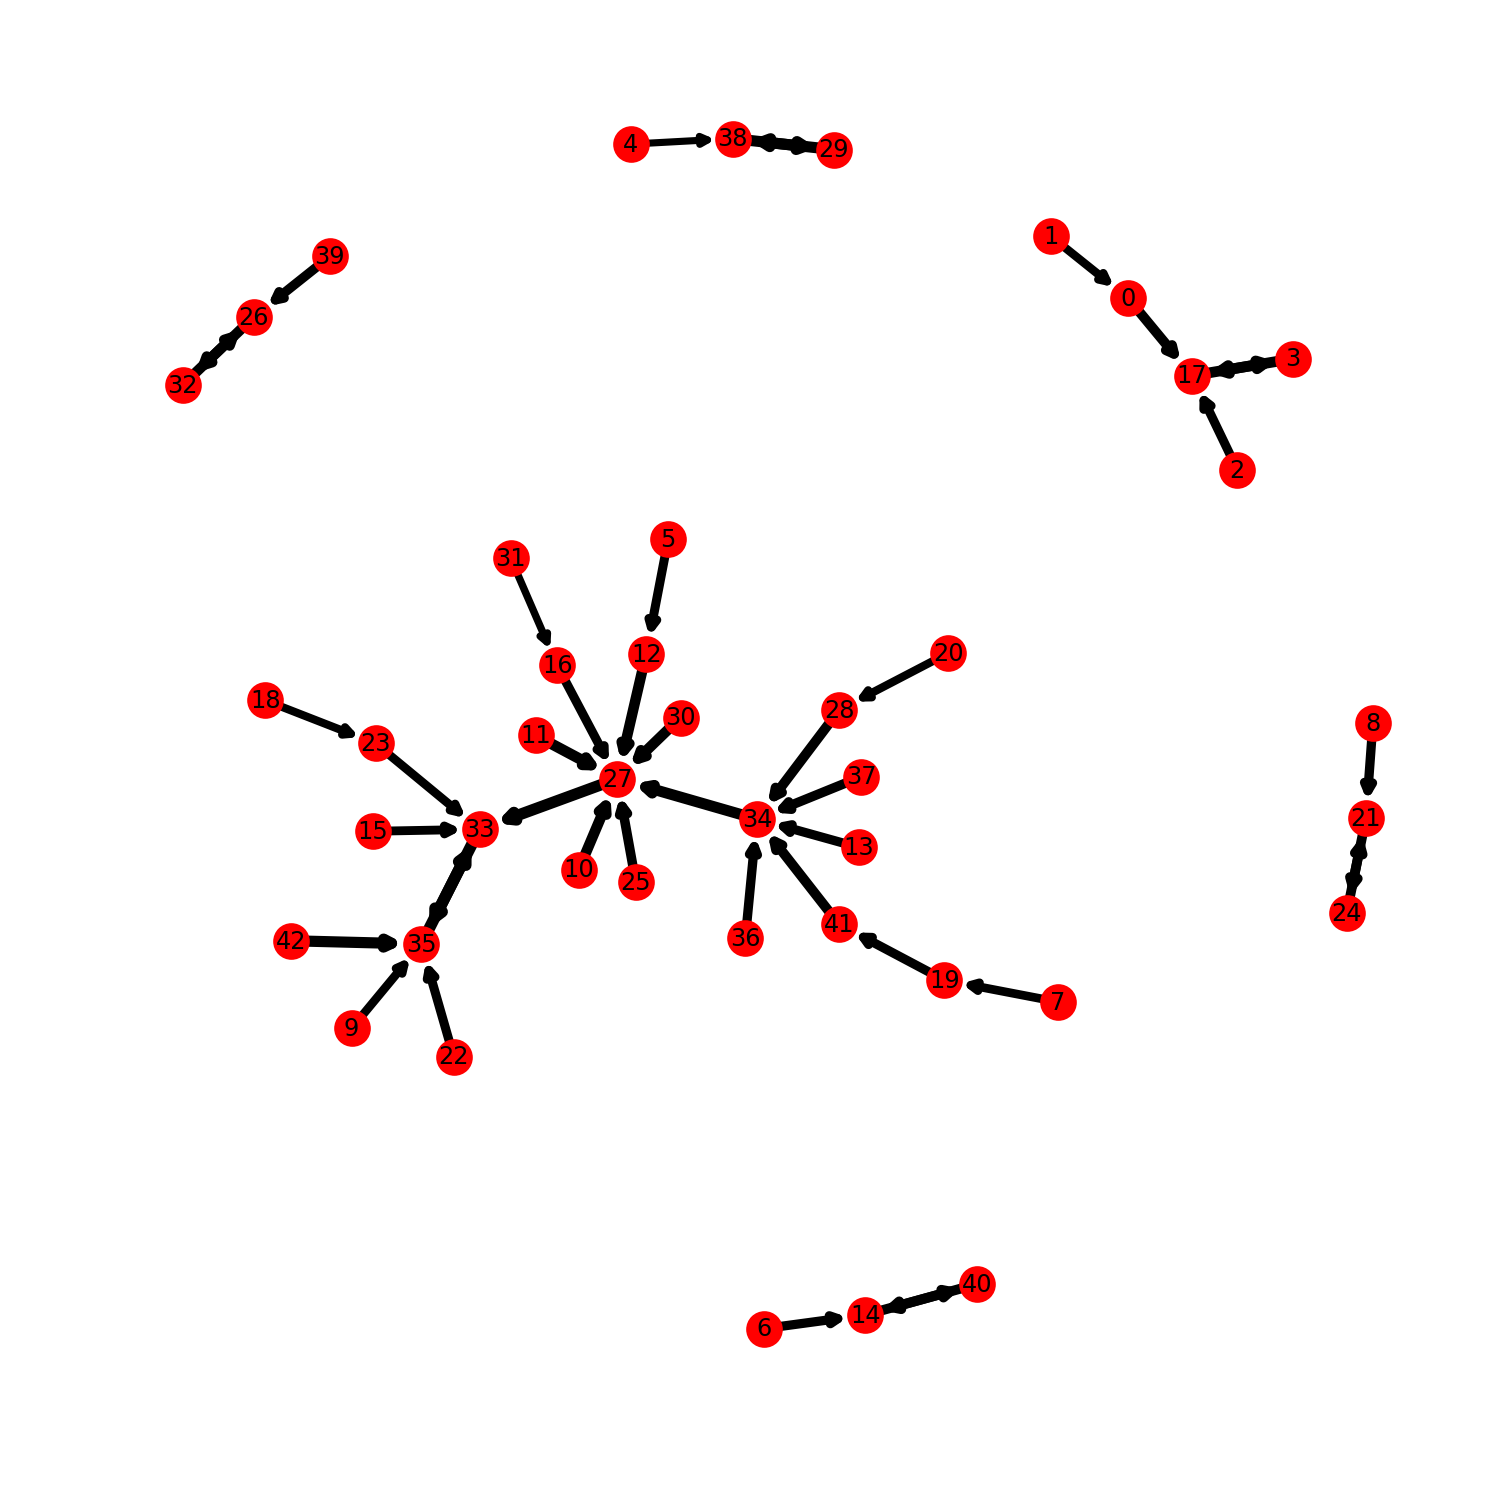

In [14]:
pos = G.layout('kk')
g = nx.DiGraph(G.get_edgelist())
p = list(pos)
plt.figure(figsize=(10, 10))
nx.draw(g, p, node_size=300, width=[max(0, 0.3 - edges[(s, t)]) * 20 + 1 for s, t in g.edges])
nx.draw_networkx_labels(g, p, with_labels=True)
plt.show()

### Definition here

In [6]:
class PairwiseAlignment:
    def __init__(self, a_seq, b_seq):
        self.fcigar = run_edlib(b_seq.lower(), a_seq.lower(), "global").cigar.flatten().string
        self.source, self.target = '', ''
        s_pos, t_pos = 0, 0
        for c in self.fcigar:
            if c == '=' or c == 'X':
                self.source += a_seq[s_pos]
                self.target += b_seq[t_pos]
                s_pos += 1
                t_pos += 1
            elif c == 'I':
                self.source += '-'
                self.target += b_seq[t_pos]
                t_pos += 1
            else:
                self.source += a_seq[s_pos]
                self.target += '-'
                s_pos += 1
        
    def show(self, by_cigar=False):
        if by_cigar:   # standard alignment like BLAST
            print(self.source)
            print(self.fcigar)
            print(self.target)
        else:
            print(''.join([' ' if c == '=' else self.source[i] for i, c in enumerate(self.fcigar)]))
            print(''.join([self.source[i] if c == '=' else ' ' for i, c in enumerate(self.fcigar)]))
            print(''.join([' ' if c == '=' else self.target[i] for i, c in enumerate(self.fcigar)]))

class ExtSeq:
    def __init__(self, in_obj):
        # NOTE: <in_obj> must be 1) a string, 2) a PairwiseAlignment object, or 3) a list of Counter objects
        if type(in_obj) == str:
            self.string = [Counter([c]) for c in in_obj]
            self.size = 1
        elif type(in_obj) == PairwiseAlignment:
            self.string = [Counter([in_obj.source[i], in_obj.target[i]]) for i in range(len(in_obj.fcigar))]
            self.size = 2
        elif type(in_obj) == list:
            self.string = in_obj
            self.size = sum(in_obj[0].values())
        else:
            assert False, "Not supported data type"
    
    def show(self, min_frac=0.65, full=False):
        s = ''.join([c.most_common()[0][0] if c.most_common()[0][1] / self.size >= min_frac else '*' for c in self.string])
        if full:
            s = s.replace('-', '')
        print(s)

    def consensus(self, single=False, full=False, ret_ext=False):
        if ret_ext:
            ret = ExtSeq([Counter({k for k, v in c.items() if v == sorted(c.values(), reverse=True)[0]}) for c in self.string])
        else:
            ret = [{k for k, v in c.items() if v == sorted(c.values(), reverse=True)[0]} for c in self.string]
            if single:
                # NOTE: if there are multiple base possibilities on a position, one base is randomly chosen from them
                ret = ''.join([list(c)[0] for c in ret])
                if full:
                    ret = ret.replace('-', '')
        return ret

def align_ext_seq(es1, es2):
    #if es1.size == 1 and es2.size == 1:
    #    a = run_edlib(es1.consensus(single=True), es2.consensus(single=True), 'global')
    #    return (ExtSeq(PairwiseAlignment(es1.consensus(single=True), es2.consensus(single=True))), a.diff, a.cigar)
    cons1, cons2 = es1.consensus(), es2.consensus()

    dp = np.zeros((len(cons1) + 1, len(cons2) + 1), dtype=int)
    dp_move = np.zeros((len(cons1) + 1, len(cons2) + 1), dtype=int)   # for traceback
    for i in range(1, len(cons1) + 1):
        dp[i][0] = -1 * i
    for j in range(1, len(cons2) + 1):
        dp[0][j] = -1 * j
        dp_move[0][j] = 1   # NOTE: insertion
    for i in range(1, len(cons1) + 1):
        for j in range(1, len(cons2) + 1):
            # NOTE: do NOT move the order of the three scores below
            scores = [dp[i - 1][j] + (0 if '-' in cons1[i - 1] else -1),   # D
                      dp[i][j - 1] + (0 if '-' in cons2[j - 1] else -1),   # I
                      dp[i - 1][j - 1] + (0 if len(cons1[i - 1] & cons2[j - 1]) > 0 else -1)]
            dp[i][j] = max(scores)
            dp_move[i][j] = np.argmax(scores)

    new_string = []
    diff = 0
    cigar = ""
    while i > 0 or j > 0:   # NOTE: Find leftmost alignment here
        # Using direction from which the current cell comes
        if dp_move[i][j] == 0:   # D
            new_string = [es1.string[i - 1] + Counter(['-'] * sum(es2.string[j - 1].values()))] + new_string
            d, c = (0, 'E') if '-' in cons1[i - 1] else (1, 'D')
            i -= 1
        elif dp_move[i][j] == 1:   # I
            new_string = [es2.string[j - 1] + Counter(['-'] * sum(es1.string[i - 1].values()))] + new_string
            d, c = (0, 'J') if '-' in cons2[j - 1] else (1, 'I')
            j -= 1
        else:
            new_string = [es1.string[i - 1] + es2.string[j - 1]] + new_string
            d, c = (0, '=') if len(cons1[i - 1] & cons2[j - 1]) > 0 else (1, 'N')
            i -= 1
            j -= 1
        diff += d
        cigar = c + cigar
    #print(cigar)
    #print(diff, len(new_string))
    diff = diff / len(new_string)
    #print(diff)
    return (ExtSeq(new_string), diff, cigar)

In [398]:
a = PairwiseAlignment(seqs[3], seqs[17])
b = PairwiseAlignment(seqs[33], seqs[35])

In [160]:
a.show()

  --                       g                -             -     -               g    
at  gtagagtatctctgtcgctgtac tcgatcgtatacatga cgctatatgtact agcat ctgtgcgtacagtga caga
  ct                       -                g             g     a               -    


In [161]:
b.show()

             -   -          -                                --                   
atctgtagagtat ctc gtgtctgtag tgatcgatcacatgacgctatgtactagcata  tgtgctacgcagtgacaga
             g   t          c                                gc                   


In [206]:
run_edlib(seqs[3], seqs[17], 'global').diff

0.08235294117647059

In [401]:
align_ext_seq(ExtSeq(seqs[3]), ExtSeq(seqs[17]))[0].consensus()

[{'a'},
 {'t'},
 {'-', 'c'},
 {'-', 't'},
 {'g'},
 {'t'},
 {'a'},
 {'g'},
 {'a'},
 {'g'},
 {'t'},
 {'a'},
 {'t'},
 {'c'},
 {'t'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'c'},
 {'g'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'a'},
 {'c'},
 {'-', 'g'},
 {'t'},
 {'c'},
 {'g'},
 {'a'},
 {'t'},
 {'c'},
 {'g'},
 {'t'},
 {'a'},
 {'t'},
 {'a'},
 {'c'},
 {'a'},
 {'t'},
 {'g'},
 {'a'},
 {'-', 'g'},
 {'c'},
 {'g'},
 {'c'},
 {'t'},
 {'a'},
 {'t'},
 {'a'},
 {'t'},
 {'g'},
 {'t'},
 {'a'},
 {'c'},
 {'t'},
 {'-', 'g'},
 {'a'},
 {'g'},
 {'c'},
 {'a'},
 {'t'},
 {'-', 'a'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'g'},
 {'c'},
 {'g'},
 {'t'},
 {'a'},
 {'c'},
 {'a'},
 {'g'},
 {'t'},
 {'g'},
 {'a'},
 {'-', 'g'},
 {'c'},
 {'a'},
 {'g'},
 {'a'}]

In [220]:
align_ext_seq(ExtSeq(a), ExtSeq(seqs[3]))

(<__main__.ExtSeq at 0x2ba575c5fa20>, 0.0)

In [451]:
units[60].consensus(ret_ext=True).string

[Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'-': 1, 'g': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'c': 1}),
 Counter({'a': 1, 'g': 1}),
 Counter({'-': 1, 't': 1}),
 Counter({'a': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'-': 1, 'g': 1}),
 Counter({'c': 1}),
 Counter({'-': 1, 'g': 1}),
 Counter({'c': 1, '-': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'c': 1, '-': 1}),
 Counter({'g': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'-': 1, 't': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'a': 1, '-': 1}),
 Counter({'c': 1}),
 Counter({'-': 1, 't': 1}),
 Counter({'a': 1}),
 Counter({'-': 1, 'g

In [453]:
align_ext_seq(units[43].consensus(ret_ext=True), units[0].consensus(ret_ext=True))[2]

'====N==N============I=D========I=====I==I=N=======I====II======I============I===DD========='

In [454]:
align_ext_seq(units[43], units[0])[2]

'====N==N============I=D========I=====I==I=N=======I====II======I============I===DD========='

In [455]:
units[43].consensus(ret_ext=True).size

1

In [456]:
units[0].consensus(ret_ext=True).consensus()

[{'a'},
 {'t'},
 {'c'},
 {'t'},
 {'c'},
 {'t'},
 {'a'},
 {'c'},
 {'a'},
 {'g'},
 {'t'},
 {'a'},
 {'t'},
 {'c'},
 {'t'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'c'},
 {'g'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'a'},
 {'g'},
 {'c'},
 {'t'},
 {'c'},
 {'g'},
 {'a'},
 {'t'},
 {'c'},
 {'g'},
 {'t'},
 {'a'},
 {'t'},
 {'a'},
 {'c'},
 {'g'},
 {'c'},
 {'a'},
 {'t'},
 {'g'},
 {'a'},
 {'c'},
 {'g'},
 {'t'},
 {'c'},
 {'t'},
 {'a'},
 {'t'},
 {'a'},
 {'t'},
 {'g'},
 {'t'},
 {'a'},
 {'c'},
 {'t'},
 {'a'},
 {'c'},
 {'g'},
 {'c'},
 {'a'},
 {'t'},
 {'a'},
 {'c'},
 {'t'},
 {'g'},
 {'t'},
 {'g'},
 {'c'},
 {'g'},
 {'t'},
 {'a'},
 {'c'},
 {'a'},
 {'g'},
 {'t'},
 {'g'},
 {'a'},
 {'c'},
 {'a'},
 {'g'},
 {'a'}]

In [423]:
units[43].string

[Counter({'a': 2}),
 Counter({'t': 2}),
 Counter({'c': 2}),
 Counter({'t': 2}),
 Counter({'g': 2}),
 Counter({'t': 2}),
 Counter({'a': 2}),
 Counter({'g': 2}),
 Counter({'a': 2}),
 Counter({'g': 2}),
 Counter({'t': 2}),
 Counter({'a': 2}),
 Counter({'t': 2}),
 Counter({'-': 1, 'g': 1}),
 Counter({'c': 2}),
 Counter({'t': 2}),
 Counter({'c': 2}),
 Counter({'-': 1, 't': 1}),
 Counter({'g': 2}),
 Counter({'t': 2}),
 Counter({'g': 2}),
 Counter({'t': 2}),
 Counter({'c': 2}),
 Counter({'t': 2}),
 Counter({'g': 2}),
 Counter({'t': 2}),
 Counter({'a': 2}),
 Counter({'g': 2}),
 Counter({'-': 1, 'c': 1}),
 Counter({'t': 2}),
 Counter({'g': 2}),
 Counter({'a': 2}),
 Counter({'t': 2}),
 Counter({'c': 2}),
 Counter({'g': 2}),
 Counter({'a': 2}),
 Counter({'t': 2}),
 Counter({'c': 2}),
 Counter({'a': 2}),
 Counter({'c': 2}),
 Counter({'a': 2}),
 Counter({'t': 2}),
 Counter({'g': 2}),
 Counter({'a': 2}),
 Counter({'c': 2}),
 Counter({'g': 2}),
 Counter({'c': 2}),
 Counter({'t': 2}),
 Counter({'a': 2

In [425]:
units[0].string

[Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'c': 1}),
 Counter({'a': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'g': 1}),
 Counter({'c': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'a': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'c': 1}),
 Counter({'a': 1}),
 Counter({'t': 1}),
 Counter({'g': 1}),
 Counter({'a': 1}),
 Counter({'c': 1}),
 Counter({'g': 1}),
 Counter({'t': 1}),
 Counter({'c': 1}),


In [457]:
units = [ExtSeq(u) for u in seqs]

valid_indice = set(range(len(units)))
breakdown = {i: set([i]) for i in range(len(units))}
while True:
    # recalculate the distance matrix
    dist_mat = np.array([[np.inf if i == j else align_ext_seq(units[i].consensus(ret_ext=True), units[j].consensus(ret_ext=True))[1] for j in range(len(units)) if j in valid_indice] for i in range(len(units)) if i in valid_indice])
    for i in range(dist_mat.shape[0]):
        for j in range(i):
            dist_mat[i][j] = dist_mat[j][i]

    # find closest pair
    for i in range(dist_mat.shape[0]):
        dist_mat[i][i] = np.inf
    i, j = np.unravel_index(np.argmin(dist_mat), dist_mat.shape)
    d = dist_mat[i][j]
    if d >= 0.15:
        break
    map_table = {i: val for i, val in enumerate(sorted(valid_indice))}
    i, j = map_table[i], map_table[j]
    if i > j:
        i, j = j, i
    i, j = min([i, j]), max([i, j])
    new_index = len(units)
    logger.info(f"merge {i}({len(breakdown[i])}) and {j}({len(breakdown[j])}) (d={d:.2}) -> {new_index}")

    # merge them
    valid_indice -= set([i, j])
    valid_indice.add(new_index)
    breakdown[new_index] = breakdown[i] | breakdown[j]
    ui, uj = units[i], units[j]
    PairwiseAlignment(ui.consensus(single=True, full=True), uj.consensus(single=True, full=True)).show()
    uij, diff, cigar = align_ext_seq(ui, uj)
    units.append(uij)
    print(round(diff, 3))

[I 190517 11:41:12 <ipython-input-457-b5873066366b>:25] merge 33(1) and 35(1) (d=0.061) -> 43


             -   -          -                                --                   
atctgtagagtat ctc gtgtctgtag tgatcgatcacatgacgctatgtactagcata  tgtgctacgcagtgacaga
             g   t          c                                gc                   
0.061


[I 190517 11:42:56 <ipython-input-457-b5873066366b>:25] merge 42(1) and 43(2) (d=0.047) -> 44


           g    t                             g                 a        t         
atctgtagagt tctc gtgtctgtagctgatcgatcacatgacgc tatgtactagcatactg tgctacgc agtgacaga
           a    -                             -                 -        -         
0.047


[I 190517 11:44:34 <ipython-input-457-b5873066366b>:25] merge 38(1) and 44(3) (d=0.057) -> 45


         ta                 -                  ta                                  
atctgtaga  gtatctctgtgtctgta ctgatcgatcacatgacg  tatgtactagcatactgtgctacgcagtgacaga
         --                 g                  c-                                  
0.057


[I 190517 11:46:09 <ipython-input-457-b5873066366b>:25] merge 27(1) and 45(4) (d=0.057) -> 46


               --         -                                          --         
atctgtagagtatct  gtgtctgta ctgatcgatcacatgacgctatgtactagcatactgtgctac  agtgacaga
               ct         g                                          gc         
0.057


[I 190517 11:47:38 <ipython-input-457-b5873066366b>:25] merge 12(1) and 46(5) (d=0.067) -> 47


                                    -                      -         a t  a -    
atctgtagagtatctctgtgtctgtagctgatcgat acatgacgctatgtactagcat ctgtgctac g ag g caga
                                    c                      a         - c  t a    
0.067


[I 190517 11:49:04 <ipython-input-457-b5873066366b>:25] merge 29(1) and 47(6) (d=0.075) -> 48


         ta                 -            -                          g   --         
atctgtaga  gtatctctgtgtctgta ctgatcgatcac tgacgctatgtactagcatactgtgc tac  agtgacaga
         --                 g            a                          -   gc         
0.075


[I 190517 11:50:26 <ipython-input-457-b5873066366b>:25] merge 34(1) and 48(7) (d=0.073) -> 49


                          -         g            at               a     --         
atctgtagagtatctctgtgtctgta ctgatcgat acatgacgctat  gtactagcatactgt gctac  agtgacaga
                          g         c            --               -     gc         
0.073


[I 190517 11:51:43 <ipython-input-457-b5873066366b>:25] merge 30(1) and 49(8) (d=0.061) -> 50


             a        a                                t   g         -     ta    
atctgtagagtat tctgtgtc gtactgatcgatcacatgacgctatgtactag cat ctgtgctac agtga  caga
             c        t                                -   a         c     --    
0.061


[I 190517 11:52:56 <ipython-input-457-b5873066366b>:25] merge 24(1) and 50(9) (d=0.076) -> 51


                                     g     gagt                -            -  t   
atctgtagagtatctctgtgtctgtactgatcgatca catga    cgctatgtactagcat ctgtgctacagt ac aga
                                     -     ----                a            g  -   
0.076


[I 190517 11:54:06 <ipython-input-457-b5873066366b>:25] merge 13(1) and 51(10) (d=0.073) -> 52


  g     t     g                c                gc        -                    -  
at ctgta agtat ctctgtgtctgtactg atcgatcacatgacgc  tatgtact gcatactgtgctacagtgac ga
  -     g     -                -                --        a                    a  
0.073


[I 190517 11:55:12 <ipython-input-457-b5873066366b>:25] merge 21(1) and 52(11) (d=0.07) -> 53


                    -     -           gc       gc g            -                  
atctgtagagtatctctgtg ctgta tgatcgatcac  atgacgc  t atgtactagcat ctgtgctacagtgacaga
                    t     c           --       -- -            a                  
0.07


[I 190517 11:56:14 <ipython-input-457-b5873066366b>:25] merge 11(1) and 53(12) (d=0.068) -> 54


  a c          --           -  -      gc                                       
at t tagagtatct  gtgtctgtact at gatcac  atgacgctatgtactagcatactgtgctacagtgacaga
  c g          ct           g  c      --                                       
0.068


[I 190517 11:57:13 <ipython-input-457-b5873066366b>:25] merge 26(1) and 54(13) (d=0.072) -> 55


                     gt          g    at             at                -        g    
atctgtagagtatctctgtgt  ctgtactgat cgat  cacatgacgctat  gtactagcatactgtg tacagtga caga
                     --          -    --             --                c        -    
0.072


[I 190517 11:58:08 <ipython-input-457-b5873066366b>:25] merge 10(1) and 55(14) (d=0.068) -> 56


         t      --                  at       g   gc        c                        
atctgtaga gtatct  gtgtctgtactgatcgat  cacatga cgc  tatgtact agcatactgtgctacagtgacaga
         -      ct                  --       -   --        -                        
0.068


[I 190517 11:59:01 <ipython-input-457-b5873066366b>:25] merge 5(1) and 56(15) (d=0.07) -> 57


                          g             ca  tg            c  ag t                 g    
atctgtagagtatctctgtgtctgta ctgatcgatcaca  tg  acgctatgtact ag  c atactgtgctacagtga caga
                          -             --  --            -  -- -                 -    
0.07


[I 190517 11:59:50 <ipython-input-457-b5873066366b>:25] merge 7(1) and 57(16) (d=0.066) -> 58


                                      t g at c tga         g                     -    
atctgtagagtatctctgtgtctgtactgatcgatcac a t  g a   cgctatgta ctagcatactgtgctacagtg caga
                                      - - -- - ---         -                     a    
0.066


[I 190517 12:00:36 <ipython-input-457-b5873066366b>:25] merge 19(1) and 58(17) (d=0.062) -> 59


                                  c a tc         gcg      ga        g                 
atctgtagagtatctctgtgtctgtactgatcga t c  acatgacgc   tatgta  ctagcata tgtgctacagtgacaga
                                  - - --         ---      --        c                 
0.062


[I 190517 12:01:19 <ipython-input-457-b5873066366b>:25] merge 22(1) and 59(18) (d=0.059) -> 60


                         gt       t                        gc        tg    gc   -     
atctgtagagtatctctgtgtctgt  actgatc gatcacatgacgctatgtactagc  atactgtg  ctac  agt acaga
                         --       -                        --        --    --   g     
0.059


[I 190517 12:01:59 <ipython-input-457-b5873066366b>:25] merge 40(1) and 60(19) (d=0.056) -> 61


                                  g    gcgc      a       -                gc     g    
atctgtagagtatctctgtgtctgtactgatcga tcac    atgacg ctatgta tagcatactgtgctac  agtga caga
                                  -    ----      -       c                --     -    
0.056


[I 190517 12:02:37 <ipython-input-457-b5873066366b>:25] merge 17(1) and 61(20) (d=0.054) -> 62


                   c -       c     t  -      g      at     g            g            
atctgtagagtatctctgt g ctgtact gatcg at acatga cgctat  gtact agcatactgtgc tacagtgacaga
                   - t       -     -  c      -      --     -            -            
0.054


[I 190517 12:03:11 <ipython-input-457-b5873066366b>:25] merge 25(1) and 62(21) (d=0.052) -> 63


       c            --               t         gc   at   -              -          
atctgta gagtatctctgt  ctgtactgatcgatc acatgacgc  tat  gta tagcatactgtgct cagtgacaga
       -            gt               -         --   --   c              a          
0.052


KeyboardInterrupt: 

In [ ]:
units = [ExtSeq(u) for u in seqs]

valid_indice = set(range(len(units)))
breakdown = {i: set([i]) for i in range(len(units))}
while True:
    # recalculate the distance matrix
    dist_mat = np.array([[np.inf if i == j else align_ext_seq(units[i].consensus(ret_ext=True), units[j].consensus(ret_ext=True))[1] for j in range(len(units)) if j in valid_indice] for i in range(len(units)) if i in valid_indice])
    for i in range(dist_mat.shape[0]):
        for j in range(i):
            dist_mat[i][j] = dist_mat[j][i]

    # find closest pair
    for i in range(dist_mat.shape[0]):
        dist_mat[i][i] = np.inf
    i, j = np.unravel_index(np.argmin(dist_mat), dist_mat.shape)
    d = dist_mat[i][j]
    if d >= 0.15:
        break
    map_table = {i: val for i, val in enumerate(sorted(valid_indice))}
    i, j = map_table[i], map_table[j]
    if i > j:
        i, j = j, i
    i, j = min([i, j]), max([i, j])
    new_index = len(units)
    logger.info(f"merge {i}({len(breakdown[i])}) and {j}({len(breakdown[j])}) (d={d:.2}) -> {new_index}")

    # merge them
    valid_indice -= set([i, j])
    valid_indice.add(new_index)
    breakdown[new_index] = breakdown[i] | breakdown[j]
    ui, uj = units[i], units[j]
    PairwiseAlignment(ui.consensus(single=True, full=True), uj.consensus(single=True, full=True)).show()
    uij, diff, cigar = align_ext_seq(ui, uj)
    units.append(uij)
    print(uij.string)

[I 190517 12:05:09 <ipython-input-458-42464d379ae8>:25] merge 33(1) and 35(1) (d=0.061) -> 43


             -   -          -                                --                   
atctgtagagtat ctc gtgtctgtag tgatcgatcacatgacgctatgtactagcata  tgtgctacgcagtgacaga
             g   t          c                                gc                   
[Counter({'a': 2}), Counter({'t': 2}), Counter({'c': 2}), Counter({'t': 2}), Counter({'g': 2}), Counter({'t': 2}), Counter({'a': 2}), Counter({'g': 2}), Counter({'a': 2}), Counter({'g': 2}), Counter({'t': 2}), Counter({'a': 2}), Counter({'t': 2}), Counter({'g': 1, '-': 1}), Counter({'c': 2}), Counter({'t': 2}), Counter({'c': 2}), Counter({'t': 1, '-': 1}), Counter({'g': 2}), Counter({'t': 2}), Counter({'g': 2}), Counter({'t': 2}), Counter({'c': 2}), Counter({'t': 2}), Counter({'g': 2}), Counter({'t': 2}), Counter({'a': 2}), Counter({'g': 2}), Counter({'c': 1, '-': 1}), Counter({'t': 2}), Counter({'g': 2}), Counter({'a': 2}), Counter({'t': 2}), Counter({'c': 2}), Counter({'g': 2}), Counter({'a': 2}), Counter({'t': 2}), Counter({'c': 2}), Coun

[I 190517 12:06:52 <ipython-input-458-42464d379ae8>:25] merge 42(1) and 43(2) (d=0.047) -> 44


           g    t                             g                 a        t         
atctgtagagt tctc gtgtctgtagctgatcgatcacatgacgc tatgtactagcatactg tgctacgc agtgacaga
           a    -                             -                 -        -         
[Counter({'a': 3}), Counter({'t': 3}), Counter({'c': 3}), Counter({'t': 3}), Counter({'g': 3}), Counter({'t': 3}), Counter({'a': 3}), Counter({'g': 3}), Counter({'a': 3}), Counter({'g': 3}), Counter({'t': 3}), Counter({'a': 2, 'g': 1}), Counter({'t': 3}), Counter({'-': 2, 'g': 1}), Counter({'c': 3}), Counter({'t': 3}), Counter({'c': 3}), Counter({'t': 2, '-': 1}), Counter({'g': 3}), Counter({'t': 3}), Counter({'g': 3}), Counter({'t': 3}), Counter({'c': 3}), Counter({'t': 3}), Counter({'g': 3}), Counter({'t': 3}), Counter({'a': 3}), Counter({'g': 3}), Counter({'c': 2, '-': 1}), Counter({'t': 3}), Counter({'g': 3}), Counter({'a': 3}), Counter({'t': 3}), Counter({'c': 3}), Counter({'g': 3}), Counter({'a': 3}), Counter({'t': 3}), Counter({'c'

[I 190517 12:08:30 <ipython-input-458-42464d379ae8>:25] merge 38(1) and 44(3) (d=0.057) -> 45


         ta                 -                  ta                                  
atctgtaga  gtatctctgtgtctgta ctgatcgatcacatgacg  tatgtactagcatactgtgctacgcagtgacaga
         --                 g                  c-                                  
[Counter({'a': 4}), Counter({'t': 4}), Counter({'c': 4}), Counter({'t': 4}), Counter({'g': 4}), Counter({'t': 4}), Counter({'a': 4}), Counter({'g': 4}), Counter({'a': 4}), Counter({'-': 3, 't': 1}), Counter({'-': 3, 'a': 1}), Counter({'g': 4}), Counter({'t': 4}), Counter({'a': 3, 'g': 1}), Counter({'t': 4}), Counter({'-': 3, 'g': 1}), Counter({'c': 4}), Counter({'t': 4}), Counter({'c': 4}), Counter({'t': 3, '-': 1}), Counter({'g': 4}), Counter({'t': 4}), Counter({'g': 4}), Counter({'t': 4}), Counter({'c': 4}), Counter({'t': 4}), Counter({'g': 4}), Counter({'t': 4}), Counter({'a': 4}), Counter({'g': 3, '-': 1}), Counter({'c': 3, '-': 1}), Counter({'t': 4}), Counter({'g': 4}), Counter({'a': 4}), Counter({'t': 4}), Counter({'c': 4}), Counter

[I 190517 12:10:06 <ipython-input-458-42464d379ae8>:25] merge 27(1) and 45(4) (d=0.057) -> 46


               --         -                                          --         
atctgtagagtatct  gtgtctgta ctgatcgatcacatgacgctatgtactagcatactgtgctac  agtgacaga
               ct         g                                          gc         
[Counter({'a': 5}), Counter({'t': 5}), Counter({'c': 5}), Counter({'t': 5}), Counter({'g': 5}), Counter({'t': 5}), Counter({'a': 5}), Counter({'g': 5}), Counter({'a': 5}), Counter({'-': 4, 't': 1}), Counter({'-': 4, 'a': 1}), Counter({'g': 5}), Counter({'t': 5}), Counter({'a': 4, 'g': 1}), Counter({'t': 5}), Counter({'-': 4, 'g': 1}), Counter({'c': 5}), Counter({'t': 5}), Counter({'c': 4, '-': 1}), Counter({'t': 3, '-': 2}), Counter({'g': 5}), Counter({'t': 5}), Counter({'g': 5}), Counter({'t': 5}), Counter({'c': 5}), Counter({'t': 5}), Counter({'g': 5}), Counter({'t': 5}), Counter({'a': 5}), Counter({'g': 3, '-': 2}), Counter({'c': 4, '-': 1}), Counter({'t': 5}), Counter({'g': 5}), Counter({'a': 5}), Counter({'t': 5}), Counter({'c': 5}), Counter(

[I 190517 12:11:36 <ipython-input-458-42464d379ae8>:25] merge 12(1) and 46(5) (d=0.067) -> 47


                                    -                      -         a t  a -    
atctgtagagtatctctgtgtctgtagctgatcgat acatgacgctatgtactagcat ctgtgctac g ag g caga
                                    c                      a         - c  t a    
[Counter({'a': 6}), Counter({'t': 6}), Counter({'c': 6}), Counter({'t': 6}), Counter({'g': 6}), Counter({'t': 6}), Counter({'a': 6}), Counter({'g': 6}), Counter({'a': 6}), Counter({'-': 5, 't': 1}), Counter({'-': 5, 'a': 1}), Counter({'g': 6}), Counter({'t': 6}), Counter({'a': 5, 'g': 1}), Counter({'t': 6}), Counter({'-': 5, 'g': 1}), Counter({'c': 6}), Counter({'t': 6}), Counter({'c': 5, '-': 1}), Counter({'t': 4, '-': 2}), Counter({'g': 6}), Counter({'t': 6}), Counter({'g': 6}), Counter({'t': 6}), Counter({'c': 6}), Counter({'t': 6}), Counter({'g': 6}), Counter({'t': 6}), Counter({'a': 6}), Counter({'g': 4, '-': 2}), Counter({'c': 5, '-': 1}), Counter({'t': 6}), Counter({'g': 6}), Counter({'a': 6}), Counter({'t': 6}), Counter({'c': 6}), Count

[I 190517 12:13:03 <ipython-input-458-42464d379ae8>:25] merge 29(1) and 47(6) (d=0.075) -> 48


         ta                 -            -                          g   --         
atctgtaga  gtatctctgtgtctgta ctgatcgatcac tgacgctatgtactagcatactgtgc tac  agtgacaga
         --                 g            a                          -   gc         
[Counter({'a': 7}), Counter({'t': 7}), Counter({'c': 7}), Counter({'t': 7}), Counter({'g': 7}), Counter({'t': 7}), Counter({'a': 7}), Counter({'g': 7}), Counter({'a': 7}), Counter({'-': 6, 't': 1}), Counter({'-': 6, 'a': 1}), Counter({'-': 6, 't': 1}), Counter({'-': 6, 'a': 1}), Counter({'g': 7}), Counter({'t': 7}), Counter({'a': 6, 'g': 1}), Counter({'t': 7}), Counter({'-': 6, 'g': 1}), Counter({'c': 7}), Counter({'t': 7}), Counter({'c': 6, '-': 1}), Counter({'t': 5, '-': 2}), Counter({'g': 7}), Counter({'t': 7}), Counter({'g': 7}), Counter({'t': 7}), Counter({'c': 7}), Counter({'t': 7}), Counter({'g': 7}), Counter({'t': 7}), Counter({'a': 7}), Counter({'g': 4, '-': 3}), Counter({'c': 6, '-': 1}), Counter({'t': 7}), Counter({'g': 7}), Co

In [288]:
units = [ExtSeq(u) for u in seqs]

In [315]:
dist_mat = np.array([[np.inf if i == j else align_ext_seq(units[i], units[j])[1] for j in range(len(units))] for i in range(len(units))])

In [316]:
for i in range(len(units)):
    for j in range(i):
        dist_mat[i][j] = dist_mat[j][i]

In [317]:
dist_mat

array([[       inf, 0.17894737, 0.25263158, ..., 0.14583333, 0.16494845,
        0.13      ],
       [0.17894737,        inf, 0.25      , ..., 0.17021277, 0.17525773,
        0.09375   ],
       [0.25263158, 0.25      ,        inf, ..., 0.18478261, 0.18085106,
        0.17525773],
       ...,
       [0.14583333, 0.17021277, 0.18478261, ...,        inf, 0.06382979,
        0.09183673],
       [0.16494845, 0.17525773, 0.18085106, ..., 0.06382979,        inf,
        0.0990099 ],
       [0.13      , 0.09375   , 0.17525773, ..., 0.09183673, 0.0990099 ,
               inf]])

In [318]:
best_units = Counter()
edges = {}   # {(source, target): dist}
for i in range(len(units)):
    best_unit = np.argmin(dist_mat[i])
    best_units[best_unit] += 1
    edges[(i, best_unit)] = dist_mat[i][best_unit]
#seed = best_units.most_common()[0][0]
G = ig.Graph.DictList(edges=(dict(source=s, target=t) for s, t in edges.keys()),
                      vertices=(dict(name=i) for i in range(len(units))), directed=True)

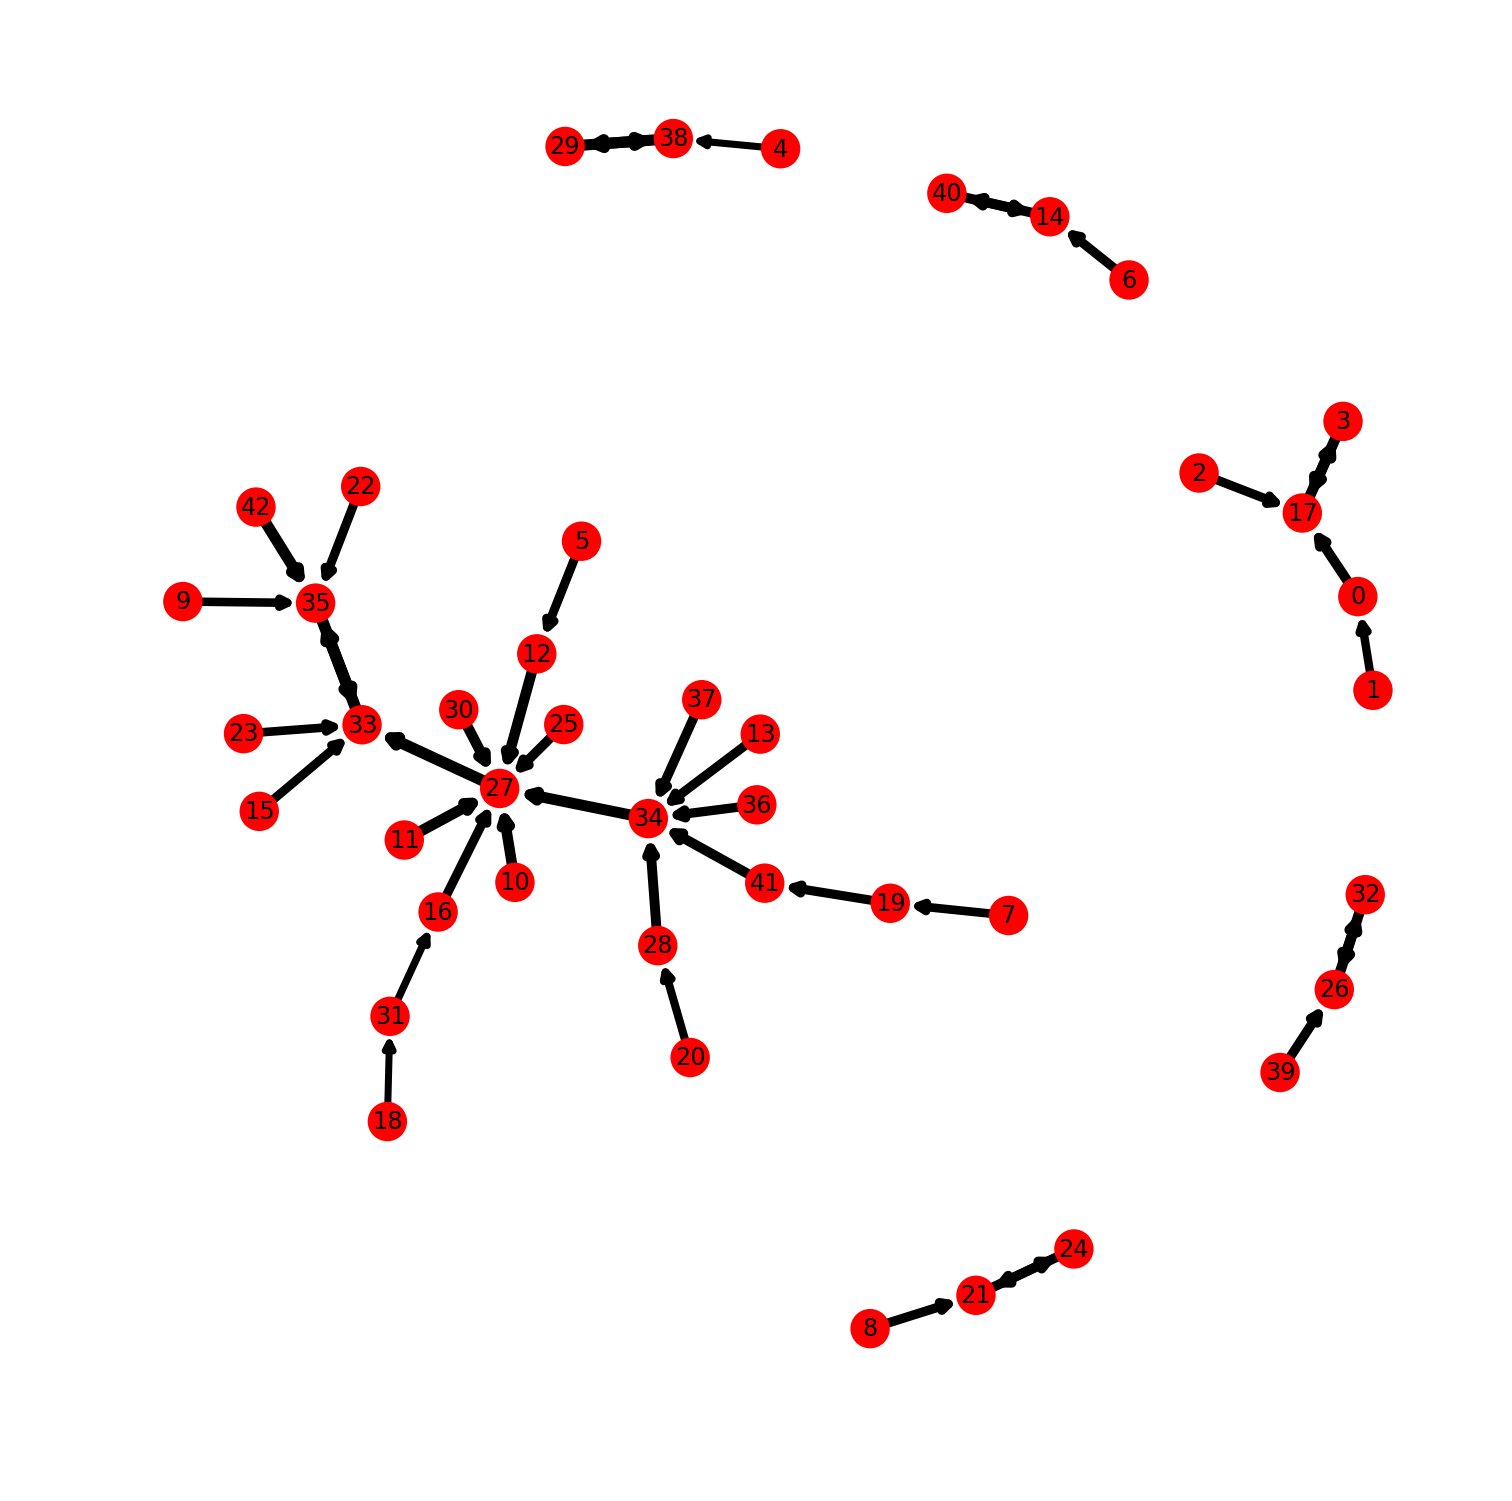

In [294]:
pos = G.layout('kk')
g = nx.DiGraph(G.get_edgelist())
p = list(pos)
plt.figure(figsize=(10, 10))
nx.draw(g, p, node_size=[300 * units[v].size for v in g.nodes], width=[max(0, 0.3 - edges[(s, t)]) * 20 + 1 for s, t in g.edges])
nx.draw_networkx_labels(g, p, with_labels=True)
plt.show()

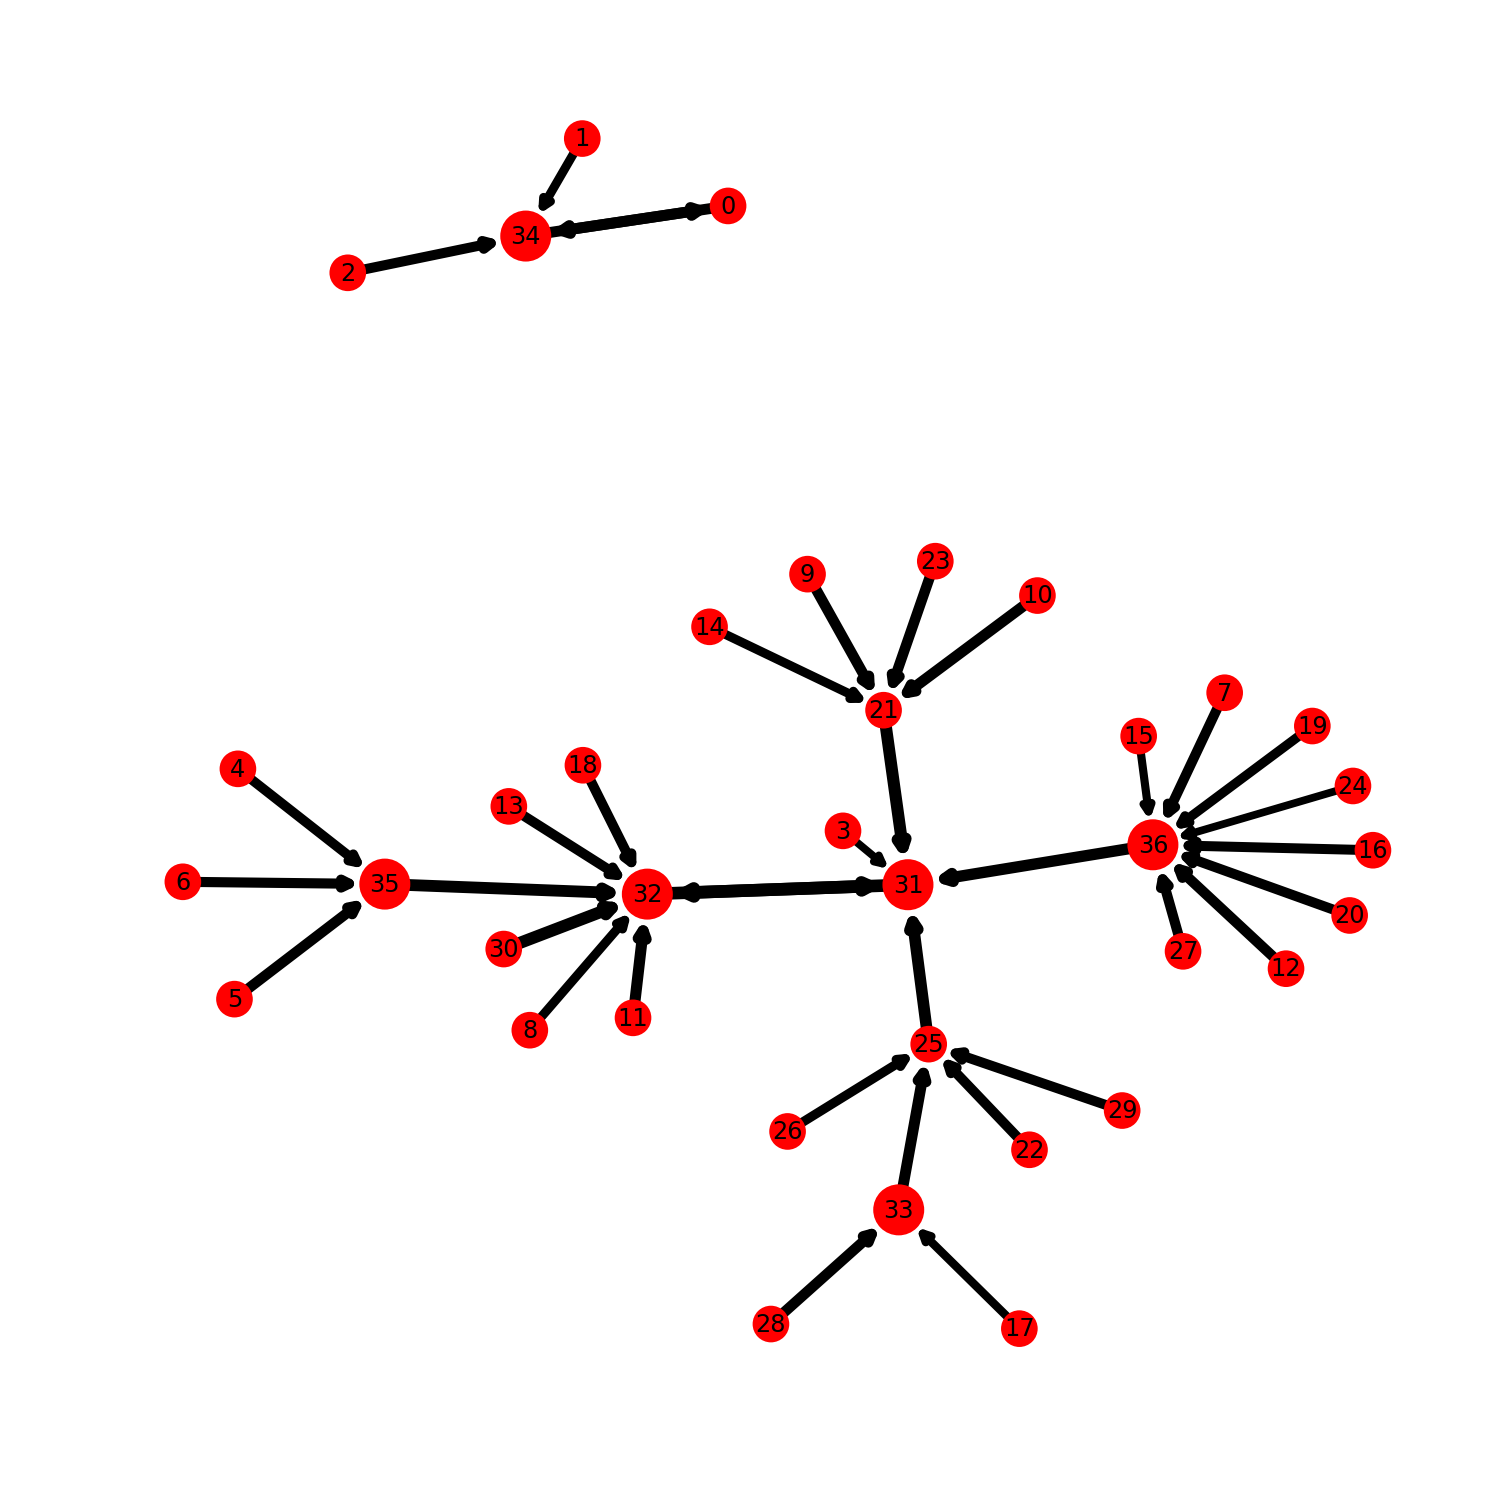

In [308]:
pos = G.layout('kk')
g = nx.DiGraph(G.get_edgelist())
p = list(pos)
plt.figure(figsize=(10, 10))
nx.draw(g, p, node_size=[300 * units[v].size for v in g.nodes], width=[max(0, 0.3 - edges[(s, t)]) * 20 + 1 for s, t in g.edges])
nx.draw_networkx_labels(g, p, with_labels=True)
plt.show()

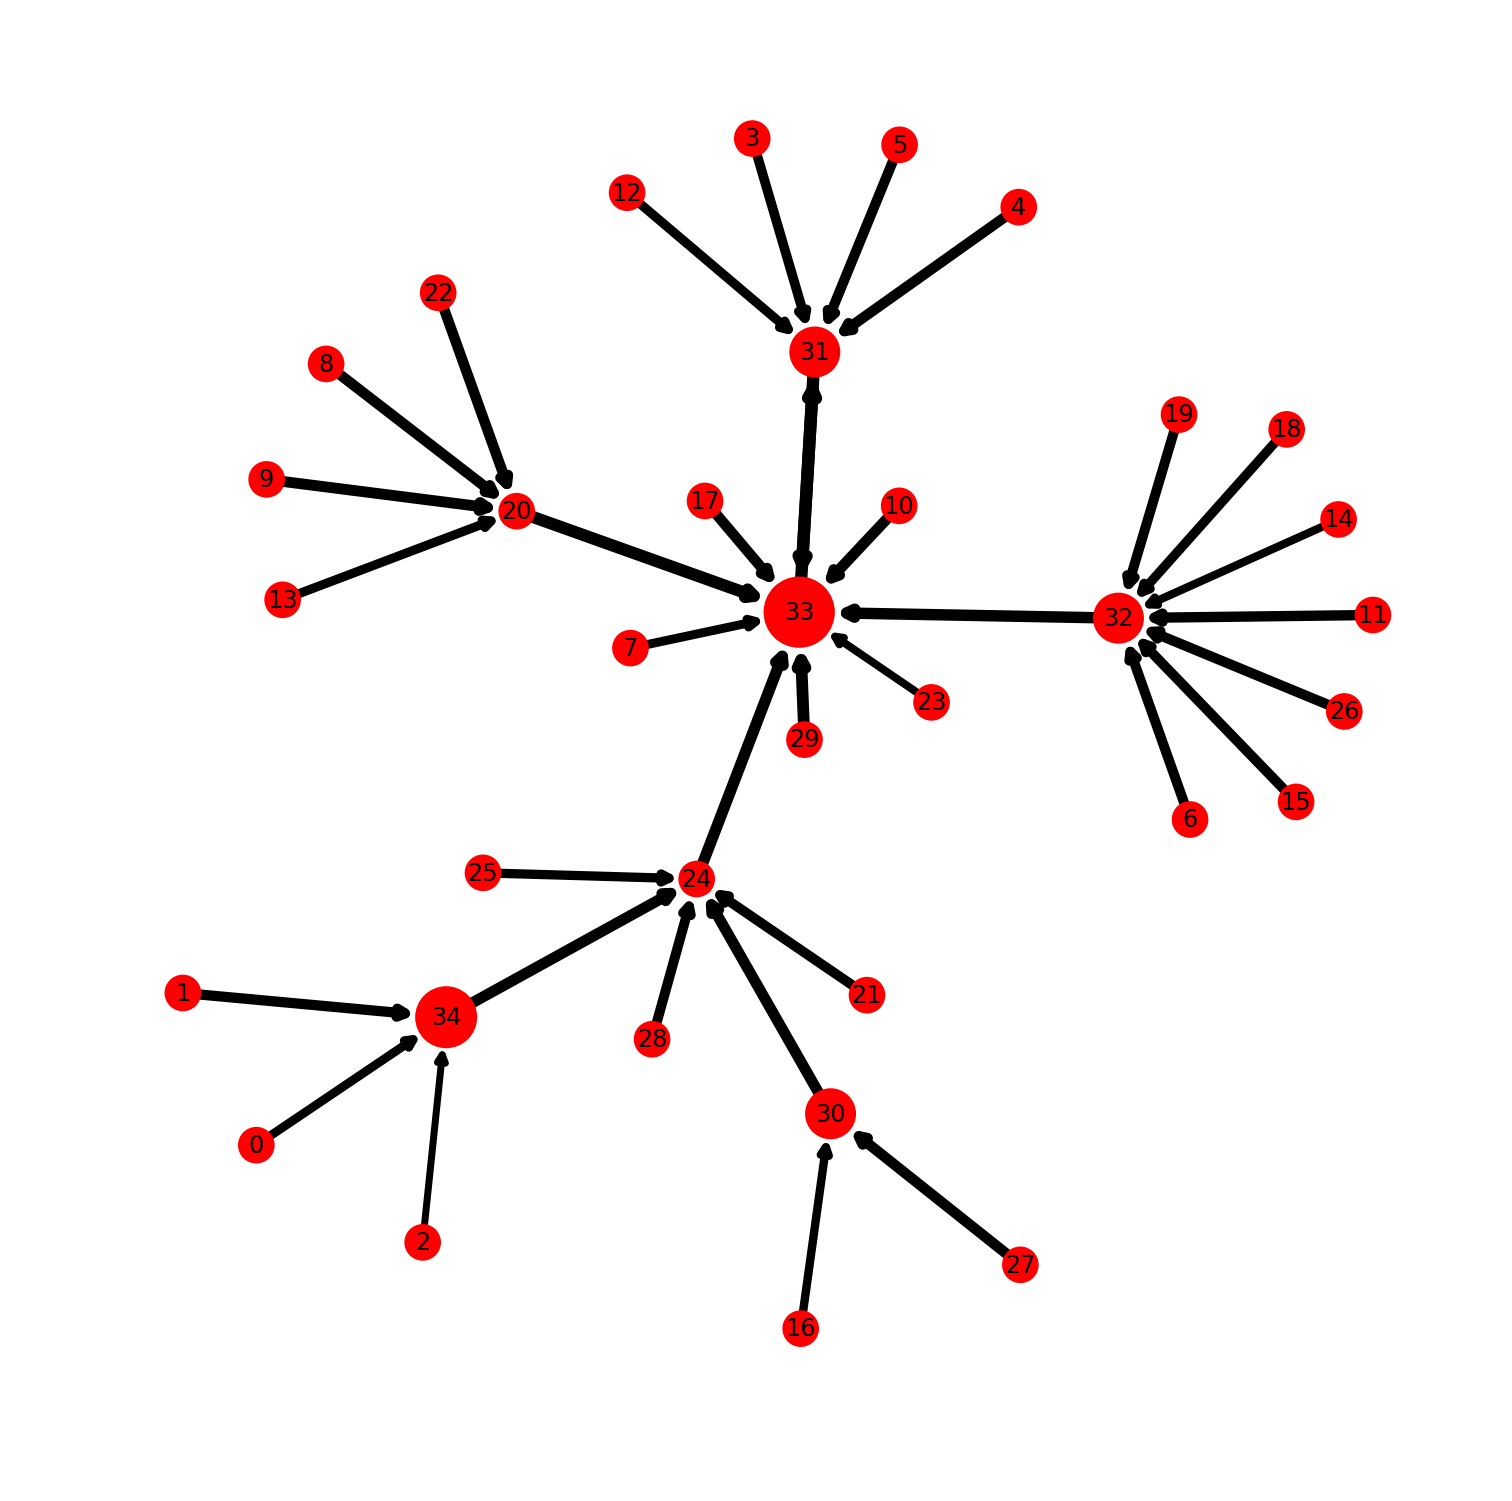

In [319]:
pos = G.layout('kk')
g = nx.DiGraph(G.get_edgelist())
p = list(pos)
plt.figure(figsize=(10, 10))
nx.draw(g, p, node_size=[300 * units[v].size for v in g.nodes], width=[max(0, 0.3 - edges[(s, t)]) * 20 + 1 for s, t in g.edges])
nx.draw_networkx_labels(g, p, with_labels=True)
plt.show()

In [309]:
bidirected_edges = {(min(edge), max(edge)) for edge in edges.keys() if (edge[1], edge[0]) in edges}

In [310]:
bidirected_edges

{(0, 34), (31, 32)}

In [311]:
remove_edges = {e for edge in bidirected_edges for e in edge}

In [312]:
new_units = [units[i] for i in range(len(units)) if i not in remove_edges]

In [313]:
for i, j in bidirected_edges:
    ui, uj = units[i], units[j]
    uij, diff = align_ext_seq(ui, uj)
    print(diff)
    new_units.append(uij)

0.03488372093023256
0.07777777777777778


In [314]:
units = new_units

In [ ]:
# とりあえず単純にExtSeq.consensusで置き換えながらやる(本当はn=2の時とかによくないのであとで変える)

in_seqs = copy.copy(seqs)
valid_indice = set(range(len(in_seqs)))
breakdown = {i: set([i]) for i in range(len(in_seqs))}
while True:
    # recalculate the distance matrix
    c = ClusteringSeqs(pd.Series([u if type(u) == str
                                  else u.consensus(single=True, full=True)
                                  for i, u in enumerate(in_seqs)
                                  if i in valid_indice]))
    c.calc_dist_mat()
    #c.dendrogram()
    logger.info(f"ext seq = {[i for i, u in enumerate(in_seqs) if i in valid_indice and type(u) == ExtSeq]}")

    # find closest pair
    for i in range(c.s_dist_mat.shape[0]):
        c.s_dist_mat[i][i] = np.inf
    i, j = np.unravel_index(np.argmin(c.s_dist_mat), c.s_dist_mat.shape)
    d = c.s_dist_mat[i][j]
    if d >= 0.1:
        break
    map_table = {i: val for i, val in enumerate(sorted(valid_indice))}
    i, j = map_table[i], map_table[j]
    if i > j:
        i, j = j, i
    i, j = min([i, j]), max([i, j])
    new_index = len(in_seqs)
    logger.info(f"merge {i}({len(breakdown[i])}) and {j}({len(breakdown[j])}) (d={d:.2}) -> {new_index}")

    # merge them
    valid_indice -= set([i, j])
    valid_indice.add(new_index)
    breakdown[new_index] = breakdown[i] | breakdown[j]
    ui, uj = in_seqs[i], in_seqs[j]
    ui, uj = ui if type(ui) == ExtSeq else ExtSeq(ui), uj if type(uj) == ExtSeq else ExtSeq(uj)
    PairwiseAlignment(ui if type(ui) == str else ui.consensus(single=True, full=True),
                      uj if type(uj) == str else uj.consensus(single=True, full=True)).show()
    uij = align_ext_seq(ui, uj)
    in_seqs.append(uij)

In [ ]:
                *                                                               
'atctgtagagtatctgtgt  ctgt ctgatc atcacatgacgctat  gtact gcatactgtgctacagtgacaga' before
'atctgtagagtatctctgtg ctgtactgatcgat acatgacgctatatgtactagcatactgtgctacagtgacaga' after
'atctgtagagtatctctgtg ctgtactgatcgat acatgacgc atatgtactagcatactgtgctacagtgacaga' after (revcomp)
'atctgtagagtatctctgtgtctgtactgatcgatcacatgacgctatatgtactagcatactgtgctacagtgacaga' consed

### [OBSOLETE?] Previous definition `ExtendedSequence` here

In [93]:
class ExtendedSequence:
    """
    (Unchained) sequence in which each position can have multiple bases.
    """
    def __init__(self, seq):
        self.string = [Counter([c]) for c in seq]
    
    def align_seq(self, seq):
        # NOTE: only global alignment and weak at partial sequence input
        dp = np.zeros((len(self.string) + 1, len(seq) + 1), dtype=int)
        dp_move = np.zeros((len(self.string) + 1, len(seq) + 1), dtype=int)   # for traceback
        for i in range(1, len(self.string) + 1):
            dp[i][0] = -1 * i
        for j in range(1, len(seq) + 1):
            dp[0][j] = -1 * j
            dp_move[0][j] = 1   # NOTE: insertion
        for i in range(1, len(self.string) + 1):
            for j in range(1, len(seq) + 1):
                # NOTE: do NOT move the order of the three scores below
                scores = [dp[i - 1][j] + (0 if '-' in self.string[i - 1].keys() else -1),   # D
                          dp[i][j - 1] - 1,   # I
                          dp[i - 1][j - 1] + (0 if seq[j - 1] in self.string[i - 1].keys() else -1)]
                dp[i][j] = max(scores)
                dp_move[i][j] = np.argmax(scores)
        dp_trace = [(len(self.string), len(seq))]
        cigar = ""
        new_string = []
        #print(dp)
        #print(dp_move)
        while i > 0 or j > 0:   # NOTE: Find leftmost alignment here
            # Using direction from which the current cell comes
            if dp_move[i][j] == 0:   # D
                cigar = ('M' if '-' in self.string[i - 1].keys() else 'D') + cigar
                new_string = [self.string[i - 1] + Counter(['-'])] + new_string
                i -= 1
            elif dp_move[i][j] == 1:   # I
                cigar = 'I' + cigar
                new_string = [Counter([seq[j - 1]] + ['-'] * sum(self.string[i - 1].values()))] + new_string
                j -= 1
            else:
                cigar = ('=' if seq[j - 1] in self.string[i - 1].keys() else 'X') + cigar
                new_string = [self.string[i - 1] + Counter([seq[j - 1]])] + new_string
                i -= 1
                j -= 1
            dp_trace = [(i, j)] + dp_trace
            # Without direction table but recompute score
            """
            if j > 0 and dp[i][j] == dp[i][j - 1] - 1:   # I
                cigar = 'I' + cigar
                new_string = [Counter([seq[j - 1]] + ['-'] * sum(self.string[i - 1].values()))] + new_string
                dp_trace = [(i, j - 1)] + dp_trace
                j -= 1
            elif i > 0 and dp[i][j] == dp[i - 1][j] + (0 if '-' in self.string[i - 1].keys() else -1):   # D
                cigar = ('=' if '-' in self.string[i - 1].keys() else 'D') + cigar
                new_string = [self.string[i - 1] + Counter(['-'])] + new_string
                dp_trace = [(i - 1, j)] + dp_trace
                i -= 1
            elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + (0 if seq[j - 1] in self.string[i - 1].keys() else -1):
                cigar = ('M' if seq[j - 1] in self.string[i - 1].keys() else 'X') + cigar
                new_string = [self.string[i - 1] + Counter([seq[j - 1]])] + new_string
                dp_trace = [(i - 1, j - 1)] + dp_trace
                i -= 1
                j -= 1
            else:
                print("strange")
            """
        #print(dp_trace)
        #print(cigar)
        self.string = new_string
        
    def get_consensus(self):
        return ''.join([c.most_common()[0][0] for c in self.string]).replace('-', '')
    
    def get_multi_consensus(self):
        return [{k for k, v in c.items() if v == c.most_common()[0][1]} for c in self.string]

In [18]:
class PairwiseAlignment:
    """
    This also has a role as an edit script with sequence information on mismatches.
    """
    def __init__(self, a_seq, b_seq):
        self.fcigar = run_edlib(b_seq, a_seq, "global").cigar.flatten().string
        self.source, self.target = '', ''
        s_pos, t_pos = 0, 0
        for c in self.fcigar:
            if c == '=' or c == 'X':
                self.source += a_seq[s_pos]
                self.target += b_seq[t_pos]
                s_pos += 1
                t_pos += 1
            elif c == 'I':
                self.source += '-'
                self.target += b_seq[t_pos]
                t_pos += 1
            else:
                self.source += a_seq[s_pos]
                self.target += '-'
                s_pos += 1
        
    def show(self):
        print(self.source)
        print(self.fcigar)
        print(self.target)


def concat_pa(pa1, pa2):
    """
    Assuming pa1: seq_a -> seq_b and pa2: seq_b -> seq_c, return pa: seq_a -> seq_c.
    """
    assert(pa1.target.replace('-', '') == pa2.source.replace('-', ''))
    fcigar = ''
    pos1, pos2 = 0, 0
    while pos1 < len(pa1.fcigar) and pos2 < len(pa2.fcigar):
        if pa2.fcigar[pos2] in ('=', 'X'):
            if pa1.fcigar[pos1] in ('=', 'X'):
                fcigar += '=' if pa1.source[pos1] == pa2.target[pos2] else 'X'
                pos1 += 1
                pos2 += 1
            else:
                if pa1.fcigar[pos1] == 'I':
                    fcigar += 'I'
                    pos1 += 1
                    pos2 += 1
                else:   # D
                    fcigar += 'D'
                    pos1 += 1
        elif pa2.fcigar[pos2] == 'I':
            if pa1.fcigar[pos1] == 'D':
                fcigar += '=' if pa1.source[pos1] == pa2.target[pos2] else 'X'
                pos1 += 1
                pos2 += 1
            else:
                fcigar += 'I'
                pos2 += 1
        else:   # D
            if pa1.fcigar[pos1] == 'I':
                fcigar += '=' if pa1.source[pos1] == pa2.target[pos2] else 'X'
                pos1 += 1
                pos2 += 1
            else:
                fcigar += 'D'
                pos2 += 1
                if pa1.fcigar[pos1] != 'D':
                    pos1 += 1
    return fcigar


chars = ('-', 'a', 'c', 'g', 't')
pair_to_alph = dict(zip([(chars[i], chars[j]) for i in range(len(chars)) for j in range(len(chars)) if i != j],
                        sorted(set([chr(ord('A') + x) for x in range(26)]) - set(['A', 'C', 'G', 'T', 'N']))))
    

class ExtendedSeq:
    """
    (Chained) graph sequence representation made from pairwise alignment object.
    """
    def __init__(self, pa):
        intvls = []
        flag_var = False
        for i, c in enumerate(pa.fcigar):
            if not flag_var and c != '=':
                start = i
                flag_var = True
            elif flag_var and c == '=':
                intvls.append((start, i))
                flag_var = False
        if flag_var:
            intvls.append((start, len(pa.fcigar)))
        self.ex_seq = []
        prev_end = 0
        for start, end in intvls:
            if prev_end != start:
                self.ex_seq.append(pa.source[prev_end:start])
            self.ex_seq.append([pa.source[start:end], pa.target[start:end]])
            prev_end = end
        if end != len(pa.fcigar):
            self.ex_seq.append(pa.source[end:])
            
    def get_string(self):
        string = ''
        for obj in self.ex_seq:
            if type(obj) == str:
                string += obj
            else:
                assert len(obj[0]) == len(obj[1])
                for i in range(len(obj[0])):
                    string += pair_to_alph[(obj[0][i], obj[1][i])]
        return string

    def show(self):
        a_var = ''.join([' ' * len(obj) if type(obj) == str else obj[0] for obj in self.ex_seq])
        b_var = ''.join([' ' * len(obj) if type(obj) == str else obj[1] for obj in self.ex_seq])
        cons = ''.join([obj if type(obj) == str else ' ' * len(obj[0]) for obj in self.ex_seq])
        print(a_var)
        print(cons)
        print(b_var)

    def get_var_sites(self):
        var_sites = []
        pos = -1
        for obj in self.ex_seq:
            if type(obj) == str:
                pos += len(obj)
            else:
                assert len(obj[0]) == len(obj[1])
                for i in range(len(obj[0])):
                    c1, c2 = obj[0][i], obj[1][i]
                    if c1 == '-':
                        var_sites.append((pos + 0.5, c1, c2))
                    else:
                        pos += 1
                        var_sites.append((pos, c1, c2))
        return var_sites

In [359]:
pair_to_alph

{('-', 'a'): 'B',
 ('-', 'c'): 'D',
 ('-', 'g'): 'E',
 ('-', 't'): 'F',
 ('a', '-'): 'H',
 ('a', 'c'): 'I',
 ('a', 'g'): 'J',
 ('a', 't'): 'K',
 ('c', '-'): 'L',
 ('c', 'a'): 'M',
 ('c', 'g'): 'O',
 ('c', 't'): 'P',
 ('g', '-'): 'Q',
 ('g', 'a'): 'R',
 ('g', 'c'): 'S',
 ('g', 't'): 'U',
 ('t', '-'): 'V',
 ('t', 'a'): 'W',
 ('t', 'c'): 'X',
 ('t', 'g'): 'Y'}

In [183]:
concat_pa(PairwiseAlignment(seqs[1], seqs[2]), PairwiseAlignment(seqs[2], seqs[3]))

'=====X==I======================D=============IDDD=====XID====I=====I==D======I======D=======I====D'

In [177]:
PairwiseAlignment(seqs[1], seqs[2]).show()

atc-tctaca--gtatctctgt-cgctgtagctcgatcgtatac-gcatgacgt-ctatatgtactacgc-atactgtgcgtacagtgacaga
===I=X====II==========I=======D=============I========XI=========D==D==I=========D============
atcgtgtacatagtatctctgtgcgctgta-ctcgatcgtatacagcatgacgcgctatatgta-ta-gcgatactgtgc-tacagtgacaga


In [338]:
PairwiseAlignment(seqs[3], seqs[4]).show()

atctgtatcagtatctctgtcgctgtac-tcgatcgtatacatgacgcatatactgtacatagcatagctgtgc-tacagtgca-cag-
==DD===XD===================I===================D====D=====D======DD======I=======D=I===I
at--gtag-agtatctctgtcgctgtacgtcgatcgtatacatgacgc-tata-tgtac-tagcat--ctgtgcgtacagtg-agcaga


In [347]:
ExtendedSeq(PairwiseAlignment(seqs[1], seqs[2])).get_string()

'atcetotacafbgtatctctgtecgctgtaqctcgatcgtatacbgcatgacgxectatatgtaltalgceatactgtgcqtacagtgacaga'

In [348]:
ExtendedSeq(PairwiseAlignment(seqs[3], seqs[4])).get_string()

'atlvgtaylagtatctctgtcgctgtacetcgatcgtatacatgacgchtataltgtachtagcathqctgtgcetacagtglaecagb'

In [360]:
eseqs = [ExtendedSeq(PairwiseAlignment(seqs[i].replace('N', ''), seqs[i + 1].replace('N', ''))).get_string() for i in range(1, len(seqs) - 1)]


### [DEVELOP] [OBSOLETE?] Locally-global variants from a single read

In [138]:
cons = "atctgtagagtatctctgtgtctgtactgatcgatcacatgacgctat-atgtactag-catactgtg-ctacagtgacaga".replace('-', '')

In [271]:
variants = Counter()
for i in range(1, len(seqs)):
    eseq = ExtendedSeq(PairwiseAlignment(cons, seqs[i]))
    eseq.show()
    print(i - 1)
    print(eseq.get_var_sites())
    for v in eseq.get_var_sites():
        variants[v] += 1
    print('\n\n')

    g  g           - t     -  -     -  - a       -            -           -            
atct ta agtatctctgt g ctgta ct gatcg at c catgacg ctatatgtacta gcatactgtgc tacagtgacaga
    c  c           c -     g  c     t  a g       t            c           g            
0
[(4, 'g', 'c'), (7, 'g', 'c'), (18.5, '-', 'c'), (20, 't', '-'), (25.5, '-', 'g'), (27.5, '-', 'c'), (32.5, '-', 't'), (34.5, '-', 'a'), (36, 'a', 'g'), (43.5, '-', 't'), (55.5, '-', 'c'), (66.5, '-', 'g')]



   -    g --           t-       -     -  -  -        --        c    -                     
atc tgta a  gtatctctgtg  ctgtact gatcg at ca catgacgc  tatatgta tagc atactgtgctacagtgacaga
   g    c ta           cg       c     t  a  g        gc        -    g                     
1
[(2.5, '-', 'g'), (7, 'g', 'c'), (8.5, '-', 't'), (8.5, '-', 'a'), (20, 't', 'c'), (20.5, '-', 'g'), (27.5, '-', 'c'), (32.5, '-', 't'), (34.5, '-', 'a'), (36.5, '-', 'g'), (44.5, '-', 'g'), (44.5, '-', 'c'), (53, 'c', '-'), (57.5, '-', 'g')]



   

In [272]:
qual_variants = sorted([variant for variant, freq in variants.items() if freq >= 8])

In [273]:
qual_variants

[(15, 'c', '-'),
 (16, 't', '-'),
 (20, 't', '-'),
 (25.5, '-', 'g'),
 (34.5, '-', 'a'),
 (37.5, '-', 'c'),
 (37.5, '-', 'g'),
 (44.5, '-', 'c'),
 (44.5, '-', 'g'),
 (48, 'a', '-'),
 (49, 't', '-'),
 (69.5, '-', 'c'),
 (69.5, '-', 'g')]

In [274]:
var_mat = np.zeros((len(seqs) - 1, len(qual_variants)), dtype=int)
for i in range(1, len(seqs)):
    eseq = ExtendedSeq(PairwiseAlignment(cons, seqs[i]))
    #eseq.show()
    #print()
    var_vec = np.array([1 if qv in set(eseq.get_var_sites()) else 0 for qv in qual_variants])
    var_mat[i - 1] = var_vec
    #print('\n\n')

In [276]:
c = ClusteringNumeric(var_mat)

In [277]:
c.calc_dist_mat(metric="hamming")

In [278]:
c.plot_dist_mat()   # unit correlation

In [279]:
c = ClusteringNumeric(var_mat.T)

In [280]:
c.calc_dist_mat(metric="hamming")

In [281]:
c.plot_dist_mat()   # variant correlation

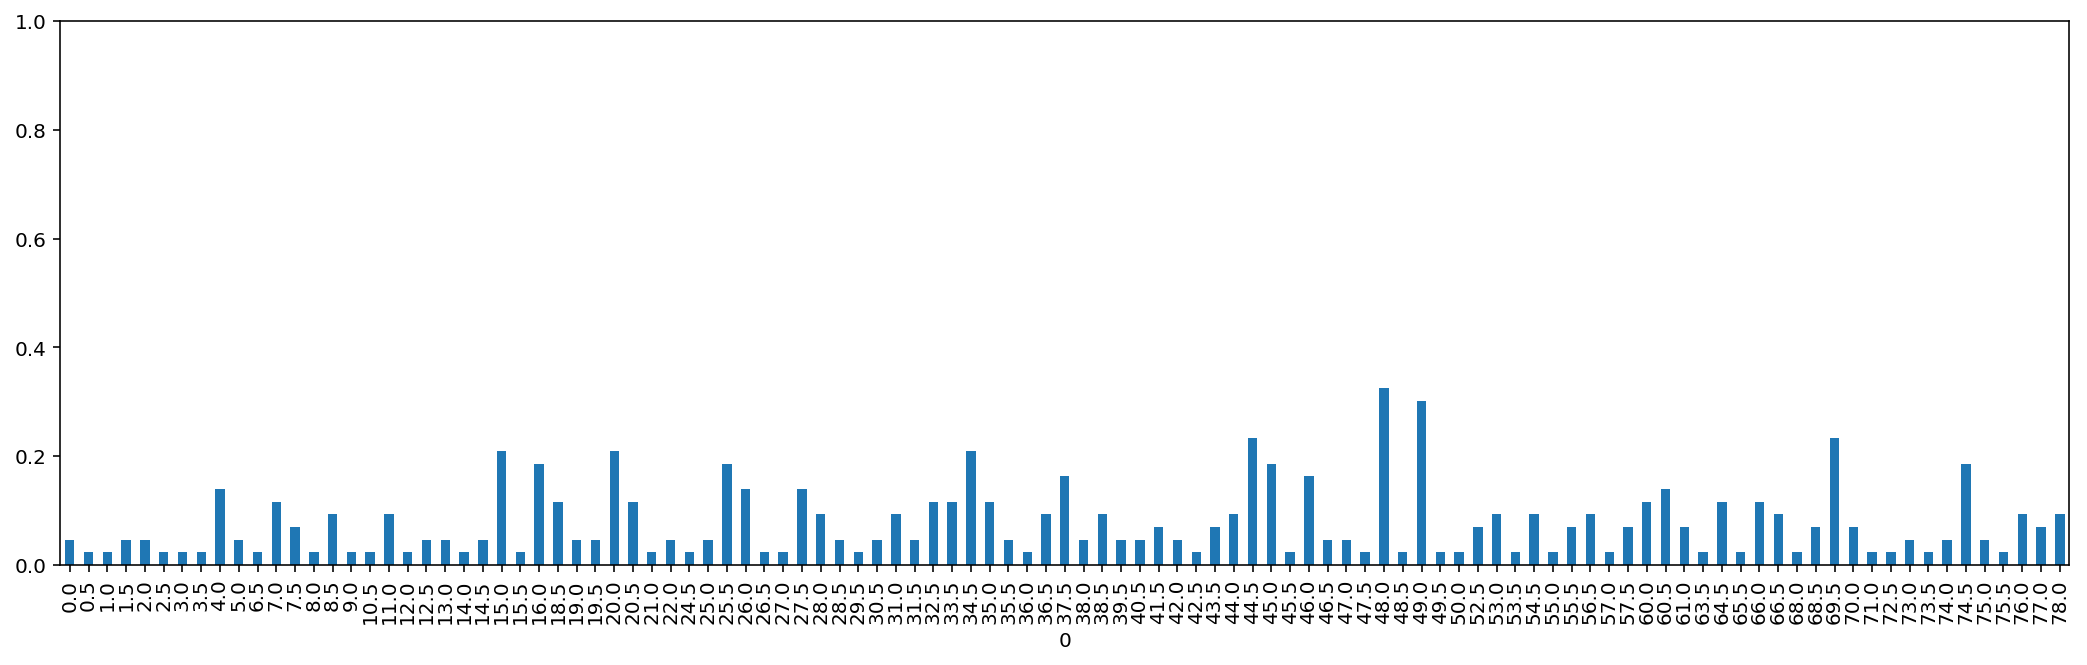

In [148]:
(pd.DataFrame([x_ for x in var_poss for x_ in x]).groupby(0).size() / (len(seqs) - 1)).plot.bar(xlim=(0, len(cons)), ylim=(0, 1), figsize=(18, 5))
